In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib as mpl
import numpy as np
import scipy
import math
import pickle
from IPython.display import Image
from matplotlib.colors import LinearSegmentedColormap
from scipy.interpolate import interp2d
from qutip import *
qutip.settings.has_mkl = False

import time

import sys
# sys.path.append("../")
from functions1ps2psCsi_v3 import calc_S_Gamma, calc_G_Gamma11, calc_G_Gamma12, \
    calc_g_Gamma12, calc_G_Gamma12_tau, calc_g_Gamma12_alpha, \
    calc_CSI, calc_g_Gamma12_twooperators


In [2]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
fts = 14
fts2 = 12

# Figure 2

## Figure 2b

In [ ]:
kappa_d = .05 * kappa_a
delta_g = .5
detuning = delta_g
Omega = .5

### spectrum

In [ ]:
fig, ax = plt.subplots(1, 1)
# fig.set_size_inches(2.25, .85*.8)
fig.set_size_inches(2.54, .85*.8)

start = time.time()

npoints = 200;

kappa_a = 1.

wlist2_0 = np.linspace(-2, 2, npoints)


N = 7
Nall = N
a = destroy(N)
ident = qeye(N)

nn = a.dag()*a
c_ops = [np.sqrt(kappa_a) * a]

Hoptomech = - delta_g*a.dag()*a.dag()*a*a + 1j*Omega*(a.dag() - a)
sS_d = np.empty(shape=(npoints))
rho_ss = steadystate(Hoptomech, c_ops, method = 'direct')
alpha = np.abs(expect(a, rho_ss))

# Hoptomech = detuning*a.dag()*a - delta_g*a.dag()*a*a.dag()*a + 1j*Omega*(a.dag() - a)
# Hoptomech = - delta_g*a.dag()*a.dag()*a*a + 1j*Omega*(a.dag() - a)

Hoptomech = \
      - 0.*detuning*a.dag()*a.dag()*a*a \
      - 0.*detuning*2*(np.absolute(alpha)**2)*(alpha*a.dag()+np.conj(alpha)*a) \
      - 0.*detuning*4*(np.absolute(alpha)**2)*a.dag()*a \
      - detuning*((np.conj(alpha)**2)*a*a + a.dag()*a.dag()*alpha**2) \
      - 0.*detuning*2*(np.conj(alpha)*a.dag()*a*a+a.dag()*a.dag()*a*alpha)

sS_d = np.empty(shape=(npoints))
rho_ss = steadystate(Hoptomech, c_ops, method = 'direct')
lv = liouvillian(Hoptomech, c_ops)
jj = 0
for wd1 in wlist2_0: 
    sS_d[jj] = calc_S_Gamma(rho_ss, lv, kappa_d, wd1, a, Nall)
    jj = jj+1
# ax.plot(wlist2_0, 1e3*sS_d, 'k-', lw=1.5, label='_nolegend_')
ax.plot(wlist2_0, 2e3*sS_d, color='tab:gray', linestyle='-', lw=1.5, label='_nolegend_')

# alpha = expect(a, rho_ss)

# jj = 0
# for wd1 in wlist2_0: 
#     sS_d[jj] = calc_S_Gamma(rho_ss, lv, kappa_d, wd1, a-alpha*ident, Nall)
#     jj = jj+1
# # ax.plot(wlist2_0, 1e3*sS_d, 'k-', lw=1.5, label='_nolegend_')
# ax.plot(wlist2_0, 2e3*sS_d, color='k', linestyle='--', lw=1.5, label='_nolegend_')


end = time.time()
print(end-start)

ax.legend()
# ax.set_xlabel(r'$\omega-\omega_L$', fontsize=12)
ax.set_ylabel(r'$S_\Gamma[\delta a](\omega_1)$', fontsize=fts)
ax.set_xticks([-4,-2,0,2,4])
ax.set_xticklabels([])
# ax.set_xticklabels([r'$-4\kappa_a$',r'$-2\kappa_a$',0,r'$2\kappa_a$',r'4$\kappa_a$'])

# plt.xlim(-1,1)
plt.xlim(-2,2)
plt.ylim(1,1e5)
ax.fill_between(wlist2_0, 1, 2e3*sS_d, color='k', alpha=0.1)
ax.set_yscale('log')
ax.set_yticks([1, 1e4])
ax.set_yticklabels([r'$1$',r'$10^4$'], fontsize=fts2)
ax.get_legend().remove()

# f = mpl.ticker.ScalarFormatter(useOffset=False, useMathText=True)
# g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.10e' % x))
# plt.gca().yaxis.set_major_formatter(mpl.ticker.FuncFormatter(g))
# plt.gcf().subplots_adjust(bottom=0.1, left=0.2)

fig.savefig('Spect_2b.svg', dpi=2000)
fig.savefig('Spect_2b.png', dpi=2000)

print(expect(a.dag()*a.dag()*a*a, rho_ss)/expect(a.dag()*a, rho_ss)**2)

plt.show()


### correlations map

In [ ]:
import time

npoints = 161

kappa_a = 1.
# delta_gS = [0., .5, 1.5] 
alpha = 1

delta_g = .5
detuning = delta_g
Omega = .5

N = 8
Nall = N

a = destroy(N)
ident = qeye(N)
nn = a.dag()*a

suffix = "_Fig2newb_kerr2_2";
wd1S = np.linspace(-2,2, npoints)
# wd1S = np.linspace(-1,1, npoints)
dx = (wd1S[-1]-wd1S[0])/npoints
spectrumD1 = np.empty(npoints)
kappa_d = .05 * kappa_a
correlations = np.empty(shape=(npoints,npoints,6))

# ################################

redo = 1

if redo == 1:
    start = time.time()
    ii = 0
    c_ops = [np.sqrt(kappa_a) * a]

    Hoptomech = - delta_g*a.dag()*a.dag()*a*a + 1j*Omega*(a.dag() - a)
    sS_d = np.empty(shape=(npoints))
    rho_ss = steadystate(Hoptomech, c_ops, method = 'direct')
    alpha = np.abs(expect(a, rho_ss))

    Hoptomech = \
      - 0.*detuning*a.dag()*a.dag()*a*a \
      - 0.*detuning*2*(np.absolute(alpha)**2)*(alpha*a.dag()+np.conj(alpha)*a) \
      - 0.*detuning*4*(np.absolute(alpha)**2)*a.dag()*a \
      - detuning*((np.conj(alpha)**2)*a*a + a.dag()*a.dag()*alpha**2) \
      - 0.*detuning*2*(np.conj(alpha)*a.dag()*a*a+a.dag()*a.dag()*a*alpha)
    
#     Hoptomech = - delta_g*((np.conj(alpha)**2)*a*a + a.dag()*a.dag()*alpha**2)

    rho_ss = steadystate(Hoptomech, c_ops, method = 'direct')
    alpha = expect(a, rho_ss)
    
    lv = liouvillian(Hoptomech, c_ops)
    for wd1 in wd1S:
        jj = 0
        for wd2 in wd1S[0:(ii+1)]:
            correlations[ii,jj] = [wd1, wd2, 0., \
             calc_g_Gamma12(rho_ss, lv, kappa_d, wd1, wd2, a - alpha*ident, Nall), 1, N]
            correlations[jj,ii] = [wd2, wd1, 0., \
             calc_g_Gamma12(rho_ss, lv, kappa_d, wd1, wd2, a, Nall), 1, N]
#             correlations[jj,ii] = correlations[ii,jj]
            jj += 1
        ii += 1
    end = time.time()
    print(end-start)

    with open("colored_g2_test2smg0_N=" + str(N) + "_npoints=" + str(npoints) + suffix + ".txt", "wb") as fp: 
        pickle.dump(correlations, fp)

with open("colored_g2_test2smg0_N=" + str(N) + "_npoints=" + str(npoints) + suffix + ".txt", "rb") as fp:
    correlations2 = pickle.load(fp)

ii = 0    
for wd1 in wd1S:
    jj = 0
    for wd2 in wd1S[0:(ii+1)]:
        correlations2[ii,jj] = correlations2[jj,ii]
        jj += 1
    ii += 1        
    
toPlot = np.zeros(shape=(npoints,npoints,3))
toPlot = correlations2[:, :, [0,1,3]]
xs = correlations2[:, :, 0].flatten()
ys = correlations2[:, :, 1].flatten()

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(1.12*3.2,1.12*3)

xGrid, yGrid = np.meshgrid(wd1S, wd1S)
xGride = np.append(xGrid, np.transpose([np.ones(npoints)*(xGrid[0,-1]+dx)]), axis=1)
xGridee = np.append(xGride, [xGride[-1]], axis=0)-.5*dx

yGride = np.append(yGrid, np.transpose([yGrid[:,0]]), axis=1)
yGridee = np.append(yGride, [np.ones(npoints+1)*(yGrid[-1,0]+dx)], axis=0)-.5*dx

zGrid = toPlot[:,:,2]
# zMax = np.float64(10)
# zMin = np.float64(0.1)
zMax = np.float64(4)
zMin = np.float64(0.25)
dm = np.log10(zMax/zMin)
blue_red1 = LinearSegmentedColormap.from_list('mycmap', [
    (0, 'blue'),
#     (np.log10(1/zMin)/dm, 'blue'),
    (np.log10(1/zMin)/dm, 'white'),
    (1.0000, 'red')])

im = ax.pcolormesh(xGridee, yGridee, np.log10(toPlot[:,:,2]), vmin=np.log10(zMin), vmax=np.log10(zMax), cmap=blue_red1)
# cbar = fig.colorbar(im, ax=ax)
# # cbar.set_ticks([-1, 0, 1] + list(range(0,math.floor(zMax.astype(int))+1,5))) 
# # cbar.set_ticks([-1, 0, 1]) 
# cbar.set_ticks([np.log10(zMin), 0, np.log10(zMax)]) 
# # cbar.ax.set_yticklabels(['<0.1', '1', '>10'])
# # cbar.ax.set_yticklabels([zMin, '1', '>2'])
# cbar.ax.set_yticklabels(['<0.25', '1', '>4'])

ax.set_xticks([-4,-2,0,2,4])
ax.set_yticks([-4,-2,0,2,4])
ax.set_xticklabels([r'$-4\kappa$',r'$-2\kappa$',r'$0$',r'$2\kappa$',r'$4\kappa$'], fontsize=fts2)
ax.set_yticklabels([r'$-4\kappa$',r'$-2\kappa$',r'$0$',r'$2\kappa$',r'$4\kappa$'], fontsize=fts2)

ax.set_xlabel(r'$\omega_1-\omega_L$', fontsize=fts)
ax.set_ylabel(r'$\omega_2-\omega_L$', fontsize=fts)
plt.xlim(xGridee[0,0], xGridee[0,-1])
plt.ylim(yGridee[0,0], yGridee[-1,0])

plt.gcf().subplots_adjust(bottom=0.3, left=0.3, right=.85)

fig.savefig('2PS_2b.svg', dpi=1000)
fig.savefig('2PS_2b.png', dpi=1000)

plt.show()

## Figure 2c

In [ ]:
kappa_d = .05 * kappa_a
delta_g = .5
detuning = delta_g
Omega = .5

### spectrum

In [ ]:
fig, ax = plt.subplots(1, 1)
# fig.set_size_inches(2.25, .85*.8)
fig.set_size_inches(2.54, .85*.8)

start = time.time()

npoints = 200;

kappa_a = 1.

wlist2_0 = np.linspace(-2, 2, npoints)


N = 7
Nall = N
a = destroy(N)
ident = qeye(N)

nn = a.dag()*a
c_ops = [np.sqrt(kappa_a) * a]

Hoptomech = - delta_g*a.dag()*a.dag()*a*a + 1j*Omega*(a.dag() - a)
sS_d = np.empty(shape=(npoints))
rho_ss = steadystate(Hoptomech, c_ops, method = 'direct')
alpha = np.abs(expect(a, rho_ss))

Hoptomech = \
      - detuning*a.dag()*a.dag()*a*a \
      - detuning*2*(np.absolute(alpha)**2)*(alpha*a.dag()+np.conj(alpha)*a) \
      - 0.*detuning*4*(np.absolute(alpha)**2)*a.dag()*a \
      - 0.*detuning*((np.conj(alpha)**2)*a*a + a.dag()*a.dag()*alpha**2) \
      - 0.*detuning*2*(np.conj(alpha)*a.dag()*a*a+a.dag()*a.dag()*a*alpha)

sS_d = np.empty(shape=(npoints))
rho_ss = steadystate(Hoptomech, c_ops, method = 'direct')
lv = liouvillian(Hoptomech, c_ops)
jj = 0
for wd1 in wlist2_0: 
    sS_d[jj] = calc_S_Gamma(rho_ss, lv, kappa_d, wd1, a, Nall)
    jj = jj+1
# ax.plot(wlist2_0, 1e3*sS_d, 'k-', lw=1.5, label='_nolegend_')
ax.plot(wlist2_0, 2e3*sS_d, color='tab:gray', linestyle='-', lw=1.5, label='_nolegend_')

alpha = expect(a, rho_ss)

# jj = 0
# for wd1 in wlist2_0: 
#     sS_d[jj] = calc_S_Gamma(rho_ss, lv, kappa_d, wd1, a-alpha*ident, Nall)
#     jj = jj+1
# # ax.plot(wlist2_0, 1e3*sS_d, 'k-', lw=1.5, label='_nolegend_')
# ax.plot(wlist2_0, 2e3*sS_d, color='k', linestyle='--', lw=1.5, label='_nolegend_')

end = time.time()
print(end-start)

ax.legend()
# ax.set_xlabel(r'$\omega-\omega_L$', fontsize=12)
ax.set_ylabel(r'$S_\Gamma[\delta a](\omega_1)$', fontsize=fts)
ax.set_xticks([-4,-2,0,2,4])
ax.set_xticklabels([])
# ax.set_xticklabels([r'$-4\kappa_a$',r'$-2\kappa_a$',0,r'$2\kappa_a$',r'4$\kappa_a$'])

# plt.xlim(-1,1)
plt.xlim(-2,2)
plt.ylim(1,1e5)
ax.fill_between(wlist2_0, 1, 2e3*sS_d, color='k', alpha=0.1)
ax.set_yscale('log')
ax.set_yticks([1, 1e4])
ax.set_yticklabels([r'$1$',r'$10^4$'], fontsize=fts2)
ax.get_legend().remove()

# f = mpl.ticker.ScalarFormatter(useOffset=False, useMathText=True)
# g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.10e' % x))
# plt.gca().yaxis.set_major_formatter(mpl.ticker.FuncFormatter(g))
# plt.gcf().subplots_adjust(bottom=0.1, left=0.2)

fig.savefig('Spect_2c.svg', dpi=2000)
fig.savefig('Spect_2c.png', dpi=2000)

print(expect(a.dag()*a.dag()*a*a, rho_ss)/expect(a.dag()*a, rho_ss)**2)

plt.show()


### correlations map

In [ ]:
import time

npoints = 161

kappa_a = 1.
# delta_gS = [0., .5, 1.5] 
alpha = 1

N = 8
Nall = N

a = destroy(N)
ident = qeye(N)
nn = a.dag()*a

suffix = "_Fig2newb_kerr2_3";
wd1S = np.linspace(-2,2, npoints)
# wd1S = np.linspace(-1,1, npoints)
dx = (wd1S[-1]-wd1S[0])/npoints
spectrumD1 = np.empty(npoints)
kappa_d = .05 * kappa_a
correlations = np.empty(shape=(npoints,npoints,6))

# ################################

redo = 1

if redo == 1:
    start = time.time()
    ii = 0
    c_ops = [np.sqrt(kappa_a) * a]

    Hoptomech = - delta_g*a.dag()*a.dag()*a*a + 1j*Omega*(a.dag() - a)
    sS_d = np.empty(shape=(npoints))
    rho_ss = steadystate(Hoptomech, c_ops, method = 'direct')
    alpha = np.abs(expect(a, rho_ss))

    Hoptomech = \
      - detuning*a.dag()*a.dag()*a*a \
      - detuning*2*(np.absolute(alpha)**2)*(alpha*a.dag()+np.conj(alpha)*a) \
      - 0.*detuning*4*(np.absolute(alpha)**2)*a.dag()*a \
      - 0.*detuning*((np.conj(alpha)**2)*a*a + a.dag()*a.dag()*alpha**2) \
      - 0.*detuning*2*(np.conj(alpha)*a.dag()*a*a+a.dag()*a.dag()*a*alpha)

    rho_ss = steadystate(Hoptomech, c_ops, method = 'direct')
    alpha = expect(a, rho_ss)
    
    lv = liouvillian(Hoptomech, c_ops)
    for wd1 in wd1S:
        jj = 0
        for wd2 in wd1S[0:(ii+1)]:
            correlations[ii,jj] = [wd1, wd2, 0., \
             calc_g_Gamma12(rho_ss, lv, kappa_d, wd1, wd2, a - alpha*ident, Nall), 1, N]
            correlations[jj,ii] = [wd2, wd1, 0., \
             calc_g_Gamma12(rho_ss, lv, kappa_d, wd1, wd2, a, Nall), 1, N]
#             correlations[jj,ii] = correlations[ii,jj]
            jj += 1
        ii += 1
    end = time.time()
    print(end-start)

    with open("colored_g2_test2smg0_N=" + str(N) + "_npoints=" + str(npoints) + suffix + ".txt", "wb") as fp: 
        pickle.dump(correlations, fp)

with open("colored_g2_test2smg0_N=" + str(N) + "_npoints=" + str(npoints) + suffix + ".txt", "rb") as fp:
    correlations2 = pickle.load(fp)

ii = 0    
for wd1 in wd1S:
    jj = 0
    for wd2 in wd1S[0:(ii+1)]:
        correlations2[ii,jj] = correlations2[jj,ii]
        jj += 1
    ii += 1    
    
toPlot = np.zeros(shape=(npoints,npoints,3))
toPlot = correlations2[:, :, [0,1,3]]
xs = correlations2[:, :, 0].flatten()
ys = correlations2[:, :, 1].flatten()

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(1.12*3.2,1.12*3)

xGrid, yGrid = np.meshgrid(wd1S, wd1S)
xGride = np.append(xGrid, np.transpose([np.ones(npoints)*(xGrid[0,-1]+dx)]), axis=1)
xGridee = np.append(xGride, [xGride[-1]], axis=0)-.5*dx

yGride = np.append(yGrid, np.transpose([yGrid[:,0]]), axis=1)
yGridee = np.append(yGride, [np.ones(npoints+1)*(yGrid[-1,0]+dx)], axis=0)-.5*dx

zGrid = toPlot[:,:,2]
# zMax = np.float64(10)
# zMin = np.float64(0.1)
zMax = np.float64(4)
zMin = np.float64(0.25)
dm = np.log10(zMax/zMin)
blue_red1 = LinearSegmentedColormap.from_list('mycmap', [
    (0, 'blue'),
#     (np.log10(1/zMin)/dm, 'blue'),
    (np.log10(1/zMin)/dm, 'white'),
    (1.0000, 'red')])

im = ax.pcolormesh(xGridee, yGridee, np.log10(toPlot[:,:,2]), vmin=np.log10(zMin), vmax=np.log10(zMax), cmap=blue_red1)
# cbar = fig.colorbar(im, ax=ax)
# cbar = fig.colorbar(im, ax=ax)
# cbar.set_ticks([-1, 0, 1] + list(range(0,math.floor(zMax.astype(int))+1,5))) 
# cbar.set_ticks([-1, 0, 1]) 
# cbar.set_ticks([np.log10(zMin), 0, np.log10(zMax)]) 
# # cbar.ax.set_yticklabels(['<0.1', '1', '>10'])
# # cbar.ax.set_yticklabels([zMin, '1', '>2'])
# cbar.ax.set_yticklabels(['<0.25', '1', '>4'])

ax.set_xticks([-4,-2,0,2,4])
ax.set_yticks([-4,-2,0,2,4])
ax.set_xticklabels([r'$-4\kappa$',r'$-2\kappa$',r'$0$',r'$2\kappa$',r'$4\kappa$'], fontsize=fts2)
ax.set_yticklabels([r'$-4\kappa$',r'$-2\kappa$',r'$0$',r'$2\kappa$',r'$4\kappa$'], fontsize=fts2)

ax.set_xlabel(r'$\omega_1-\omega_L$', fontsize=fts)
ax.set_ylabel(r'$\omega_2-\omega_L$', fontsize=fts)
plt.xlim(xGridee[0,0], xGridee[0,-1])
plt.ylim(yGridee[0,0], yGridee[-1,0])

plt.gcf().subplots_adjust(bottom=0.3, left=0.3, right=.85)

fig.savefig('2PS_2c.svg', dpi=1000)
fig.savefig('2PS_2c.png', dpi=1000)

### correlations map - zoomed in

In [ ]:
import time

npoints = 81

kappa_a = 1.
# delta_gS = [0., .5, 1.5] 
alpha = 1

delta_g = .5
detuning = delta_g
Omega = .5

N = 8
Nall = N

a = destroy(N)
ident = qeye(N)
nn = a.dag()*a

suffix = "_Fig2newb_kerr2_3zoom";
wd1S = np.linspace(-.4,.4, npoints)
# wd1S = np.linspace(-1,1, npoints)
dx = (wd1S[-1]-wd1S[0])/npoints
spectrumD1 = np.empty(npoints)
kappa_d = .05 * kappa_a
correlations = np.empty(shape=(npoints,npoints,6))

# ################################

redo = 1

if redo == 1:
    start = time.time()
    ii = 0
    c_ops = [np.sqrt(kappa_a) * a]

    Hoptomech = - delta_g*a.dag()*a.dag()*a*a + 1j*Omega*(a.dag() - a)
    sS_d = np.empty(shape=(npoints))
    rho_ss = steadystate(Hoptomech, c_ops, method = 'direct')
    alpha = np.abs(expect(a, rho_ss))

    Hoptomech = \
      - detuning*a.dag()*a.dag()*a*a \
      - detuning*2*(np.absolute(alpha)**2)*(alpha*a.dag()+np.conj(alpha)*a) \
      - 0.*detuning*4*(np.absolute(alpha)**2)*a.dag()*a \
      - 0.*detuning*((np.conj(alpha)**2)*a*a + a.dag()*a.dag()*alpha**2) \
      - 0.*detuning*2*(np.conj(alpha)*a.dag()*a*a+a.dag()*a.dag()*a*alpha)

    rho_ss = steadystate(Hoptomech, c_ops, method = 'direct')
    alpha = expect(a, rho_ss)
    
    lv = liouvillian(Hoptomech, c_ops)
    for wd1 in wd1S:
        jj = 0
        for wd2 in wd1S[0:(ii+1)]:
            correlations[ii,jj] = [wd1, wd2, 0., \
             calc_g_Gamma12(rho_ss, lv, kappa_d, wd1, wd2, a - alpha*ident, Nall), 1, N]
            correlations[jj,ii] = [wd2, wd1, 0., \
             calc_g_Gamma12(rho_ss, lv, kappa_d, wd1, wd2, a, Nall), 1, N]
#             correlations[jj,ii] = correlations[ii,jj]
            jj += 1
        ii += 1
    end = time.time()
    print(end-start)

    with open("colored_g2_test2smg0_N=" + str(N) + "_npoints=" + str(npoints) + suffix + ".txt", "wb") as fp: 
        pickle.dump(correlations, fp)

with open("colored_g2_test2smg0_N=" + str(N) + "_npoints=" + str(npoints) + suffix + ".txt", "rb") as fp:
    correlations2 = pickle.load(fp)

ii = 0    
for wd1 in wd1S:
    jj = 0
    for wd2 in wd1S[0:(ii+1)]:
        correlations2[ii,jj] = correlations2[jj,ii]
        jj += 1
    ii += 1    
    
toPlot = np.zeros(shape=(npoints,npoints,3))
toPlot = correlations2[:, :, [0,1,3]]
xs = correlations2[:, :, 0].flatten()
ys = correlations2[:, :, 1].flatten()

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(.5*1.12*3.2,.5*1.12*3)

xGrid, yGrid = np.meshgrid(wd1S, wd1S)
xGride = np.append(xGrid, np.transpose([np.ones(npoints)*(xGrid[0,-1]+dx)]), axis=1)
xGridee = np.append(xGride, [xGride[-1]], axis=0)-.5*dx

yGride = np.append(yGrid, np.transpose([yGrid[:,0]]), axis=1)
yGridee = np.append(yGride, [np.ones(npoints+1)*(yGrid[-1,0]+dx)], axis=0)-.5*dx

zGrid = toPlot[:,:,2]
# zMax = np.float64(10)
# zMin = np.float64(0.1)
zMax = np.float64(4)
zMin = np.float64(0.25)
dm = np.log10(zMax/zMin)
blue_red1 = LinearSegmentedColormap.from_list('mycmap', [
    (0, 'blue'),
#     (np.log10(1/zMin)/dm, 'blue'),
    (np.log10(1/zMin)/dm, 'white'),
    (1.0000, 'red')])

im = ax.pcolormesh(xGridee, yGridee, np.log10(toPlot[:,:,2]), vmin=np.log10(zMin), vmax=np.log10(zMax), cmap=blue_red1)
# cbar = fig.colorbar(im, ax=ax)
# cbar = fig.colorbar(im, ax=ax)
# cbar.set_ticks([-1, 0, 1] + list(range(0,math.floor(zMax.astype(int))+1,5))) 
# cbar.set_ticks([-1, 0, 1]) 
# cbar.set_ticks([np.log10(zMin), 0, np.log10(zMax)]) 
# # cbar.ax.set_yticklabels(['<0.1', '1', '>10'])
# # cbar.ax.set_yticklabels([zMin, '1', '>2'])
# cbar.ax.set_yticklabels(['<0.25', '1', '>4'])

ax.set_xticks([-.4,.4])
ax.set_yticks([-.4,.4])
ax.set_xticklabels([r'$-0.4\kappa$',r'$0.4\kappa$'], fontsize=fts2)
ax.set_yticklabels([r'$-0.4\kappa$',r'$0.4\kappa$'], fontsize=fts2)

ax.set_xlabel(r'$\omega_1-\omega_L$', fontsize=fts)
ax.set_ylabel(r'$\omega_2-\omega_L$', fontsize=fts)
plt.xlim(xGridee[0,0], xGridee[0,-1])
plt.ylim(yGridee[0,0], yGridee[-1,0])

plt.gcf().subplots_adjust(bottom=0.3, left=0.3, right=.85)

ax.set_rasterized(True) 

fig.savefig('2PS_2c_zoom.svg', dpi=1000)
fig.savefig('2PS_2c_zoom.png', dpi=1000)

## Figure 2d

In [ ]:
kappa_d = .05 * kappa_a
delta_g = .5
detuning = delta_g
Omega = .5

### spectrum

In [ ]:
fig, ax = plt.subplots(1, 1)
# fig.set_size_inches(2.25, .85*.8)
fig.set_size_inches(2.54, .85*.8)

start = time.time()

npoints = 200;

kappa_a = 1.

wlist2_0 = np.linspace(-2, 2, npoints)

N = 7
Nall = N
a = destroy(N)
ident = qeye(N)

nn = a.dag()*a
c_ops = [np.sqrt(kappa_a) * a]

# Hoptomech = detuning*a.dag()*a - delta_g*a.dag()*a*a.dag()*a + 1j*Omega*(a.dag() - a)
Hoptomech = - delta_g*a.dag()*a.dag()*a*a + 1j*Omega*(a.dag() - a)
sS_d = np.empty(shape=(npoints))
rho_ss = steadystate(Hoptomech, c_ops, method = 'direct')
lv = liouvillian(Hoptomech, c_ops)
jj = 0
for wd1 in wlist2_0: 
    sS_d[jj] = calc_S_Gamma(rho_ss, lv, kappa_d, wd1, a, Nall)
    jj = jj+1
# ax.plot(wlist2_0, 1e3*sS_d, 'k-', lw=1.5, label='_nolegend_')
ax.plot(wlist2_0, 2e3*sS_d, color='tab:gray', linestyle='-', lw=1.5, label='_nolegend_')

alpha = expect(a, rho_ss)

jj = 0
for wd1 in wlist2_0: 
    sS_d[jj] = calc_S_Gamma(rho_ss, lv, kappa_d, wd1, a-alpha*ident, Nall)
    jj = jj+1
# ax.plot(wlist2_0, 1e3*sS_d, 'k-', lw=1.5, label='_nolegend_')
ax.plot(wlist2_0, 2e3*sS_d, color='k', linestyle='--', lw=1.5, label='_nolegend_')


end = time.time()
print(end-start)

ax.legend()
# ax.set_xlabel(r'$\omega-\omega_L$', fontsize=12)
ax.set_ylabel(r'$S_\Gamma(\omega_1)$', fontsize=fts)
ax.set_xticks([-4,-2,0,2,4])
ax.set_xticklabels([])
# ax.set_xticklabels([r'$-4\kappa_a$',r'$-2\kappa_a$',0,r'$2\kappa_a$',r'4$\kappa_a$'])

# plt.xlim(-1,1)
plt.xlim(-2,2)
plt.ylim(1,1e5)
ax.fill_between(wlist2_0, 1, 2e3*sS_d, color='k', alpha=0.1)
ax.set_yscale('log')
ax.set_yticks([1, 1e4])
ax.set_yticklabels([r'$1$',r'$10^4$'], fontsize=fts2)
ax.get_legend().remove()

# f = mpl.ticker.ScalarFormatter(useOffset=False, useMathText=True)
# g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.10e' % x))
# plt.gca().yaxis.set_major_formatter(mpl.ticker.FuncFormatter(g))
# plt.gcf().subplots_adjust(bottom=0.1, left=0.2)

fig.savefig('Spect_2d.svg', dpi=2000)
fig.savefig('Spect_2d.png', dpi=2000)

print(expect(a.dag()*a.dag()*a*a, rho_ss)/expect(a.dag()*a, rho_ss)**2)

plt.show()


### correlations map

In [ ]:
import time

npoints = 161

kappa_a = 1.
# delta_gS = [0., .5, 1.5] 
alpha = 1

N = 8
Nall = N

a = destroy(N)
ident = qeye(N)
nn = a.dag()*a

suffix = "_Fig2newb_kerr2_test";
wd1S = np.linspace(-2,2, npoints)
# wd1S = np.linspace(-1,1, npoints)
dx = (wd1S[-1]-wd1S[0])/npoints
spectrumD1 = np.empty(npoints)
kappa_d = .05 * kappa_a
correlations = np.empty(shape=(npoints,npoints,6))

# ################################

redo = 0

if redo == 1:
    start = time.time()
    ii = 0
    c_ops = [np.sqrt(kappa_a) * a]

#     Hoptomech = detuning*a.dag()*a - delta_g*a.dag()*a*a.dag()*a + 1j*Omega*(a.dag() - a)
    Hoptomech = - delta_g*a.dag()*a.dag()*a*a + 1j*Omega*(a.dag() - a)
    
    rho_ss = steadystate(Hoptomech, c_ops, method = 'direct')
    alpha = expect(a, rho_ss)
    lv = liouvillian(Hoptomech, c_ops)
    for wd1 in wd1S:
        jj = 0
        for wd2 in wd1S[0:(ii+1)]:
            correlations[ii,jj] = [wd1, wd2, 0., \
             calc_g_Gamma12(rho_ss, lv, kappa_d, wd1, wd2, a-alpha*ident, Nall), 1, N]
            correlations[jj,ii] = [wd2, wd1, 0., \
             calc_g_Gamma12(rho_ss, lv, kappa_d, wd1, wd2, a, Nall), 1, N]
#             correlations[jj,ii] = correlations[ii,jj]
            jj += 1
        ii += 1
    end = time.time()
    print(end-start)

    with open("colored_g2_test2smg0_N=" + str(N) + "_npoints=" + str(npoints) + suffix + ".txt", "wb") as fp: 
        pickle.dump(correlations, fp)

with open("colored_g2_test2smg0_N=" + str(N) + "_npoints=" + str(npoints) + suffix + ".txt", "rb") as fp:
    correlations2 = pickle.load(fp)  
    
toPlot = np.zeros(shape=(npoints,npoints,3))
toPlot = correlations2[:, :, [0,1,3]]
xs = correlations2[:, :, 0].flatten()
ys = correlations2[:, :, 1].flatten()

fig, ax = plt.subplots(1, 1)
# fig.set_size_inches(1.56*3.2,1.07*3)
fig.set_size_inches(1.56*3.2,3.82)


addpoints = 30
wd1Sext = np.append(np.linspace(-2, 2, npoints), np.linspace(2+dx, 2+dx*addpoints, addpoints))
xGrid, yGrid = np.meshgrid(wd1S, wd1Sext)
xGride = np.append(xGrid, np.transpose([np.ones(npoints+1*addpoints)*(xGrid[0,-1]+dx)]), axis=1)
xGridee = np.append(xGride, [xGride[-1]], axis=0)-.5*dx
yGride = np.append(yGrid, np.transpose([yGrid[:,0]]), axis=1)
yGridee = np.append(yGride, [np.ones(npoints+1+0*addpoints)*(yGrid[-1,0]+dx)], axis=0)-.5*dx

zGrid = toPlot[:,:,2]
# zMax = np.float64(10)
# zMin = np.float64(0.1)
zMax = np.float64(4)
zMin = np.float64(0.25)
dm = np.log10(zMax/zMin)
blue_red1 = LinearSegmentedColormap.from_list('mycmap', [
    (0, 'blue'),
#     (np.log10(1/zMin)/dm, 'blue'),
    (np.log10(1/zMin)/dm, 'white'),
    (1.0000, 'red')])

toPlot2 = np.ones(shape=(npoints+addpoints,npoints,3))
for i in range(npoints):
    for j in range(npoints):
        if i>=j:
            toPlot2[i+1*addpoints,j,2] = toPlot[i,j,2]
        else:
            toPlot2[i,j+0*addpoints,2] = toPlot[i,j,2]
im = ax.pcolormesh(xGridee, yGridee, np.log10(toPlot2[:,:,2]), vmin=np.log10(zMin), vmax=np.log10(zMax), cmap=blue_red1)

cbar = fig.colorbar(im, ax=ax, pad=.17)
# cbar.set_ticks([-1, 0, 1] + list(range(0,math.floor(zMax.astype(int))+1,5))) 
# cbar.set_ticks([-1, 0, 1]) 
cbar.set_ticks([np.log10(zMin), 0, np.log10(zMax)]) 
cbar.ax.set_yticklabels([r'$<0.25$', r'$1$', r'$>4$'], fontsize=fts2)

ax.set_xticks([-4+0.*addpoints*dx,-2+0.*addpoints*dx,0+0.*addpoints*dx,2+0.*addpoints*dx,4+0.*addpoints*dx])
ax.set_yticks([-4+addpoints*dx,-2+addpoints*dx,0+addpoints*dx,2+addpoints*dx,4+addpoints*dx])

ax.set_xticklabels([r'$-4\kappa$',r'$-2\kappa$',r'$0$',r'$2\kappa$',r'$4\kappa$'], fontsize=fts2)
ax.set_yticklabels([r'$-4\kappa$',r'$-2\kappa$',r'$0$',r'$2\kappa$',r'$4\kappa$'], fontsize=fts2)

ax.set_xlabel(r'$\omega_1-\omega_L$', fontsize=fts)
ax.set_ylabel(r'$\omega_2-\omega_L$', fontsize=fts)
plt.xlim(xGridee[0,0], xGridee[0,-1])
plt.ylim(yGridee[0,0], yGridee[-1,0])

plt.gcf().subplots_adjust(bottom=0.27, left=0.27, right=.85)

fig.savefig('2PS_2d.svg', dpi=1000)
fig.savefig('2PS_2d.png', dpi=1000)

plt.show()

### correlations map - zoomed in

In [ ]:
import time

npoints = 81

kappa_a = 1.
# delta_gS = [0., .5, 1.5] 
alpha = 1


N = 8
Nall = N

a = destroy(N)
ident = qeye(N)
nn = a.dag()*a

suffix = "_Fig2newb_kerr2_zoom";
wd1S = np.linspace(-.4,.4, npoints)
# wd1S = np.linspace(-1,1, npoints)
dx = (wd1S[-1]-wd1S[0])/npoints
spectrumD1 = np.empty(npoints)
kappa_d = .05 * kappa_a
correlations = np.empty(shape=(npoints,npoints,6))

# ################################

redo = 0

if redo == 1:
    start = time.time()
    ii = 0
    c_ops = [np.sqrt(kappa_a) * a]

#     Hoptomech = detuning*a.dag()*a - delta_g*a.dag()*a*a.dag()*a + 1j*Omega*(a.dag() - a)
    Hoptomech = - delta_g*a.dag()*a.dag()*a*a + 1j*Omega*(a.dag() - a)
    
    rho_ss = steadystate(Hoptomech, c_ops, method = 'direct')
    alpha = expect(a, rho_ss)
    lv = liouvillian(Hoptomech, c_ops)
    for wd1 in wd1S:
        jj = 0
        for wd2 in wd1S[0:(ii+1)]:
            correlations[ii,jj] = [wd1, wd2, 0., \
             calc_g_Gamma12(rho_ss, lv, kappa_d, wd1, wd2, a-alpha*ident, Nall), 1, N]
            correlations[jj,ii] = [wd2, wd1, 0., \
             calc_g_Gamma12(rho_ss, lv, kappa_d, wd1, wd2, a, Nall), 1, N]
#             correlations[jj,ii] = correlations[ii,jj]
            jj += 1
        ii += 1
    end = time.time()
    print(end-start)

    with open("colored_g2_test2smg0_N=" + str(N) + "_npoints=" + str(npoints) + suffix + ".txt", "wb") as fp: 
        pickle.dump(correlations, fp)

with open("colored_g2_test2smg0_N=" + str(N) + "_npoints=" + str(npoints) + suffix + ".txt", "rb") as fp:
    correlations2 = pickle.load(fp)  
    
toPlot = np.zeros(shape=(npoints,npoints,3))
toPlot = correlations2[:, :, [0,1,3]]
xs = correlations2[:, :, 0].flatten()
ys = correlations2[:, :, 1].flatten()

fig, ax = plt.subplots(1, 1)
# fig.set_size_inches(1.56*3.2,1.07*3)
# fig.set_size_inches(.5*1.56*3.2,.5*3.82)
fig.set_size_inches(0.5*1.195*3,0.5*4)

addpoints = 30
wd1Sext = np.append(np.linspace(-.4, .4, npoints), np.linspace(.4+dx, .4+dx*addpoints, addpoints))
xGrid, yGrid = np.meshgrid(wd1S, wd1Sext)
xGride = np.append(xGrid, np.transpose([np.ones(npoints+1*addpoints)*(xGrid[0,-1]+dx)]), axis=1)
xGridee = np.append(xGride, [xGride[-1]], axis=0)-.5*dx
yGride = np.append(yGrid, np.transpose([yGrid[:,0]]), axis=1)
yGridee = np.append(yGride, [np.ones(npoints+1+0*addpoints)*(yGrid[-1,0]+dx)], axis=0)-.5*dx

zGrid = toPlot[:,:,2]
# zMax = np.float64(10)
# zMin = np.float64(0.1)
zMax = np.float64(4)
zMin = np.float64(0.25)
dm = np.log10(zMax/zMin)
blue_red1 = LinearSegmentedColormap.from_list('mycmap', [
    (0, 'blue'),
#     (np.log10(1/zMin)/dm, 'blue'),
    (np.log10(1/zMin)/dm, 'white'),
    (1.0000, 'red')])

toPlot2 = np.ones(shape=(npoints+addpoints,npoints,3))
for i in range(npoints):
    for j in range(npoints):
        if i>=j:
            toPlot2[i+1*addpoints,j,2] = toPlot[i,j,2]
        else:
            toPlot2[i,j+0*addpoints,2] = toPlot[i,j,2]
im = ax.pcolormesh(xGridee, yGridee, np.log10(toPlot2[:,:,2]), vmin=np.log10(zMin), vmax=np.log10(zMax), cmap=blue_red1)

# cbar = fig.colorbar(im, ax=ax, pad=.17)
# cbar.set_ticks([-1, 0, 1] + list(range(0,math.floor(zMax.astype(int))+1,5))) 
# cbar.set_ticks([-1, 0, 1]) 
cbar.set_ticks([np.log10(zMin), 0, np.log10(zMax)]) 
cbar.ax.set_yticklabels([r'$<0.25$', r'$1$', r'$>4$'], fontsize=fts2)

ax.set_xticks([-.4, .4])
ax.set_yticks([-.4+addpoints*dx,.4+addpoints*dx])

ax.set_xticklabels([r'$-0.4\kappa$',r'$0.4\kappa$'], fontsize=fts2)
ax.set_yticklabels([r'$-0.4\kappa$',r'$0.4\kappa$'], fontsize=fts2)

ax.set_xlabel(r'$\omega_1-\omega_L$', fontsize=fts)
ax.set_ylabel(r'$\omega_2-\omega_L$', fontsize=fts)
plt.xlim(xGridee[0,0], xGridee[0,-1])
plt.ylim(yGridee[0,0], yGridee[-1,0])

# plt.gcf().subplots_adjust(bottom=0.27, left=0.27, right=.85)
# plt.gcf().subplots_adjust(bottom=0.3, left=0.3, right=.85)
plt.gcf().subplots_adjust(bottom=0.3, left=0.3, right=.78)

fig.savefig('2PS_2d_zoom.svg', dpi=1000)
fig.savefig('2PS_2d_zoom.png', dpi=1000)

plt.show()

# Figure 3

## Figure 3b

In [ ]:
kappa_a = 1
kappa_b = .1
kappa_d = .05

wb = 2
Omega = .1
g0 = 1
delta_g = g0**2/wb
# fn = Omega*(g0/wb)**n/n!
f0 = Omega
f1 = Omega*(g0/wb)/1
f2 = Omega*(g0/wb)**2/2
f3 = Omega*(g0/wb)**3/6

detuning = delta_g

# alpha = np.abs(Omega/(1j*detuning + .5))

### spectrum

In [ ]:
fig, ax = plt.subplots(1, 1)
# fig.set_size_inches(2.25, .85*.8)
fig.set_size_inches(2.54, .85*.8)

start = time.time()

npoints = 200;

wlist2_0 = np.linspace(-5.5, 5.5, npoints)

N = 4
M = 6
Nall = N*M
a = tensor(destroy(N),qeye(M))
b = tensor(qeye(N),destroy(M))
ident = tensor(qeye(N),qeye(M))
nn = a.dag()*a
c_ops = [np.sqrt(kappa_a) * a, np.sqrt(kappa_b) * b]
Hamiltonian = detuning*a.dag()*a + wb*b.dag()*b \
        + 1j*f1*(a.dag() + a)*(b.dag() - b)
sS_d = np.empty(shape=(npoints))
rho_ss = steadystate(Hamiltonian, c_ops, method = 'direct')
alpha = expect(a, rho_ss)

lv = liouvillian(Hamiltonian, c_ops)
jj = 0
for wd1 in wlist2_0: 
    sS_d[jj] = calc_S_Gamma(rho_ss, lv, kappa_d, wd1, a, Nall)
    jj = jj+1
ax.plot(wlist2_0, 1e8*sS_d, color='tab:gray', linestyle='-', lw=1.5, label='_nolegend_')

lv = liouvillian(Hamiltonian, c_ops)
jj = 0
for wd1 in wlist2_0: 
    sS_d[jj] = calc_S_Gamma(rho_ss, lv, kappa_d, wd1, a-alpha*ident, Nall)
    jj = jj+1
ax.plot(wlist2_0, 1e8*sS_d, color='k', linestyle='--', lw=1.5, label='_nolegend_')

end = time.time()
print(end-start)

ax.legend()
# ax.set_xlabel(r'$\omega$', fontsize=fts)
ax.set_ylabel(r'$S_\Gamma(\omega_1)$', fontsize=fts)
ax.set_xticks([-2*wb,-wb,0,wb,2*wb])
# ax.set_xticklabels([r'$-2\omega_b$',r'$-\omega_b$',r'$0$',r'$\omega_b$',r'$2\omega_b$'], fontsize=fts2)
ax.set_xticklabels([], fontsize=fts2)

plt.xlim(-5.5,5.5)
plt.ylim(1,4e5)
ax.fill_between(wlist2_0, 1, 1e8*sS_d, color='k', alpha=0.1)
ax.set_yscale('log')
ax.set_yticks([1, 1e5])
ax.set_yticklabels([r'$1$',r'$10^5$'], fontsize=fts2)
ax.get_legend().remove()

# f = mpl.ticker.ScalarFormatter(useOffset=False, useMathText=True)
# g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.10e' % x))
# plt.gca().yaxis.set_major_formatter(mpl.ticker.FuncFormatter(g))
# plt.gcf().subplots_adjust(bottom=0.1, left=0.2)

fig.savefig('Spect_3b.svg', dpi=2000)
fig.savefig('Spect_3b.png', dpi=2000)

print(expect(a.dag()*a.dag()*a*a, rho_ss)/expect(a.dag()*a, rho_ss)**2)

plt.show()


### correlations map

In [ ]:

npoints = 161

kappa_a = 1.

N = 4
M = 6
Nall = N*M

a = tensor(destroy(N),qeye(M))
b = tensor(qeye(N),destroy(M))
ident = tensor(qeye(N),qeye(M))
nn = a.dag()*a

suffix = "_coh1_om_alpha";
wd1S = np.linspace(-5.5, 5.5, npoints)
dx = (wd1S[-1]-wd1S[0])/npoints
spectrumD1 = np.empty(npoints)
correlations = np.empty(shape=(npoints,npoints,6))

# ################################

redo = 0

if redo == 1:
    start = time.time()
    ii = 0
    c_ops = [np.sqrt(kappa_a) * a, np.sqrt(kappa_b) * b]

#     Hamiltonian = detuning*a.dag()*a + wb*b.dag()*b \
#         + 1j*f2*(a.dag() - a)*(b.dag() - b)*(b.dag() - b)
    Hamiltonian = detuning*a.dag()*a + wb*b.dag()*b \
        + 1j*f1*(a.dag() + a)*(b.dag() - b)

    rho_ss = steadystate(Hamiltonian, c_ops, method = 'direct')
    alpha = expect(a, rho_ss)
    
    lv = liouvillian(Hamiltonian, c_ops)
    for wd1 in wd1S:
        jj = 0
        for wd2 in wd1S[0:(ii+1)]:
            correlations[ii,jj] = [wd1, wd2, 0., \
             calc_g_Gamma12(rho_ss, lv, kappa_d, wd1, wd2, a-alpha*ident, Nall), 1, N]
            correlations[jj,ii] = [wd2, wd1, 0., \
             calc_g_Gamma12(rho_ss, lv, kappa_d, wd1, wd2, a, Nall), 1, N]           
#             correlations[jj,ii] = correlations[ii,jj]
            jj += 1
        ii += 1
    end = time.time()
    print(end-start)

    with open("colored_g2_test1smg0_N=" + str(N) + "_npoints=" + str(npoints) + suffix + ".txt", "wb") as fp: 
        pickle.dump(correlations, fp)

with open("colored_g2_test1smg0_N=" + str(N) + "_npoints=" + str(npoints) + suffix + ".txt", "rb") as fp:
    correlations2 = pickle.load(fp)

ii = 0    
for wd1 in wd1S:
    jj = 0
    for wd2 in wd1S[0:(ii+1)]:
        correlations2[ii,jj] = correlations2[jj,ii]
        jj += 1
    ii += 1        
    
toPlot = np.zeros(shape=(npoints,npoints,3))
toPlot = correlations2[:, :, [0,1,3]]
xs = correlations2[:, :, 0].flatten()
ys = correlations2[:, :, 1].flatten()

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(1.12*3.2,1.12*3)

xGrid, yGrid = np.meshgrid(wd1S, wd1S)
xGride = np.append(xGrid, np.transpose([np.ones(npoints)*(xGrid[0,-1]+dx)]), axis=1)
xGridee = np.append(xGride, [xGride[-1]], axis=0)-.5*dx

yGride = np.append(yGrid, np.transpose([yGrid[:,0]]), axis=1)
yGridee = np.append(yGride, [np.ones(npoints+1)*(yGrid[-1,0]+dx)], axis=0)-.5*dx


zGrid = toPlot[:,:,2]
zMax = np.float64(100)
zMin = np.float64(0.5)
# zMax = np.float64(100)
# zMin = np.float64(0.01)
# zMax = np.float64(2)
# zMin = np.float64(0.5)
dm = np.log10(zMax/zMin)
blue_red1 = LinearSegmentedColormap.from_list('mycmap', [
    (0, 'blue'),
#     (np.log10(1/zMin)/dm, 'blue'),
    (np.log10(1/zMin)/dm, 'white'),
    (1.0000, 'red')])

im = ax.pcolormesh(xGridee, yGridee, np.log10(toPlot[:,:,2]), vmin=np.log10(zMin), vmax=np.log10(zMax), cmap=blue_red1)
# cbar = fig.colorbar(im, ax=ax, pad=.17)
# cbar.set_ticks([-1, 0, 1] + list(range(0,math.floor(zMax.astype(int))+1,5))) 
# # cbar.set_ticks([-1, 0, 1]) 
# cbar.set_ticks([np.log10(zMin), 0, np.log10(zMax)]) 
# cbar.ax.set_yticklabels([r'$<0.5$', r'$1$', r'$>100$'])
# cbar.ax.set_yticklabels(['0.01', '1', '>100'])
# cbar.ax.set_yticklabels(['0.1', '1', '>10'])
# cbar.ax.set_yticklabels([zMin, '1', '>2'])

addpoints = 0
ax.set_xticks([-4+0*addpoints*dx,-2+0*addpoints*dx,0+0*addpoints*dx,2+0*addpoints*dx,4+0*addpoints*dx])
ax.set_yticks([-4+addpoints*dx,-2+addpoints*dx,0+addpoints*dx,2+addpoints*dx,4+addpoints*dx])

ax.set_xticklabels([r'$-2\omega_b$',r'$-\omega_b$',r'$0$',r'$\omega_b$',r'$2\omega_b$'], fontsize=fts2)
ax.set_yticklabels([r'$-2\omega_b$',r'$-\omega_b$',r'$0$',r'$\omega_b$',r'$2\omega_b$'], fontsize=fts2)


ax.set_xlabel(r'$\omega_1-\omega_L$', fontsize=fts)
ax.set_ylabel(r'$\omega_2-\omega_L$', fontsize=fts)

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks([-4,0,4])
ax2.set_xticklabels([r'$-4\kappa$',r'$0$',r'$4\kappa$'], fontsize=fts2)

ay2 = ax.twinx()
ay2.set_ylim(ax.get_xlim())
ay2.set_yticks([-4,0,4])
ay2.set_yticklabels([r'$-4\kappa$',r'$0$',r'$4\kappa$'], fontsize=fts2)

plt.xlim(xGridee[0,0], xGridee[0,-1])
plt.ylim(yGridee[0,0], yGridee[-1,0])

plt.gcf().subplots_adjust(bottom=0.3, left=0.3, right=.85)

fig.savefig('2PS_3b.svg', dpi=1000)
fig.savefig('2PS_3b.png', dpi=1000)

plt.show()

## Figure 3c

In [ ]:
kappa_a = 1
kappa_b = .1
kappa_d = .05

wb = 2
Omega = .1
g0 = 1
delta_g = g0**2/wb
# fn = Omega*(g0/wb)**n/n!
f0 = Omega
f1 = Omega*(g0/wb)/1
f2 = Omega*(g0/wb)**2/2
f3 = Omega*(g0/wb)**3/6

detuning = delta_g

# alpha = np.abs(Omega/(1j*detuning + .5))

### spectrum

In [ ]:
fig, ax = plt.subplots(1, 1)
# fig.set_size_inches(2.25, .85*.8)
fig.set_size_inches(2.54, .85*.8)

start = time.time()

npoints = 200;

wlist2_0 = np.linspace(-5.5, 5.5, npoints)

N = 4
M = 6
Nall = N*M
a = tensor(destroy(N),qeye(M))
b = tensor(qeye(N),destroy(M))
ident = tensor(qeye(N),qeye(M))
nn = a.dag()*a
c_ops = [np.sqrt(kappa_a) * a, np.sqrt(kappa_b) * b]
Hamiltonian = detuning*a.dag()*a + wb*b.dag()*b \
        + 1j*f2*(a.dag() - a)*(b.dag() - b)*(b.dag() - b)
sS_d = np.empty(shape=(npoints))
rho_ss = steadystate(Hamiltonian, c_ops, method = 'direct')
alpha = expect(a, rho_ss)

lv = liouvillian(Hamiltonian, c_ops)
jj = 0
for wd1 in wlist2_0: 
    sS_d[jj] = calc_S_Gamma(rho_ss, lv, kappa_d, wd1, a, Nall)
    jj = jj+1
ax.plot(wlist2_0, 1e8*sS_d, color='tab:gray', linestyle='-', lw=1.5, label='_nolegend_')

lv = liouvillian(Hamiltonian, c_ops)
jj = 0
for wd1 in wlist2_0: 
    sS_d[jj] = calc_S_Gamma(rho_ss, lv, kappa_d, wd1, a-alpha*ident, Nall)
    jj = jj+1
ax.plot(wlist2_0, 1e8*sS_d, color='k', linestyle='--', lw=1.5, label='_nolegend_')

end = time.time()
print(end-start)

ax.legend()
# ax.set_xlabel(r'$\omega$', fontsize=fts)
ax.set_ylabel(r'$S_\Gamma(\omega_1)$', fontsize=fts)
ax.set_xticks([-2*wb,-wb,0,wb,2*wb])
# ax.set_xticklabels([r'$-2\omega_b$',r'$-\omega_b$',r'$0$',r'$\omega_b$',r'$2\omega_b$'], fontsize=fts2)
ax.set_xticklabels([], fontsize=fts2)

plt.xlim(-5.5,5.5)
plt.ylim(1,4e5)
ax.fill_between(wlist2_0, 1, 1e8*sS_d, color='k', alpha=0.1)
ax.set_yscale('log')
ax.set_yticks([1, 1e5])
ax.set_yticklabels([r'$1$',r'$10^5$'], fontsize=fts2)
ax.get_legend().remove()

# f = mpl.ticker.ScalarFormatter(useOffset=False, useMathText=True)
# g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.10e' % x))
# plt.gca().yaxis.set_major_formatter(mpl.ticker.FuncFormatter(g))
# plt.gcf().subplots_adjust(bottom=0.1, left=0.2)

fig.savefig('Spect_3b.svg', dpi=2000)
fig.savefig('Spect_3b.png', dpi=2000)

print(expect(a.dag()*a.dag()*a*a, rho_ss)/expect(a.dag()*a, rho_ss)**2)

plt.show()


### correlations map

In [ ]:

npoints = 161

kappa_a = 1.

N = 4
M = 6
Nall = N*M

a = tensor(destroy(N),qeye(M))
b = tensor(qeye(N),destroy(M))
ident = tensor(qeye(N),qeye(M))
nn = a.dag()*a

suffix = "_coh2_om_alpha";
wd1S = np.linspace(-5.5, 5.5, npoints)
dx = (wd1S[-1]-wd1S[0])/npoints
spectrumD1 = np.empty(npoints)
correlations = np.empty(shape=(npoints,npoints,6))

# ################################

redo = 0

if redo == 1:
    start = time.time()
    ii = 0
    c_ops = [np.sqrt(kappa_a) * a, np.sqrt(kappa_b) * b]

    Hamiltonian = detuning*a.dag()*a + wb*b.dag()*b \
        + 1j*f2*(a.dag() - a)*(b.dag() - b)*(b.dag() - b)

    rho_ss = steadystate(Hamiltonian, c_ops, method = 'direct')
    alpha = expect(a, rho_ss)
    
    lv = liouvillian(Hamiltonian, c_ops)
    for wd1 in wd1S:
        jj = 0
        for wd2 in wd1S[0:(ii+1)]:
            correlations[ii,jj] = [wd1, wd2, 0., \
             calc_g_Gamma12(rho_ss, lv, kappa_d, wd1, wd2, a-alpha*ident, Nall), 1, N]
            correlations[jj,ii] = [wd2, wd1, 0., \
             calc_g_Gamma12(rho_ss, lv, kappa_d, wd1, wd2, a, Nall), 1, N]           
#             correlations[jj,ii] = correlations[ii,jj]
            jj += 1
        ii += 1
    end = time.time()
    print(end-start)

    with open("colored_g2_test1smg0_N=" + str(N) + "_npoints=" + str(npoints) + suffix + ".txt", "wb") as fp: 
        pickle.dump(correlations, fp)

with open("colored_g2_test1smg0_N=" + str(N) + "_npoints=" + str(npoints) + suffix + ".txt", "rb") as fp:
    correlations2 = pickle.load(fp)

toPlot = np.zeros(shape=(npoints,npoints,3))
# toPlot = correlations2[:, :, 0:3]
toPlot = correlations2[:, :, [0,1,3]]
xs = correlations2[:, :, 0].flatten()
ys = correlations2[:, :, 1].flatten()

fig, ax = plt.subplots(1, 1)
# fig.set_size_inches(.85*.8*6,.85*4)
fig.set_size_inches(1.195*3,4)

addpoints = 30
wd1Sext = np.append(np.linspace(-5.5, 5.5, npoints), np.linspace(5.5+dx, 5.5+dx*addpoints, addpoints))
xGrid, yGrid = np.meshgrid(wd1S, wd1Sext)
xGride = np.append(xGrid, np.transpose([np.ones(npoints+addpoints)*(xGrid[0,-1]+dx)]), axis=1)
xGridee = np.append(xGride, [xGride[-1]], axis=0)-.5*dx
yGride = np.append(yGrid, np.transpose([yGrid[:,0]]), axis=1)
yGridee = np.append(yGride, [np.ones(npoints+1+0*addpoints)*(yGrid[-1,0]+dx)], axis=0)-.5*dx

zGrid = toPlot[:,:,2]
zMax = np.float64(100)
zMin = np.float64(0.5)
# zMax = np.float64(100)
# zMin = np.float64(0.01)
# zMax = np.float64(2)
# zMin = np.float64(0.5)
dm = np.log10(zMax/zMin)
blue_red1 = LinearSegmentedColormap.from_list('mycmap', [
    (0, 'blue'),
#     (np.log10(1/zMin)/dm, 'blue'),
    (np.log10(1/zMin)/dm, 'white'),
    (1.0000, 'red')])

toPlot2 = np.ones(shape=(npoints+addpoints,npoints,3))
for i in range(npoints):
    for j in range(npoints):
        if i>=j:
            toPlot2[i+1*addpoints,j,2] = toPlot[i,j,2]
        else:
            toPlot2[i,j+0*addpoints,2] = toPlot[i,j,2]
im = ax.pcolormesh(xGridee, yGridee, np.log10(toPlot2[:,:,2]), vmin=np.log10(zMin), vmax=np.log10(zMax), cmap=blue_red1)
# cbar = fig.colorbar(im, ax=ax, pad=.17)
# cbar.set_ticks([-1, 0, 1] + list(range(0,math.floor(zMax.astype(int))+1,5))) 
# cbar.set_ticks([-1, 0, 1]) 
cbar.set_ticks([np.log10(zMin), 0, np.log10(zMax)]) 
cbar.ax.set_yticklabels([r'$<0.5$', r'$1$', r'$>100$'])
# cbar.ax.set_yticklabels(['0.01', '1', '>100'])
# cbar.ax.set_yticklabels(['0.1', '1', '>10'])
# cbar.ax.set_yticklabels([zMin, '1', '>2'])

ax.set_xticks([-4+0*addpoints*dx,-2+0*addpoints*dx,0+0*addpoints*dx,2+0*addpoints*dx,4+0*addpoints*dx])
ax.set_yticks([-4+addpoints*dx,-2+addpoints*dx,0+addpoints*dx,2+addpoints*dx,4+addpoints*dx])

ax.set_xticklabels([r'$-2\omega_b$',r'$-\omega_b$',r'$0$',r'$\omega_b$',r'$2\omega_b$'], fontsize=fts2)
ax.set_yticklabels([r'$-2\omega_b$',r'$-\omega_b$',r'$0$',r'$\omega_b$',r'$2\omega_b$'], fontsize=fts2)


ax.set_xlabel(r'$\omega_1-\omega_L$', fontsize=fts)
ax.set_ylabel(r'$\omega_2-\omega_L$', fontsize=fts)

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks([-4,0,4])
ax2.set_xticklabels([r'$-4\kappa$',r'$0$',r'$4\kappa$'], fontsize=fts2)

ay2 = ax.twinx()
ay2.set_ylim(ax.get_xlim())
ay2.set_yticks([-4,0,4])
ay2.set_yticklabels([r'$-4\kappa$',r'$0$',r'$4\kappa$'], fontsize=fts2)

plt.xlim(xGridee[0,0], xGridee[0,-1])
plt.ylim(yGridee[0,0], yGridee[-1,0])

plt.gcf().subplots_adjust(bottom=0.3, left=0.3, right=.85)

fig.savefig('2PS_3c.svg', dpi=1000)
fig.savefig('2PS_3c.png', dpi=1000)

plt.show()

## Figure 3d

In [ ]:
kappa_a = 1
kappa_b = .1
kappa_d = .05

wb = 2
Omega = .1
g0 = 1
delta_g = g0**2/wb
# fn = Omega*(g0/wb)**n/n!
f0 = Omega
f1 = Omega*(g0/wb)/1
f2 = Omega*(g0/wb)**2/2
f3 = Omega*(g0/wb)**3/6
f4 = Omega*(g0/wb)**4/24

detuning = delta_g

# alpha = np.abs(Omega/(1j*detuning + .5))

### spectrum

In [ ]:
fig, ax = plt.subplots(1, 1)
# fig.set_size_inches(2.25, .85*.8)
fig.set_size_inches(2.54, .85*.8)

start = time.time()

npoints = 200;

wlist2_0 = np.linspace(-5.5, 5.5, npoints)

N = 4
M = 6
Nall = N*M
a = tensor(destroy(N),qeye(M))
b = tensor(qeye(N),destroy(M))
ident = tensor(qeye(N),qeye(M))
nn = a.dag()*a
c_ops = [np.sqrt(kappa_a) * a, np.sqrt(kappa_b) * b]
Hamiltonian = detuning*a.dag()*a + wb*b.dag()*b \
        + 1j*f0*(a.dag() - a) \
        + 1j*f1*(a.dag() + a)*(b.dag() - b) \
        + 1j*f2*(a.dag() - a)*(b.dag() - b)*(b.dag() - b) \
        + 1j*f3*(a.dag() + a)*(b.dag() - b)*(b.dag() - b)*(b.dag() - b) \
        + 1j*f4*(a.dag() - a)*(b.dag() - b)*(b.dag() - b)*(b.dag() - b)*(b.dag() - b)

sS_d = np.empty(shape=(npoints))
rho_ss = steadystate(Hamiltonian, c_ops, method = 'direct')
alpha = expect(a, rho_ss)
lv = liouvillian(Hamiltonian, c_ops)
jj = 0
for wd1 in wlist2_0: 
    sS_d[jj] = calc_S_Gamma(rho_ss, lv, kappa_d, wd1, a, Nall)
    jj = jj+1
ax.plot(wlist2_0, 1e8*sS_d, color='tab:gray', linestyle='-', lw=1.5, label='_nolegend_')


sS_d = np.empty(shape=(npoints))
rho_ss = steadystate(Hamiltonian, c_ops, method = 'direct')
alpha = expect(a, rho_ss)
lv = liouvillian(Hamiltonian, c_ops)
jj = 0
for wd1 in wlist2_0: 
    sS_d[jj] = calc_S_Gamma(rho_ss, lv, kappa_d, wd1, a-alpha*ident, Nall)
    jj = jj+1
ax.plot(wlist2_0, 1e8*sS_d, color='k', linestyle='--', lw=1.5, label='_nolegend_')

end = time.time()
print(end-start)

ax.legend()
# ax.set_xlabel(r'$\omega$', fontsize=fts)
ax.set_ylabel(r'$S_\Gamma(\omega_1)$', fontsize=fts)
ax.set_xticks([-2*wb,-wb,0,wb,2*wb])
# ax.set_xticklabels([r'$-2\omega_b$',r'$-\omega_b$',r'$0$',r'$\omega_b$',r'$2\omega_b$'], fontsize=fts2)
ax.set_xticklabels([], fontsize=fts2)

plt.xlim(-5.5,5.5)
plt.ylim(1,2e7)
ax.fill_between(wlist2_0, 1, 1e8*sS_d, color='k', alpha=0.1)
ax.set_yscale('log')
ax.set_yticks([1, 1e5])
ax.set_yticklabels([r'$1$',r'$10^5$'], fontsize=fts2)
ax.get_legend().remove()

# f = mpl.ticker.ScalarFormatter(useOffset=False, useMathText=True)
# g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.10e' % x))
# plt.gca().yaxis.set_major_formatter(mpl.ticker.FuncFormatter(g))
# plt.gcf().subplots_adjust(bottom=0.1, left=0.2)

fig.savefig('Spect_3d.svg', dpi=2000)
fig.savefig('Spect_3d.png', dpi=2000)

print(expect(a.dag()*a.dag()*a*a, rho_ss)/expect(a.dag()*a, rho_ss)**2)

plt.show()


### correlations map

In [ ]:
npoints = 161

kappa_a = 1.

N = 4
M = 6
Nall = N*M

a = tensor(destroy(N),qeye(M))
b = tensor(qeye(N),destroy(M))
ident = tensor(qeye(N),qeye(M))
nn = a.dag()*a

suffix = "_coh4_om_alpha";
wd1S = np.linspace(-5.5, 5.5, npoints)
dx = (wd1S[-1]-wd1S[0])/npoints
spectrumD1 = np.empty(npoints)
correlations = np.empty(shape=(npoints,npoints,6))

# ################################

redo = 0

if redo == 1:
    start = time.time()
    ii = 0
    c_ops = [np.sqrt(kappa_a) * a, np.sqrt(kappa_b) * b]

    Hamiltonian = detuning*a.dag()*a + wb*b.dag()*b \
        + 1j*f0*(a.dag() - a) \
        + 1j*f1*(a.dag() + a)*(b.dag() - b) \
        + 1j*f2*(a.dag() - a)*(b.dag() - b)*(b.dag() - b) \
        + 1j*f3*(a.dag() + a)*(b.dag() - b)*(b.dag() - b)*(b.dag() - b) \
        + 1j*f4*(a.dag() - a)*(b.dag() - b)*(b.dag() - b)*(b.dag() - b)*(b.dag() - b)

    rho_ss = steadystate(Hamiltonian, c_ops, method = 'direct')
    alpha = expect(a, rho_ss)
    lv = liouvillian(Hamiltonian, c_ops)
    for wd1 in wd1S:
        jj = 0
        for wd2 in wd1S[0:(ii+1)]:
            correlations[ii,jj] = [wd1, wd2, 0., \
             calc_g_Gamma12(rho_ss, lv, kappa_d, wd1, wd2, a-alpha*ident, Nall), 1, N]
            correlations[jj,ii] = [wd2, wd1, 0., \
             calc_g_Gamma12(rho_ss, lv, kappa_d, wd1, wd2, a, Nall), 1, N]     
#             correlations[jj,ii] = correlations[ii,jj]
            jj += 1
        ii += 1
    end = time.time()
    print(end-start)

    with open("colored_g2_test1smg0_N=" + str(N) + "_npoints=" + str(npoints) + suffix + ".txt", "wb") as fp: 
        pickle.dump(correlations, fp)

with open("colored_g2_test1smg0_N=" + str(N) + "_npoints=" + str(npoints) + suffix + ".txt", "rb") as fp:
    correlations2 = pickle.load(fp)

toPlot = np.zeros(shape=(npoints,npoints,3))
# toPlot = correlations2[:, :, 0:3]
toPlot = correlations2[:, :, [0,1,3]]
xs = correlations2[:, :, 0].flatten()
ys = correlations2[:, :, 1].flatten()

fig, ax = plt.subplots(1, 1)
# fig.set_size_inches(.85*.8*6,.85*4)
# fig.set_size_inches(1.195*3,4)
fig.set_size_inches(5.25,4)

addpoints = 30
wd1Sext = np.append(np.linspace(-5.5, 5.5, npoints), np.linspace(5.5+dx, 5.5+dx*addpoints, addpoints))
xGrid, yGrid = np.meshgrid(wd1S, wd1Sext)
xGride = np.append(xGrid, np.transpose([np.ones(npoints+addpoints)*(xGrid[0,-1]+dx)]), axis=1)
xGridee = np.append(xGride, [xGride[-1]], axis=0)-.5*dx
yGride = np.append(yGrid, np.transpose([yGrid[:,0]]), axis=1)
yGridee = np.append(yGride, [np.ones(npoints+1+0*addpoints)*(yGrid[-1,0]+dx)], axis=0)-.5*dx

zGrid = toPlot[:,:,2]
zMax = np.float64(100)
zMin = np.float64(0.5)
# zMax = np.float64(100)
# zMin = np.float64(0.01)
# zMax = np.float64(2)
# zMin = np.float64(0.5)
dm = np.log10(zMax/zMin)
blue_red1 = LinearSegmentedColormap.from_list('mycmap', [
    (0, 'blue'),
#     (np.log10(1/zMin)/dm, 'blue'),
    (np.log10(1/zMin)/dm, 'white'),
    (1.0000, 'red')])

toPlot2 = np.ones(shape=(npoints+addpoints,npoints,3))
for i in range(npoints):
    for j in range(npoints):
        if i>=j:
            toPlot2[i+1*addpoints,j,2] = toPlot[i,j,2]
        else:
            toPlot2[i,j+0*addpoints,2] = toPlot[i,j,2]
im = ax.pcolormesh(xGridee, yGridee, np.log10(toPlot2[:,:,2]), vmin=np.log10(zMin), vmax=np.log10(zMax), cmap=blue_red1)
cbar = fig.colorbar(im, ax=ax, pad=.17)
# cbar.set_ticks([-1, 0, 1] + list(range(0,math.floor(zMax.astype(int))+1,5))) 
# cbar.set_ticks([-1, 0, 1]) 
cbar.set_ticks([np.log10(zMin), 0, np.log10(zMax)]) 
cbar.ax.set_yticklabels([r'$<0.5$', r'$1$', r'$>100$'])
# cbar.ax.set_yticklabels(['0.01', '1', '>100'])
# cbar.ax.set_yticklabels(['0.1', '1', '>10'])
# cbar.ax.set_yticklabels([zMin, '1', '>2'])

ax.set_xticks([-4+0*addpoints*dx,-2+0*addpoints*dx,0+0*addpoints*dx,2+0*addpoints*dx,4+0*addpoints*dx])
ax.set_yticks([-4+addpoints*dx,-2+addpoints*dx,0+addpoints*dx,2+addpoints*dx,4+addpoints*dx])

ax.set_xticklabels([r'$-2\omega_b$',r'$-\omega_b$',r'$0$',r'$\omega_b$',r'$2\omega_b$'], fontsize=fts2)
ax.set_yticklabels([r'$-2\omega_b$',r'$-\omega_b$',r'$0$',r'$\omega_b$',r'$2\omega_b$'], fontsize=fts2)


ax.set_xlabel(r'$\omega_1-\omega_L$', fontsize=fts)
ax.set_ylabel(r'$\omega_2-\omega_L$', fontsize=fts)

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks([-4,0,4])
ax2.set_xticklabels([r'$-4\kappa$',r'$0$',r'$4\kappa$'], fontsize=fts2)

ay2 = ax.twinx()
ay2.set_ylim(ax.get_xlim())
ay2.set_yticks([-4,0,4])
ay2.set_yticklabels([r'$-4\kappa$',r'$0$',r'$4\kappa$'], fontsize=fts2)

plt.xlim(xGridee[0,0], xGridee[0,-1])
plt.ylim(yGridee[0,0], yGridee[-1,0])

plt.gcf().subplots_adjust(bottom=0.3, left=0.3, right=.85)
    

fig.savefig('2PS_3d.svg', dpi=1000)
fig.savefig('2PS_3d.png', dpi=1000)

plt.show()

### correlations map - zoomed in region

In [ ]:

npoints = 161

N = 4
M = 6
Nall = N*M

a = tensor(destroy(N),qeye(M))
b = tensor(qeye(N),destroy(M))
ident = tensor(qeye(N),qeye(M))
nn = a.dag()*a

suffix = "_Fig3newc_zoom";
wd1S = np.linspace(-1, 1, npoints)
dx = (wd1S[-1]-wd1S[0])/npoints
spectrumD1 = np.empty(npoints)
correlations = np.empty(shape=(npoints,npoints,6))

# ################################

redo = 0

if redo == 1:
    start = time.time()
    ii = 0
    c_ops = [np.sqrt(kappa_a) * a, np.sqrt(kappa_b) * b]

    Hamiltonian = detuning*a.dag()*a + wb*b.dag()*b \
        + 1j*f0*(a.dag() - a) \
        + 1j*f1*(a.dag() + a)*(b.dag() - b) \
        + 1j*f2*(a.dag() - a)*(b.dag() - b)*(b.dag() - b) \
        + 1j*f3*(a.dag() + a)*(b.dag() - b)*(b.dag() - b)*(b.dag() - b) \
        + 1j*f4*(a.dag() - a)*(b.dag() - b)*(b.dag() - b)*(b.dag() - b)*(b.dag() - b)

    rho_ss = steadystate(Hamiltonian, c_ops, method = 'direct')
    alpha = expect(a, rho_ss)
    
    lv = liouvillian(Hamiltonian, c_ops)
    for wd1 in wd1S:
        jj = 0
        for wd2 in wd1S[0:(ii+1)]:
            correlations[ii,jj] = [wd1, wd2, 0., \
             calc_g_Gamma12(rho_ss, lv, kappa_d, wd1, wd2, a-alpha*ident, Nall), 1, N]
            correlations[jj,ii] = [wd2, wd1, 0., \
             calc_g_Gamma12(rho_ss, lv, kappa_d, wd1, wd2, a, Nall), 1, N]
#             correlations[jj,ii] = correlations[ii,jj]
            jj += 1
        ii += 1
    end = time.time()
    print(end-start)
    print(expect(a.dag()*a.dag()*a*a, rho_ss)/(expect(a.dag()*a, rho_ss)**2))

    with open("colored_g2_test1smg0_N=" + str(N) + "_npoints=" + str(npoints) + suffix + ".txt", "wb") as fp: 
        pickle.dump(correlations, fp)

with open("colored_g2_test1smg0_N=" + str(N) + "_npoints=" + str(npoints) + suffix + ".txt", "rb") as fp:
    correlations2 = pickle.load(fp)

toPlot = np.zeros(shape=(npoints,npoints,3))
# toPlot = correlations2[:, :, 0:3]
toPlot = correlations2[:, :, [0,1,3]]
xs = correlations2[:, :, 0].flatten()
ys = correlations2[:, :, 1].flatten()

fig, ax = plt.subplots(1, 1)
# fig.set_size_inches(1.56*3.2,1.07*3)
fig.set_size_inches(.7*2.,.7*2.5)

addpoints = 30
wd1Sext = np.append(np.linspace(-1, 1, npoints), np.linspace(1+dx, 1+dx*addpoints, addpoints))
xGrid, yGrid = np.meshgrid(wd1S, wd1Sext)
xGride = np.append(xGrid, np.transpose([np.ones(npoints+addpoints)*(xGrid[0,-1]+dx)]), axis=1)
xGridee = np.append(xGride, [xGride[-1]], axis=0)-.5*dx
yGride = np.append(yGrid, np.transpose([yGrid[:,0]]), axis=1)
yGridee = np.append(yGride, [np.ones(npoints+1+0*addpoints)*(yGrid[-1,0]+dx)], axis=0)-.5*dx

zGrid = toPlot[:,:,2]
zMax = np.float64(100)
zMin = np.float64(0.5)
# zMax = np.float64(100)
# zMin = np.float64(0.01)
# zMax = np.float64(2)
# zMin = np.float64(0.5)
dm = np.log10(zMax/zMin)
blue_red1 = LinearSegmentedColormap.from_list('mycmap', [
    (0, 'blue'),
#     (np.log10(1/zMin)/dm, 'blue'),
    (np.log10(1/zMin)/dm, 'white'),
    (1.0000, 'red')])

toPlot2 = np.ones(shape=(npoints+addpoints,npoints,3))
for i in range(npoints):
    for j in range(npoints):
        if i>=j:
            toPlot2[i+1*addpoints,j,2] = toPlot[i,j,2]
        else:
            toPlot2[i,j+0*addpoints,2] = toPlot[i,j,2]
im = ax.pcolormesh(xGridee, yGridee, np.log10(toPlot2[:,:,2]), vmin=np.log10(zMin), vmax=np.log10(zMax), cmap=blue_red1)
# cbar = fig.colorbar(im, ax=ax, pad=.05)
# cbar.set_ticks([-1, 0, 1] + list(range(0,math.floor(zMax.astype(int))+1,5))) 
# cbar.set_ticks([-1, 0, 1]) 
cbar.set_ticks([np.log10(zMin), 0, 1, np.log10(zMax)]) 
cbar.ax.set_yticklabels([r'$<0.1$', r'$1$', r'$10$', r'$>100$'])
# cbar.ax.set_yticklabels(['0.01', '1', '>100'])
# cbar.ax.set_yticklabels(['0.1', '1', '>10'])
# cbar.ax.set_yticklabels([zMin, '1', '>2'])

# ax.set_xticks([-1, 0, 1])
# ax.set_yticks([-1+addpoints*dx, 0+addpoints*dx, 1+addpoints*dx])
ax.set_xticks([-1, 1])
ax.set_yticks([-1+addpoints*dx,1+addpoints*dx])

# ax.set_xticklabels([r'$-\kappa$', r'$0$', r'$\kappa$'], fontsize=fts2)
# ax.set_yticklabels([r'$-\kappa$', r'$0$', r'$\kappa$'], fontsize=fts2)
ax.set_xticklabels([r'$-\kappa$',r'$\kappa$'], fontsize=fts2)
ax.set_yticklabels([r'$-\kappa$',r'$\kappa$'], fontsize=fts2)

ax.set_xlabel(r'$\omega_1-\omega_L$', fontsize=fts)
ax.set_ylabel(r'$\omega_2-\omega_L$', fontsize=fts)

# ax2 = ax.twiny()
# ax2.set_xlim(ax.get_xlim())
# ax2.set_xticks([-1,0,1])
# # ax2.set_xticklabels([r'$-\kappa$',r'$0$',r'$\kappa$'], fontsize=fts2)
# ax2.set_xticklabels([r'$-\kappa$',r'$0$',r'$\kappa$'], fontsize=fts2)

# ay2 = ax.twinx()
# ay2.set_ylim(ax.get_xlim())
# ay2.set_yticks([-1,0,1])
# ay2.set_yticklabels([r'$-\kappa$',r'$0$',r'$\kappa$'], fontsize=fts2)

plt.xlim(xGridee[0,0], xGridee[0,-1])
plt.ylim(yGridee[0,0], yGridee[-1,0])

# plt.xlim(-.5, .5)
# plt.ylim(-.5, yGridee[-1,0]-.5)

plt.gcf().subplots_adjust(bottom=0.3, left=0.2, right=.87)
ax.set_rasterized(True) 

fig.savefig('2PS_3d_zoom.svg', dpi=1000)
fig.savefig('2PS_3d_zoom.png', dpi=1000)

plt.show()

# Figure 3c - test 

In [ ]:
kappa_a = 1
kappa_b = .1
kappa_d = .05

wb = 2
Omega = .1
g0 = 1
delta_g = g0**2/wb
# fn = Omega*(g0/wb)**n/n!
f0 = Omega
f1 = Omega*(g0/wb)/1
f2 = Omega*(g0/wb)**2/2
f3 = Omega*(g0/wb)**3/6

detuning = delta_g

# alpha = np.abs(Omega/(1j*detuning + .5))

### spectrum

In [ ]:
fig, ax = plt.subplots(1, 1)
# fig.set_size_inches(2.25, .85*.8)
fig.set_size_inches(2.54, .85*.8)

start = time.time()

npoints = 200;

wlist2_0 = np.linspace(-5.5, 5.5, npoints)

N = 4
M = 6
Nall = N*M
a = tensor(destroy(N),qeye(M))
b = tensor(qeye(N),destroy(M))
ident = tensor(qeye(N),qeye(M))
nn = a.dag()*a
c_ops = [np.sqrt(kappa_a) * a, np.sqrt(kappa_b) * b]
Hamiltonian = detuning*a.dag()*a + wb*b.dag()*b \
        + 1j*f0*(a.dag() - a) \
        + 1j*f2*(a.dag() - a)*(b.dag() - b)*(b.dag() - b)
sS_d = np.empty(shape=(npoints))
rho_ss = steadystate(Hamiltonian, c_ops, method = 'direct')
alpha = expect(a, rho_ss)

lv = liouvillian(Hamiltonian, c_ops)
jj = 0
for wd1 in wlist2_0: 
    sS_d[jj] = calc_S_Gamma(rho_ss, lv, kappa_d, wd1, a, Nall)
    jj = jj+1
ax.plot(wlist2_0, 1e8*sS_d, color='tab:gray', linestyle='-', lw=1.5, label='_nolegend_')

lv = liouvillian(Hamiltonian, c_ops)
jj = 0
for wd1 in wlist2_0: 
    sS_d[jj] = calc_S_Gamma(rho_ss, lv, kappa_d, wd1, a-alpha*ident, Nall)
    jj = jj+1
ax.plot(wlist2_0, 1e8*sS_d, color='k', linestyle='--', lw=1.5, label='_nolegend_')

end = time.time()
print(end-start)

ax.legend()
# ax.set_xlabel(r'$\omega$', fontsize=fts)
ax.set_ylabel(r'$S_\Gamma(\omega_1)$', fontsize=fts)
ax.set_xticks([-2*wb,-wb,0,wb,2*wb])
# ax.set_xticklabels([r'$-2\omega_b$',r'$-\omega_b$',r'$0$',r'$\omega_b$',r'$2\omega_b$'], fontsize=fts2)
ax.set_xticklabels([], fontsize=fts2)

plt.xlim(-5.5,5.5)
plt.ylim(1,4e5)
ax.fill_between(wlist2_0, 1, 1e8*sS_d, color='k', alpha=0.1)
ax.set_yscale('log')
ax.set_yticks([1, 1e5])
ax.set_yticklabels([r'$1$',r'$10^5$'], fontsize=fts2)
ax.get_legend().remove()

# f = mpl.ticker.ScalarFormatter(useOffset=False, useMathText=True)
# g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.10e' % x))
# plt.gca().yaxis.set_major_formatter(mpl.ticker.FuncFormatter(g))
# plt.gcf().subplots_adjust(bottom=0.1, left=0.2)

fig.savefig('Spect_3c_pumping.svg', dpi=2000)
fig.savefig('Spect_3c_pumping.png', dpi=2000)

print(expect(a.dag()*a.dag()*a*a, rho_ss)/expect(a.dag()*a, rho_ss)**2)

plt.show()


### correlations map

In [ ]:

npoints = 161

kappa_a = 1.

N = 4
M = 6
Nall = N*M

a = tensor(destroy(N),qeye(M))
b = tensor(qeye(N),destroy(M))
ident = tensor(qeye(N),qeye(M))
nn = a.dag()*a

suffix = "_coh20_om_alpha";
wd1S = np.linspace(-5.5, 5.5, npoints)
dx = (wd1S[-1]-wd1S[0])/npoints
spectrumD1 = np.empty(npoints)
correlations = np.empty(shape=(npoints,npoints,6))

# ################################

redo = 0

if redo == 1:
    start = time.time()
    ii = 0
    c_ops = [np.sqrt(kappa_a) * a, np.sqrt(kappa_b) * b]

    Hamiltonian = detuning*a.dag()*a + wb*b.dag()*b \
        + 1j*f0*(a.dag() - a) \
        + 1j*f2*(a.dag() - a)*(b.dag() - b)*(b.dag() - b)

    rho_ss = steadystate(Hamiltonian, c_ops, method = 'direct')
    alpha = expect(a, rho_ss)
    
    lv = liouvillian(Hamiltonian, c_ops)
    for wd1 in wd1S:
        jj = 0
        for wd2 in wd1S[0:(ii+1)]:
            correlations[ii,jj] = [wd1, wd2, 0., \
             calc_g_Gamma12(rho_ss, lv, kappa_d, wd1, wd2, a-alpha*ident, Nall), 1, N]
            correlations[jj,ii] = [wd2, wd1, 0., \
             calc_g_Gamma12(rho_ss, lv, kappa_d, wd1, wd2, a, Nall), 1, N]           
#             correlations[jj,ii] = correlations[ii,jj]
            jj += 1
        ii += 1
    end = time.time()
    print(end-start)

    with open("colored_g2_test1smg0_N=" + str(N) + "_npoints=" + str(npoints) + suffix + ".txt", "wb") as fp: 
        pickle.dump(correlations, fp)

with open("colored_g2_test1smg0_N=" + str(N) + "_npoints=" + str(npoints) + suffix + ".txt", "rb") as fp:
    correlations2 = pickle.load(fp)

toPlot = np.zeros(shape=(npoints,npoints,3))
# toPlot = correlations2[:, :, 0:3]
toPlot = correlations2[:, :, [0,1,3]]
xs = correlations2[:, :, 0].flatten()
ys = correlations2[:, :, 1].flatten()

fig, ax = plt.subplots(1, 1)
# fig.set_size_inches(.85*.8*6,.85*4)
# fig.set_size_inches(1.195*3,4)
fig.set_size_inches(5.6,4)

addpoints = 30
# addpoints = 15
wd1Sext = np.append(np.linspace(-5.5, 5.5, npoints), np.linspace(5.5+dx, 5.5+dx*addpoints, addpoints))
xGrid, yGrid = np.meshgrid(wd1S, wd1Sext)
xGride = np.append(xGrid, np.transpose([np.ones(npoints+addpoints)*(xGrid[0,-1]+dx)]), axis=1)
xGridee = np.append(xGride, [xGride[-1]], axis=0)-.5*dx
yGride = np.append(yGrid, np.transpose([yGrid[:,0]]), axis=1)
yGridee = np.append(yGride, [np.ones(npoints+1+0*addpoints)*(yGrid[-1,0]+dx)], axis=0)-.5*dx

zGrid = toPlot[:,:,2]
zMax = np.float64(1000)
zMin = np.float64(0.5)
# zMax = np.float64(100)
# zMin = np.float64(0.01)
# zMax = np.float64(2)
# zMin = np.float64(0.5)
dm = np.log10(zMax/zMin)
blue_red1 = LinearSegmentedColormap.from_list('mycmap', [
    (0, 'blue'),
#     (np.log10(1/zMin)/dm, 'blue'),
    (np.log10(1/zMin)/dm, 'white'),
    (1.0000, 'red')])

toPlot2 = np.ones(shape=(npoints+addpoints,npoints,3))
for i in range(npoints):
    for j in range(npoints):
        if i>=j:
            toPlot2[i+1*addpoints,j,2] = toPlot[i,j,2]
        else:
            toPlot2[i,j+0*addpoints,2] = toPlot[i,j,2]
im = ax.pcolormesh(xGridee, yGridee, np.log10(toPlot2[:,:,2]), vmin=np.log10(zMin), vmax=np.log10(zMax), cmap=blue_red1)
cbar = fig.colorbar(im, ax=ax, pad=.17)
cbar.set_ticks([-1, 0, 1] + list(range(0,math.floor(zMax.astype(int))+1,5))) 
cbar.set_ticks([-1, 0, 1]) 
cbar.set_ticks([np.log10(zMin), 0, np.log10(zMax)]) 
cbar.ax.set_yticklabels([r'$<0.5$', r'$1$', r'$>1000$'])
# cbar.ax.set_yticklabels(['0.01', '1', '>100'])
# cbar.ax.set_yticklabels(['0.1', '1', '>10'])
# cbar.ax.set_yticklabels([zMin, '1', '>2'])

ax.set_xticks([-4+0*addpoints*dx,-2+0*addpoints*dx,0+0*addpoints*dx,2+0*addpoints*dx,4+0*addpoints*dx])
ax.set_yticks([-4+addpoints*dx,-2+addpoints*dx,0+addpoints*dx,2+addpoints*dx,4+addpoints*dx])

ax.set_xticklabels([r'$-2\omega_b$',r'$-\omega_b$',r'$0$',r'$\omega_b$',r'$2\omega_b$'], fontsize=fts2)
ax.set_yticklabels([r'$-2\omega_b$',r'$-\omega_b$',r'$0$',r'$\omega_b$',r'$2\omega_b$'], fontsize=fts2)


ax.set_xlabel(r'$\omega_1-\omega_L$', fontsize=fts)
ax.set_ylabel(r'$\omega_2-\omega_L$', fontsize=fts)

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks([-4,0,4])
ax2.set_xticklabels([r'$-4\kappa$',r'$0$',r'$4\kappa$'], fontsize=fts2)

ay2 = ax.twinx()
ay2.set_ylim(ax.get_xlim())
ay2.set_yticks([-4,0,4])
ay2.set_yticklabels([r'$-4\kappa$',r'$0$',r'$4\kappa$'], fontsize=fts2)

plt.xlim(xGridee[0,0], xGridee[0,-1])
plt.ylim(yGridee[0,0], yGridee[-1,0])

plt.gcf().subplots_adjust(bottom=0.3, left=0.3, right=.85)

fig.savefig('2PS_3c_pumping.svg', dpi=1000)
fig.savefig('2PS_3c_pumping.png', dpi=1000)

plt.show()

# Figure 4

## Figure 4a

In [ ]:
kappa_a = 1
kappa_b = .1
kappa_d = .05

wb = 2
Omega = .1
g0 = .1
delta_g = g0**2/wb

detuning = delta_g

### spectrum

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(2.54, .85*.8)
start = time.time()

npoints = 200;

wlist2_0 = np.linspace(-5.5, 5.5, npoints)

N = 4
M = 4
Nall = N*M
a = tensor(destroy(N),qeye(M))
b = tensor(qeye(N),destroy(M))
ident = tensor(qeye(N),qeye(M))
nn = a.dag()*a
c_ops = [np.sqrt(kappa_a) * a, np.sqrt(kappa_b) * b]
Hamiltonian = detuning*a.dag()*a + wb*b.dag()*b - g0*a.dag()*a*(b + b.dag()) + 1j * Omega * (a.dag() - a)
sS_d = np.empty(shape=(npoints))
rho_ss = steadystate(Hamiltonian, c_ops, method = 'direct')
alpha = expect(a, rho_ss)

lv = liouvillian(Hamiltonian, c_ops)
jj = 0
for wd1 in wlist2_0: 
    sS_d[jj] = calc_S_Gamma(rho_ss, lv, kappa_d, wd1, a, Nall)
    jj = jj+1
ax.plot(wlist2_0, 1e8*sS_d, color='tab:gray', linestyle='-', lw=1.5, label='_nolegend_')

lv = liouvillian(Hamiltonian, c_ops)
jj = 0
for wd1 in wlist2_0: 
    sS_d[jj] = calc_S_Gamma(rho_ss, lv, kappa_d, wd1, a-alpha*ident, Nall)
    jj = jj+1
ax.plot(wlist2_0, 1e8*sS_d, color='k', linestyle='--', lw=1.5, label='_nolegend_')

end = time.time()
print(end-start)

ax.legend()
# ax.set_xlabel(r'$\omega$', fontsize=fts)
ax.set_ylabel(r'$S_\Gamma(\omega_1)$', fontsize=fts)
ax.set_xticks([-2*wb,-wb,0,wb,2*wb])
# ax.set_xticklabels([r'$-2\omega_b$',r'$-\omega_b$',r'$0$',r'$\omega_b$',r'$2\omega_b$'], fontsize=fts2)
ax.set_xticklabels([], fontsize=fts2)

plt.xlim(-5.5,5.5)
plt.ylim(1,1e8)
ax.fill_between(wlist2_0, 1, 1e8*sS_d, color='k', alpha=0.1)
ax.set_yscale('log')
ax.set_yticks([1, 1e5])
ax.set_yticklabels([r'$1$',r'$10^5$'], fontsize=fts2)
ax.get_legend().remove()

# f = mpl.ticker.ScalarFormatter(useOffset=False, useMathText=True)
# g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.10e' % x))
# plt.gca().yaxis.set_major_formatter(mpl.ticker.FuncFormatter(g))
# plt.gcf().subplots_adjust(bottom=0.1, left=0.2)

fig.savefig('Spect_4a.svg', dpi=2000)
fig.savefig('Spect_4a.png', dpi=2000)

print(expect(a.dag()*a.dag()*a*a, rho_ss)/expect(a.dag()*a, rho_ss)**2)

plt.show()


### correlations map

In [ ]:

npoints = 161

N = 4
M = 4
Nall = N*M

a = tensor(destroy(N),qeye(M))
b = tensor(qeye(N),destroy(M))
ident = tensor(qeye(N),qeye(M))
nn = a.dag()*a

suffix = "_coh1_OM_both";
wd1S = np.linspace(-5.5, 5.5, npoints)
dx = (wd1S[-1]-wd1S[0])/npoints
spectrumD1 = np.empty(npoints)
correlations = np.empty(shape=(npoints,npoints,6))

# ################################

redo = 0

if redo == 1:
    start = time.time()
    ii = 0
    c_ops = [np.sqrt(kappa_a) * a, np.sqrt(kappa_b) * b]

    Hamiltonian = detuning*a.dag()*a + wb*b.dag()*b - g0*a.dag()*a*(b + b.dag()) + 1j * Omega * (a.dag() - a)

    rho_ss = steadystate(Hamiltonian, c_ops, method = 'direct')
    alpha = expect(a, rho_ss)
    
    lv = liouvillian(Hamiltonian, c_ops)
    for wd1 in wd1S:
        jj = 0
        for wd2 in wd1S[0:(ii+1)]:
            correlations[ii,jj] = [wd1, wd2, 0., \
             calc_g_Gamma12(rho_ss, lv, kappa_d, wd1, wd2, a-alpha*ident, Nall), 1, N]
            correlations[jj,ii] = [wd2, wd1, 0., \
             calc_g_Gamma12(rho_ss, lv, kappa_d, wd1, wd2, a, Nall), 1, N]
#             correlations[jj,ii] = correlations[ii,jj]
            jj += 1
        ii += 1
    end = time.time()
    print(end-start)
    print(expect(a.dag()*a.dag()*a*a, rho_ss)/(expect(a.dag()*a, rho_ss)**2))

    with open("colored_g2_test1smg0_N=" + str(N) + "_npoints=" + str(npoints) + suffix + ".txt", "wb") as fp: 
        pickle.dump(correlations, fp)

with open("colored_g2_test1smg0_N=" + str(N) + "_npoints=" + str(npoints) + suffix + ".txt", "rb") as fp:
    correlations2 = pickle.load(fp)

toPlot = np.zeros(shape=(npoints,npoints,3))
# toPlot = correlations2[:, :, 0:3]
toPlot = correlations2[:, :, [0,1,3]]
xs = correlations2[:, :, 0].flatten()
ys = correlations2[:, :, 1].flatten()

fig, ax = plt.subplots(1, 1)
# fig.set_size_inches(.85*.8*6,.85*4)
fig.set_size_inches(1.195*3,4)

addpoints = 30
wd1Sext = np.append(np.linspace(-5.5, 5.5, npoints), np.linspace(5.5+dx, 5.5+dx*addpoints, addpoints))
xGrid, yGrid = np.meshgrid(wd1S, wd1Sext)
xGride = np.append(xGrid, np.transpose([np.ones(npoints+addpoints)*(xGrid[0,-1]+dx)]), axis=1)
xGridee = np.append(xGride, [xGride[-1]], axis=0)-.5*dx
yGride = np.append(yGrid, np.transpose([yGrid[:,0]]), axis=1)
yGridee = np.append(yGride, [np.ones(npoints+1+0*addpoints)*(yGrid[-1,0]+dx)], axis=0)-.5*dx


zGrid = toPlot[:,:,2]
# zMin = np.float64(0.75)
# zMax = np.float64(2)
zMax = np.float64(1e4)
zMin = np.float64(0.1)
# zMax = np.float64(2)
# zMin = np.float64(0.5)
dm = np.log10(zMax/zMin)
blue_red1 = LinearSegmentedColormap.from_list('mycmap', [
    (0, 'blue'),
#     (np.log10(1/zMin)/dm, 'blue'),
    (np.log10(1/zMin)/dm, 'white'),
    (1.0000, 'red')])

toPlot2 = np.ones(shape=(npoints+addpoints,npoints,3))
for i in range(npoints):
    for j in range(npoints):
        if i>=j:
            toPlot2[i+1*addpoints,j,2] = toPlot[i,j,2]
        else:
            toPlot2[i,j+0*addpoints,2] = toPlot[i,j,2]
im = ax.pcolormesh(xGridee, yGridee, np.log10(toPlot2[:,:,2]), vmin=np.log10(zMin), vmax=np.log10(zMax), cmap=blue_red1)
# cbar = fig.colorbar(im, ax=ax, pad=.17)
# cbar.set_ticks([-1, 0, 1] + list(range(0,math.floor(zMax.astype(int))+1,5))) 
# cbar.set_ticks([-1, 0, 1]) 
cbar.set_ticks([np.log10(zMin), 0, np.log10(zMax)]) 
cbar.ax.set_yticklabels([r'$<0.1$', r'$1$', r'$>1000$'])
# cbar.ax.set_yticklabels(['0.01', '1', '>100'])
# cbar.ax.set_yticklabels(['0.1', '1', '>10'])
# cbar.ax.set_yticklabels([zMin, '1', '>2'])

ax.set_xticks([-4+0*addpoints*dx,-2+0*addpoints*dx,0+0*addpoints*dx,2+0*addpoints*dx,4+0*addpoints*dx])
ax.set_yticks([-4+addpoints*dx,-2+addpoints*dx,0+addpoints*dx,2+addpoints*dx,4+addpoints*dx])

ax.set_xticklabels([r'$-2\omega_b$',r'$-\omega_b$',r'$0$',r'$\omega_b$',r'$2\omega_b$'], fontsize=fts2)
ax.set_yticklabels([r'$-2\omega_b$',r'$-\omega_b$',r'$0$',r'$\omega_b$',r'$2\omega_b$'], fontsize=fts2)


ax.set_xlabel(r'$\omega_1-\omega_L$', fontsize=fts)
ax.set_ylabel(r'$\omega_2-\omega_L$', fontsize=fts)

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks([-4,0,4])
ax2.set_xticklabels([r'$-4\kappa$',r'$0$',r'$4\kappa$'], fontsize=fts2)

ay2 = ax.twinx()
ay2.set_ylim(ax.get_xlim())
ay2.set_yticks([-4,0,4])
ay2.set_yticklabels([r'$-4\kappa$',r'$0$',r'$4\kappa$'], fontsize=fts2)

plt.xlim(xGridee[0,0], xGridee[0,-1])
plt.ylim(yGridee[0,0], yGridee[-1,0])

plt.gcf().subplots_adjust(bottom=0.3, left=0.3, right=.85)

fig.savefig('2PS_4a.svg', dpi=1000)
fig.savefig('2PS_4a.png', dpi=1000)

plt.show()

## Figure 4b

In [ ]:
kappa_a = 1
kappa_b = .1
kappa_d = .05

wb = 2
Omega = .1
g0 = .5
delta_g = g0**2/wb

detuning = delta_g

### spectrum

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(2.54, .85*.8)

start = time.time()

npoints = 200;

wlist2_0 = np.linspace(-5.5, 5.5, npoints)

N = 4
M = 6
Nall = N*M
a = tensor(destroy(N),qeye(M))
b = tensor(qeye(N),destroy(M))
ident = tensor(qeye(N),qeye(M))
nn = a.dag()*a
c_ops = [np.sqrt(kappa_a) * a, np.sqrt(kappa_b) * b]
Hamiltonian = detuning*a.dag()*a + wb*b.dag()*b - g0*a.dag()*a*(b + b.dag()) + 1j * Omega * (a.dag() - a)
sS_d = np.empty(shape=(npoints))
rho_ss = steadystate(Hamiltonian, c_ops, method = 'direct')
alpha = expect(a, rho_ss)

lv = liouvillian(Hamiltonian, c_ops)
jj = 0
for wd1 in wlist2_0: 
    sS_d[jj] = calc_S_Gamma(rho_ss, lv, kappa_d, wd1, a, Nall)
    jj = jj+1
ax.plot(wlist2_0, 1e8*sS_d, color='tab:gray', linestyle='-', lw=1.5, label='_nolegend_')

lv = liouvillian(Hamiltonian, c_ops)
jj = 0
for wd1 in wlist2_0: 
    sS_d[jj] = calc_S_Gamma(rho_ss, lv, kappa_d, wd1, a-alpha*ident, Nall)
    jj = jj+1
ax.plot(wlist2_0, 1e8*sS_d, color='k', linestyle='--', lw=1.5, label='_nolegend_')

end = time.time()
print(end-start)

ax.legend()
# ax.set_xlabel(r'$\omega$', fontsize=fts)
ax.set_ylabel(r'$S_\Gamma(\omega_1)$', fontsize=fts)
ax.set_xticks([-2*wb,-wb,0,wb,2*wb])
# ax.set_xticklabels([r'$-2\omega_b$',r'$-\omega_b$',r'$0$',r'$\omega_b$',r'$2\omega_b$'], fontsize=fts2)
ax.set_xticklabels([], fontsize=fts2)

plt.xlim(-5.5,5.5)
plt.ylim(1,1e8)
ax.fill_between(wlist2_0, 1, 1e8*sS_d, color='k', alpha=0.1)
ax.set_yscale('log')
ax.set_yticks([1, 1e5])
ax.set_yticklabels([r'$1$',r'$10^5$'], fontsize=fts2)
ax.get_legend().remove()

# f = mpl.ticker.ScalarFormatter(useOffset=False, useMathText=True)
# g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.10e' % x))
# plt.gca().yaxis.set_major_formatter(mpl.ticker.FuncFormatter(g))
# plt.gcf().subplots_adjust(bottom=0.1, left=0.2)

fig.savefig('Spect_4b.svg', dpi=2000)
fig.savefig('Spect_4b.png', dpi=2000)

print(expect(a.dag()*a.dag()*a*a, rho_ss)/expect(a.dag()*a, rho_ss)**2)

plt.show()


### correlations map

In [ ]:

npoints = 161

N = 4
M = 6
Nall = N*M

a = tensor(destroy(N),qeye(M))
b = tensor(qeye(N),destroy(M))
ident = tensor(qeye(N),qeye(M))
nn = a.dag()*a

suffix = "_coh2_OM_both";
wd1S = np.linspace(-5.5, 5.5, npoints)
dx = (wd1S[-1]-wd1S[0])/npoints
spectrumD1 = np.empty(npoints)
correlations = np.empty(shape=(npoints,npoints,6))

# ################################

redo = 0

if redo == 1:
    start = time.time()
    ii = 0
    c_ops = [np.sqrt(kappa_a) * a, np.sqrt(kappa_b) * b]

    Hamiltonian = detuning*a.dag()*a + wb*b.dag()*b - g0*a.dag()*a*(b + b.dag()) + 1j * Omega * (a.dag() - a)

    rho_ss = steadystate(Hamiltonian, c_ops, method = 'direct')
    alpha = expect(a, rho_ss)
    
    lv = liouvillian(Hamiltonian, c_ops)
    for wd1 in wd1S:
        jj = 0
        for wd2 in wd1S[0:(ii+1)]:
            correlations[ii,jj] = [wd1, wd2, 0., \
             calc_g_Gamma12(rho_ss, lv, kappa_d, wd1, wd2, a-alpha*ident, Nall), 1, N]
            correlations[jj,ii] = [wd2, wd1, 0., \
             calc_g_Gamma12(rho_ss, lv, kappa_d, wd1, wd2, a, Nall), 1, N]
#             correlations[jj,ii] = correlations[ii,jj]
            jj += 1
        ii += 1
    end = time.time()
    print(end-start)
    print(expect(a.dag()*a.dag()*a*a, rho_ss)/(expect(a.dag()*a, rho_ss)**2))

    with open("colored_g2_test1smg0_N=" + str(N) + "_npoints=" + str(npoints) + suffix + ".txt", "wb") as fp: 
        pickle.dump(correlations, fp)

with open("colored_g2_test1smg0_N=" + str(N) + "_npoints=" + str(npoints) + suffix + ".txt", "rb") as fp:
    correlations2 = pickle.load(fp)

toPlot = np.zeros(shape=(npoints,npoints,3))
# toPlot = correlations2[:, :, 0:3]
toPlot = correlations2[:, :, [0,1,3]]
xs = correlations2[:, :, 0].flatten()
ys = correlations2[:, :, 1].flatten()

fig, ax = plt.subplots(1, 1)
# fig.set_size_inches(.85*.8*6,.85*4)
# fig.set_size_inches(1.12*3.2,1.12*3)
fig.set_size_inches(1.195*3,4)

addpoints = 30
wd1Sext = np.append(np.linspace(-5.5, 5.5, npoints), np.linspace(5.5+dx, 5.5+dx*addpoints, addpoints))
xGrid, yGrid = np.meshgrid(wd1S, wd1Sext)
xGride = np.append(xGrid, np.transpose([np.ones(npoints+addpoints)*(xGrid[0,-1]+dx)]), axis=1)
xGridee = np.append(xGride, [xGride[-1]], axis=0)-.5*dx
yGride = np.append(yGrid, np.transpose([yGrid[:,0]]), axis=1)
yGridee = np.append(yGride, [np.ones(npoints+1+0*addpoints)*(yGrid[-1,0]+dx)], axis=0)-.5*dx

zGrid = toPlot[:,:,2]
zMax = np.float64(100)
zMin = np.float64(0.1)
# zMax = np.float64(100)
# zMin = np.float64(0.01)
# zMax = np.float64(2)
# zMin = np.float64(0.5)
dm = np.log10(zMax/zMin)
blue_red1 = LinearSegmentedColormap.from_list('mycmap', [
    (0, 'blue'),
#     (np.log10(1/zMin)/dm, 'blue'),
    (np.log10(1/zMin)/dm, 'white'),
    (1.0000, 'red')])

toPlot2 = np.ones(shape=(npoints+addpoints,npoints,3))
for i in range(npoints):
    for j in range(npoints):
        if i>=j:
            toPlot2[i+1*addpoints,j,2] = toPlot[i,j,2]
        else:
            toPlot2[i,j+0*addpoints,2] = toPlot[i,j,2]
im = ax.pcolormesh(xGridee, yGridee, np.log10(toPlot2[:,:,2]), vmin=np.log10(zMin), vmax=np.log10(zMax), cmap=blue_red1)

# cbar = fig.colorbar(im, ax=ax, pad=.17)
# cbar.set_ticks([-1, 0, 1] + list(range(0,math.floor(zMax.astype(int))+1,5))) 
# cbar.set_ticks([-1, 0, 1]) 
cbar.set_ticks([np.log10(zMin), 0, np.log10(zMax)]) 
cbar.ax.set_yticklabels([r'$<0.1$', r'$1$', r'$>100$'])
# cbar.ax.set_yticklabels(['0.01', '1', '>100'])
# cbar.ax.set_yticklabels(['0.1', '1', '>10'])
# cbar.ax.set_yticklabels([zMin, '1', '>2'])

ax.set_xticks([-4+0*addpoints*dx,-2+0*addpoints*dx,0+0*addpoints*dx,2+0*addpoints*dx,4+0*addpoints*dx])
ax.set_yticks([-4+addpoints*dx,-2+addpoints*dx,0+addpoints*dx,2+addpoints*dx,4+addpoints*dx])

ax.set_xticklabels([r'$-2\omega_b$',r'$-\omega_b$',r'$0$',r'$\omega_b$',r'$2\omega_b$'], fontsize=fts2)
ax.set_yticklabels([r'$-2\omega_b$',r'$-\omega_b$',r'$0$',r'$\omega_b$',r'$2\omega_b$'], fontsize=fts2)


ax.set_xlabel(r'$\omega_1-\omega_L$', fontsize=fts)
ax.set_ylabel(r'$\omega_2-\omega_L$', fontsize=fts)

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks([-4,0,4])
ax2.set_xticklabels([r'$-4\kappa$',r'$0$',r'$4\kappa$'], fontsize=fts2)

ay2 = ax.twinx()
ay2.set_ylim(ax.get_xlim())
ay2.set_yticks([-4,0,4])
ay2.set_yticklabels([r'$-4\kappa$',r'$0$',r'$4\kappa$'], fontsize=fts2)

plt.xlim(xGridee[0,0], xGridee[0,-1])
plt.ylim(yGridee[0,0], yGridee[-1,0])

plt.gcf().subplots_adjust(bottom=0.3, left=0.3, right=.85)

fig.savefig('2PS_4b.svg', dpi=1000)
fig.savefig('2PS_4b.png', dpi=1000)

plt.show()

## Figure 4c

In [ ]:
kappa_a = 1
kappa_b = .1
kappa_d = .05

wb = 2
Omega = .1
g0 = 1
delta_g = g0**2/wb

detuning = delta_g

### spectrum

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(2.54, .85*.8)

start = time.time()

npoints = 200;

wlist2_0 = np.linspace(-5.5, 5.5, npoints)

N = 4
M = 8
Nall = N*M
a = tensor(destroy(N),qeye(M))
b = tensor(qeye(N),destroy(M))
ident = tensor(qeye(N),qeye(M))
nn = a.dag()*a
c_ops = [np.sqrt(kappa_a) * a, np.sqrt(kappa_b) * b]
Hamiltonian = detuning*a.dag()*a + wb*b.dag()*b - g0*a.dag()*a*(b + b.dag()) + 1j * Omega * (a.dag() - a)
sS_d = np.empty(shape=(npoints))
rho_ss = steadystate(Hamiltonian, c_ops, method = 'direct')
alpha = expect(a, rho_ss)

lv = liouvillian(Hamiltonian, c_ops)
jj = 0
for wd1 in wlist2_0: 
    sS_d[jj] = calc_S_Gamma(rho_ss, lv, kappa_d, wd1, a, Nall)
    jj = jj+1
ax.plot(wlist2_0, 1e8*sS_d, color='tab:gray', linestyle='-', lw=1.5, label='_nolegend_')

lv = liouvillian(Hamiltonian, c_ops)
jj = 0
for wd1 in wlist2_0: 
    sS_d[jj] = calc_S_Gamma(rho_ss, lv, kappa_d, wd1, a-alpha*ident, Nall)
    jj = jj+1
ax.plot(wlist2_0, 1e8*sS_d, color='k', linestyle='--', lw=1.5, label='_nolegend_')

end = time.time()
print(end-start)

ax.legend()
# ax.set_xlabel(r'$\omega$', fontsize=fts)
ax.set_ylabel(r'$S_\Gamma(\omega_1)$', fontsize=fts)
ax.set_xticks([-2*wb,-wb,0,wb,2*wb])
# ax.set_xticklabels([r'$-2\omega_b$',r'$-\omega_b$',r'$0$',r'$\omega_b$',r'$2\omega_b$'], fontsize=fts2)
ax.set_xticklabels([], fontsize=fts2)

plt.xlim(-5.5,5.5)
plt.ylim(1,1e8)
ax.fill_between(wlist2_0, 1, 1e8*sS_d, color='k', alpha=0.1)
ax.set_yscale('log')
ax.set_yticks([1, 1e5])
ax.set_yticklabels([r'$1$',r'$10^5$'], fontsize=fts2)
ax.get_legend().remove()

# f = mpl.ticker.ScalarFormatter(useOffset=False, useMathText=True)
# g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.10e' % x))
# plt.gca().yaxis.set_major_formatter(mpl.ticker.FuncFormatter(g))
# plt.gcf().subplots_adjust(bottom=0.1, left=0.2)

fig.savefig('Spect_4c.svg', dpi=2000)
fig.savefig('Spect_4c.png', dpi=2000)

print(expect(a.dag()*a.dag()*a*a, rho_ss)/expect(a.dag()*a, rho_ss)**2)

plt.show()


### correlations map

In [ ]:

npoints = 161

N = 4
M = 8
Nall = N*M

a = tensor(destroy(N),qeye(M))
b = tensor(qeye(N),destroy(M))
ident = tensor(qeye(N),qeye(M))
nn = a.dag()*a

suffix = "_coh3_OM_both";
wd1S = np.linspace(-5.5, 5.5, npoints)
dx = (wd1S[-1]-wd1S[0])/npoints
spectrumD1 = np.empty(npoints)
correlations = np.empty(shape=(npoints,npoints,6))

# ################################

redo = 0

if redo == 1:
    start = time.time()
    ii = 0
    c_ops = [np.sqrt(kappa_a) * a, np.sqrt(kappa_b) * b]

    Hamiltonian = detuning*a.dag()*a + wb*b.dag()*b - g0*a.dag()*a*(b + b.dag()) + 1j * Omega * (a.dag() - a)

    rho_ss = steadystate(Hamiltonian, c_ops, method = 'direct')
    alpha = expect(a, rho_ss)
    
    lv = liouvillian(Hamiltonian, c_ops)
    for wd1 in wd1S:
        jj = 0
        for wd2 in wd1S[0:(ii+1)]:
            correlations[ii,jj] = [wd1, wd2, 0., \
             calc_g_Gamma12(rho_ss, lv, kappa_d, wd1, wd2, a-alpha*ident, Nall), 1, N]
            correlations[jj,ii] = [wd2, wd1, 0., \
             calc_g_Gamma12(rho_ss, lv, kappa_d, wd1, wd2, a, Nall), 1, N]
#             correlations[jj,ii] = correlations[ii,jj]
            jj += 1
        ii += 1
    end = time.time()
    print(end-start)
    print(expect(a.dag()*a.dag()*a*a, rho_ss)/(expect(a.dag()*a, rho_ss)**2))

    with open("colored_g2_test1smg0_N=" + str(N) + "_npoints=" + str(npoints) + suffix + ".txt", "wb") as fp: 
        pickle.dump(correlations, fp)

with open("colored_g2_test1smg0_N=" + str(N) + "_npoints=" + str(npoints) + suffix + ".txt", "rb") as fp:
    correlations2 = pickle.load(fp)

toPlot = np.zeros(shape=(npoints,npoints,3))
# toPlot = correlations2[:, :, 0:3]
toPlot = correlations2[:, :, [0,1,3]]
xs = correlations2[:, :, 0].flatten()
ys = correlations2[:, :, 1].flatten()

fig, ax = plt.subplots(1, 1)
# fig.set_size_inches(1.56*3.2,1.07*3)
fig.set_size_inches(1.56*3.2,4)

addpoints = 30
wd1Sext = np.append(np.linspace(-5.5, 5.5, npoints), np.linspace(5.5+dx, 5.5+dx*addpoints, addpoints))
xGrid, yGrid = np.meshgrid(wd1S, wd1Sext)
xGride = np.append(xGrid, np.transpose([np.ones(npoints+addpoints)*(xGrid[0,-1]+dx)]), axis=1)
xGridee = np.append(xGride, [xGride[-1]], axis=0)-.5*dx
yGride = np.append(yGrid, np.transpose([yGrid[:,0]]), axis=1)
yGridee = np.append(yGride, [np.ones(npoints+1+0*addpoints)*(yGrid[-1,0]+dx)], axis=0)-.5*dx

zGrid = toPlot[:,:,2]
zMax = np.float64(100)
zMin = np.float64(0.1)
# zMax = np.float64(100)
# zMin = np.float64(0.01)
# zMax = np.float64(2)
# zMin = np.float64(0.5)
dm = np.log10(zMax/zMin)
blue_red1 = LinearSegmentedColormap.from_list('mycmap', [
    (0, 'blue'),
#     (np.log10(1/zMin)/dm, 'blue'),
    (np.log10(1/zMin)/dm, 'white'),
    (1.0000, 'red')])

toPlot2 = np.ones(shape=(npoints+addpoints,npoints,3))
for i in range(npoints):
    for j in range(npoints):
        if i>=j:
            toPlot2[i+1*addpoints,j,2] = toPlot[i,j,2]
        else:
            toPlot2[i,j+0*addpoints,2] = toPlot[i,j,2]
im = ax.pcolormesh(xGridee, yGridee, np.log10(toPlot2[:,:,2]), vmin=np.log10(zMin), vmax=np.log10(zMax), cmap=blue_red1)
cbar = fig.colorbar(im, ax=ax, pad=.17)
# cbar.set_ticks([-1, 0, 1] + list(range(0,math.floor(zMax.astype(int))+1,5))) 
# cbar.set_ticks([-1, 0, 1]) 
cbar.set_ticks([np.log10(zMin), 0, 1, np.log10(zMax)]) 
cbar.ax.set_yticklabels([r'$<0.1$', r'$1$', r'$10$', r'$>100$'], fontsize=fts2)
# cbar.ax.set_yticklabels(['0.01', '1', '>100'])
# cbar.ax.set_yticklabels(['0.1', '1', '>10'])
# cbar.ax.set_yticklabels([zMin, '1', '>2'])

ax.set_xticks([-4+0*addpoints*dx,-2+0*addpoints*dx,0+0*addpoints*dx,2+0*addpoints*dx,4+0*addpoints*dx])
ax.set_yticks([-4+addpoints*dx,-2+addpoints*dx,0+addpoints*dx,2+addpoints*dx,4+addpoints*dx])

ax.set_xticklabels([r'$-2\omega_b$',r'$-\omega_b$',r'$0$',r'$\omega_b$',r'$2\omega_b$'], fontsize=fts2)
ax.set_yticklabels([r'$-2\omega_b$',r'$-\omega_b$',r'$0$',r'$\omega_b$',r'$2\omega_b$'], fontsize=fts2)

ax.set_xlabel(r'$\omega_1-\omega_L$', fontsize=fts)
ax.set_ylabel(r'$\omega_2-\omega_L$', fontsize=fts)

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks([-4,0,4])
ax2.set_xticklabels([r'$-4\kappa$',r'$0$',r'$4\kappa$'], fontsize=fts2)

ay2 = ax.twinx()
ay2.set_ylim(ax.get_xlim())
ay2.set_yticks([-4,0,4])
ay2.set_yticklabels([r'$-4\kappa$',r'$0$',r'$4\kappa$'], fontsize=fts2)

plt.xlim(xGridee[0,0], xGridee[0,-1])
plt.ylim(yGridee[0,0], yGridee[-1,0])

plt.gcf().subplots_adjust(bottom=0.3, left=0.27, right=.85)

fig.savefig('2PS_4c.svg', dpi=1000)
fig.savefig('2PS_4c.png', dpi=1000)

plt.show()

## Figure 4e-g

In [ ]:
kappa_a = 1
kappa_b = .1
kappa_d = .05

wb = 2
Omega = .1
g0 = 1
delta_g = g0**2/wb

detuning = delta_g

### Figure 4e

In [ ]:

npoints = 81

N = 4
M = 8
Nall = N*M

a = tensor(destroy(N),qeye(M))
b = tensor(qeye(N),destroy(M))
ident = tensor(qeye(N),qeye(M))
nn = a.dag()*a

suffix = "_coh3_OM_alphaSaS";
wd1S = np.linspace(-2.5, -1.5, npoints)
wd2S = np.linspace(1.5, 2.5, npoints)
dx = (wd1S[-1]-wd1S[0])/npoints
spectrumD1 = np.empty(npoints)
correlations = np.empty(shape=(npoints,npoints,6))

# ################################

redo = 0

if redo == 1:
    start = time.time()
    ii = 0
    c_ops = [np.sqrt(kappa_a) * a, np.sqrt(kappa_b) * b]

    Hamiltonian = detuning*a.dag()*a + wb*b.dag()*b - g0*a.dag()*a*(b + b.dag()) + 1j * Omega * (a.dag() - a)

    rho_ss = steadystate(Hamiltonian, c_ops, method = 'direct')
    alpha = expect(a, rho_ss)
    
    lv = liouvillian(Hamiltonian, c_ops)
    for wd1 in wd1S:
        jj = 0
        for wd2 in wd2S:
            correlations[ii,jj] = [wd1, wd2, 0., \
             calc_g_Gamma12(rho_ss, lv, kappa_d, wd1, wd2, a-alpha*ident, Nall), 1, N]
#             correlations[jj,ii] = [wd2, wd1, 0., \
#              calc_g_Gamma12(rho_ss, lv, kappa_d, wd1, wd2, a, Nall), 1, N]
#             correlations[jj,ii] = correlations[ii,jj]
            jj += 1
        ii += 1
    end = time.time()
    print(end-start)
    print(expect(a.dag()*a.dag()*a*a, rho_ss)/(expect(a.dag()*a, rho_ss)**2))

    with open("colored_g2_test1smg0_N=" + str(N) + "_npoints=" + str(npoints) + suffix + ".txt", "wb") as fp: 
        pickle.dump(correlations, fp)

with open("colored_g2_test1smg0_N=" + str(N) + "_npoints=" + str(npoints) + suffix + ".txt", "rb") as fp:
    correlations2 = pickle.load(fp)

toPlot = np.zeros(shape=(npoints,npoints,3))
# toPlot = correlations2[:, :, 0:3]
toPlot = correlations2[:, :, [0,1,3]]
xs = correlations2[:, :, 0].flatten()
ys = correlations2[:, :, 1].flatten()

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(3.2, 2.5)

# xGrid, yGrid = np.meshgrid(wd1S - wa*np.ones(npoints), wd1S - wa*np.ones(npoints))
xGrid, yGrid = np.meshgrid(wd1S, wd2S)
xGride = np.append(xGrid, np.transpose([np.ones(npoints)*(xGrid[0,-1]+dx)]), axis=1)
xGridee = np.append(xGride, [xGride[-1]], axis=0)-.5*dx

yGride = np.append(yGrid, np.transpose([yGrid[:,0]]), axis=1)
yGridee = np.append(yGride, [np.ones(npoints+1)*(yGrid[-1,0]+dx)], axis=0)-.5*dx

zGrid = toPlot[:,:,2]
# zMax = np.float64(1000)
# zMin = np.float64(0.001)
# zMax = np.float64(100)
# zMin = np.float64(0.01)
zMax = np.float64(100)
zMin = np.float64(1)
# zMax = np.float64(2)
# zMin = np.float64(0.5)
dm = np.log10(zMax/zMin)
blue_red1 = LinearSegmentedColormap.from_list('mycmap', [
#     (0, 'blue'),
#     (np.log10(1/zMin)/dm, 'blue'),
    (np.log10(1/zMin)/dm, 'white'),
    (1.0000, 'red')])

im = ax.pcolormesh(yGridee, xGridee, np.log10(toPlot[:,:,2]), vmin=np.log10(zMin), vmax=np.log10(zMax), cmap=blue_red1)
cbar = fig.colorbar(im, ax=ax, pad=0.05)
# cbar.set_ticks([-1, 0, 1] + list(range(0,math.floor(zMax.astype(int))+1,5))) 
# cbar.set_ticks([-1, 0, 1]) 
# cbar.set_ticks([np.log10(zMin), 0, np.log10(zMax)]) 
cbar.set_ticks([0, 1, np.log10(zMax)]) 
# cbar.ax.set_yticklabels(['<0.001', '1', '>1000'])
# cbar.ax.set_yticklabels(['<0.01', '1', '>100'])
cbar.ax.set_yticklabels([r'$1$', r'$10$', r'$>100$'])
# cbar.ax.set_yticklabels([zMin, '1', '>2'])

ax.set_xticks([2])
ax.set_yticks([-2])

ax.set_xticklabels([r'$-\omega_b$'], fontsize=fts2)
ax.set_yticklabels([r'$\omega_b$'], fontsize=fts2)


ax.set_xlabel(r'$\omega_1-\omega_L$', fontsize=fts)
ax.set_ylabel(r'$\omega_2-\omega_L$', fontsize=fts)

plt.ylim(xGridee[0,0], xGridee[0,-1])
plt.xlim(yGridee[0,0], yGridee[-1,0])

plt.gcf().subplots_adjust(bottom=.2*1.3+.08, left=.3*1.3, right=.9)

ax.set_rasterized(True) 

fig.savefig('2PS_4e.svg', dpi=1000)
fig.savefig('2PS_4e.png', dpi=1000)

plt.show()

### Figure 4f

In [ ]:

npoints = 81

N = 4
M = 8
Nall = N*M

a = tensor(destroy(N),qeye(M))
b = tensor(qeye(N),destroy(M))
ident = tensor(qeye(N),qeye(M))
nn = a.dag()*a

suffix = "_coh3_OM_SaS";
wd1S = np.linspace(-2.5, -1.5, npoints)
wd2S = np.linspace(1.5, 2.5, npoints)
dx = (wd1S[-1]-wd1S[0])/npoints
spectrumD1 = np.empty(npoints)
correlations = np.empty(shape=(npoints,npoints,6))

# ################################

redo = 0

if redo == 1:
    start = time.time()
    ii = 0
    c_ops = [np.sqrt(kappa_a) * a, np.sqrt(kappa_b) * b]

    Hamiltonian = detuning*a.dag()*a + wb*b.dag()*b - g0*a.dag()*a*(b + b.dag()) + 1j * Omega * (a.dag() - a)

    rho_ss = steadystate(Hamiltonian, c_ops, method = 'direct')
    alpha = expect(a, rho_ss)
    
    lv = liouvillian(Hamiltonian, c_ops)
    for wd1 in wd1S:
        jj = 0
        for wd2 in wd2S:
            correlations[ii,jj] = [wd1, wd2, 0., \
             calc_g_Gamma12(rho_ss, lv, kappa_d, wd1, wd2, a, Nall), 1, N]
#             correlations[jj,ii] = [wd2, wd1, 0., \
#              calc_g_Gamma12(rho_ss, lv, kappa_d, wd1, wd2, a, Nall), 1, N]
#             correlations[jj,ii] = correlations[ii,jj]
            jj += 1
        ii += 1
    end = time.time()
    print(end-start)
    print(expect(a.dag()*a.dag()*a*a, rho_ss)/(expect(a.dag()*a, rho_ss)**2))

    with open("colored_g2_test1smg0_N=" + str(N) + "_npoints=" + str(npoints) + suffix + ".txt", "wb") as fp: 
        pickle.dump(correlations, fp)

with open("colored_g2_test1smg0_N=" + str(N) + "_npoints=" + str(npoints) + suffix + ".txt", "rb") as fp:
    correlations2 = pickle.load(fp)

toPlot = np.zeros(shape=(npoints,npoints,3))
# toPlot = correlations2[:, :, 0:3]
toPlot = correlations2[:, :, [0,1,3]]
xs = correlations2[:, :, 0].flatten()
ys = correlations2[:, :, 1].flatten()

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(3.2, 2.5)

# xGrid, yGrid = np.meshgrid(wd1S - wa*np.ones(npoints), wd1S - wa*np.ones(npoints))
xGrid, yGrid = np.meshgrid(wd1S, wd2S)
xGride = np.append(xGrid, np.transpose([np.ones(npoints)*(xGrid[0,-1]+dx)]), axis=1)
xGridee = np.append(xGride, [xGride[-1]], axis=0)-.5*dx

yGride = np.append(yGrid, np.transpose([yGrid[:,0]]), axis=1)
yGridee = np.append(yGride, [np.ones(npoints+1)*(yGrid[-1,0]+dx)], axis=0)-.5*dx

zGrid = toPlot[:,:,2]
# zMax = np.float64(1000)
# zMin = np.float64(0.001)
# zMax = np.float64(100)
# zMin = np.float64(0.01)
zMax = np.float64(100)
zMin = np.float64(1)
# zMax = np.float64(2)
# zMin = np.float64(0.5)
dm = np.log10(zMax/zMin)
blue_red1 = LinearSegmentedColormap.from_list('mycmap', [
#     (0, 'blue'),
#     (np.log10(1/zMin)/dm, 'blue'),
    (np.log10(1/zMin)/dm, 'white'),
    (1.0000, 'red')])

im = ax.pcolormesh(xGridee, yGridee, np.log10(toPlot[:,:,2]), vmin=np.log10(zMin), vmax=np.log10(zMax), cmap=blue_red1)
cbar = fig.colorbar(im, ax=ax, pad=0.05)
# cbar.set_ticks([-1, 0, 1] + list(range(0,math.floor(zMax.astype(int))+1,5))) 
# cbar.set_ticks([-1, 0, 1]) 
cbar.set_ticks([0,1,2]) 
# cbar.ax.set_yticklabels(['<0.001', '1', '>1000'])
# cbar.ax.set_yticklabels(['<0.01', '1', '>100'])
cbar.ax.set_yticklabels([r'$1$', r'$10$', r'$>100$'])
# cbar.ax.set_yticklabels([zMin, '1', '>2'])

ax.set_xticks([-2])
ax.set_yticks([2])

ax.set_xticklabels([r'$\omega_b$'], fontsize=fts2)
ax.set_yticklabels([r'$-\omega_b$'], fontsize=fts2)


ax.set_xlabel(r'$\omega_1-\omega_L$', fontsize=fts)
ax.set_ylabel(r'$\omega_2-\omega_L$', fontsize=fts)

# plt.ylim(xGridee[0,0], xGridee[0,-1])
# plt.xlim(yGridee[0,0], yGridee[-1,0])

plt.gcf().subplots_adjust(bottom=.2*1.3+.08, left=.3*1.3, right=.9)

ax.set_rasterized(True) 

fig.savefig('2PS_4f.svg', dpi=1000)
fig.savefig('2PS_4f.png', dpi=1000)

plt.show()

### Figure 4g

In [ ]:

npoints = 161

N = 4
M = 8
Nall = N*M

a = tensor(destroy(N),qeye(M))
b = tensor(qeye(N),destroy(M))
ident = tensor(qeye(N),qeye(M))
nn = a.dag()*a

suffix = "_Fig4newc_zoom";
wd1S = np.linspace(-1, 1, npoints)
dx = (wd1S[-1]-wd1S[0])/npoints
spectrumD1 = np.empty(npoints)
correlations = np.empty(shape=(npoints,npoints,6))

# ################################

redo = 0

if redo == 1:
    start = time.time()
    ii = 0
    c_ops = [np.sqrt(kappa_a) * a, np.sqrt(kappa_b) * b]

    Hamiltonian = detuning*a.dag()*a + wb*b.dag()*b - g0*a.dag()*a*(b + b.dag()) + 1j * Omega * (a.dag() - a)

    rho_ss = steadystate(Hamiltonian, c_ops, method = 'direct')
    alpha = expect(a, rho_ss)
    
    lv = liouvillian(Hamiltonian, c_ops)
    for wd1 in wd1S:
        jj = 0
        for wd2 in wd1S[0:(ii+1)]:
            correlations[ii,jj] = [wd1, wd2, 0., \
             calc_g_Gamma12(rho_ss, lv, kappa_d, wd1, wd2, a-alpha*ident, Nall), 1, N]
            correlations[jj,ii] = [wd2, wd1, 0., \
             calc_g_Gamma12(rho_ss, lv, kappa_d, wd1, wd2, a, Nall), 1, N]
#             correlations[jj,ii] = correlations[ii,jj]
            jj += 1
        ii += 1
    end = time.time()
    print(end-start)
    print(expect(a.dag()*a.dag()*a*a, rho_ss)/(expect(a.dag()*a, rho_ss)**2))

    with open("colored_g2_test1smg0_N=" + str(N) + "_npoints=" + str(npoints) + suffix + ".txt", "wb") as fp: 
        pickle.dump(correlations, fp)

with open("colored_g2_test1smg0_N=" + str(N) + "_npoints=" + str(npoints) + suffix + ".txt", "rb") as fp:
    correlations2 = pickle.load(fp)

toPlot = np.zeros(shape=(npoints,npoints,3))
# toPlot = correlations2[:, :, 0:3]
toPlot = correlations2[:, :, [0,1,3]]
xs = correlations2[:, :, 0].flatten()
ys = correlations2[:, :, 1].flatten()

fig, ax = plt.subplots(1, 1)
# fig.set_size_inches(1.56*3.2,1.07*3)
fig.set_size_inches(2.4,2.5)

addpoints = 30
wd1Sext = np.append(np.linspace(-1, 1, npoints), np.linspace(1+dx, 1+dx*addpoints, addpoints))
xGrid, yGrid = np.meshgrid(wd1S, wd1Sext)
xGride = np.append(xGrid, np.transpose([np.ones(npoints+addpoints)*(xGrid[0,-1]+dx)]), axis=1)
xGridee = np.append(xGride, [xGride[-1]], axis=0)-.5*dx
yGride = np.append(yGrid, np.transpose([yGrid[:,0]]), axis=1)
yGridee = np.append(yGride, [np.ones(npoints+1+0*addpoints)*(yGrid[-1,0]+dx)], axis=0)-.5*dx

zGrid = toPlot[:,:,2]
zMax = np.float64(100)
zMin = np.float64(0.1)
# zMax = np.float64(100)
# zMin = np.float64(0.01)
# zMax = np.float64(2)
# zMin = np.float64(0.5)
dm = np.log10(zMax/zMin)
blue_red1 = LinearSegmentedColormap.from_list('mycmap', [
    (0, 'blue'),
#     (np.log10(1/zMin)/dm, 'blue'),
    (np.log10(1/zMin)/dm, 'white'),
    (1.0000, 'red')])

toPlot2 = np.ones(shape=(npoints+addpoints,npoints,3))
for i in range(npoints):
    for j in range(npoints):
        if i>=j:
            toPlot2[i+1*addpoints,j,2] = toPlot[i,j,2]
        else:
            toPlot2[i,j+0*addpoints,2] = toPlot[i,j,2]
im = ax.pcolormesh(xGridee, yGridee, np.log10(toPlot2[:,:,2]), vmin=np.log10(zMin), vmax=np.log10(zMax), cmap=blue_red1)
cbar = fig.colorbar(im, ax=ax, pad=.05)
# cbar.set_ticks([-1, 0, 1] + list(range(0,math.floor(zMax.astype(int))+1,5))) 
# cbar.set_ticks([-1, 0, 1]) 
cbar.set_ticks([np.log10(zMin), 0, 1, np.log10(zMax)]) 
cbar.ax.set_yticklabels([r'$<0.1$', r'$1$', r'$10$', r'$>100$'])
# cbar.ax.set_yticklabels(['0.01', '1', '>100'])
# cbar.ax.set_yticklabels(['0.1', '1', '>10'])
# cbar.ax.set_yticklabels([zMin, '1', '>2'])

# ax.set_xticks([-1, 0, 1])
# ax.set_yticks([-1+addpoints*dx, 0+addpoints*dx, 1+addpoints*dx])
ax.set_xticks([0])
ax.set_yticks([0+addpoints*dx])

# ax.set_xticklabels([r'$-\kappa$', r'$0$', r'$\kappa$'], fontsize=fts2)
# ax.set_yticklabels([r'$-\kappa$', r'$0$', r'$\kappa$'], fontsize=fts2)
ax.set_xticklabels([r'$0$'], fontsize=fts2)
ax.set_yticklabels([r'$0$'], fontsize=fts2)

ax.set_xlabel(r'$\omega_1-\omega_L$', fontsize=fts)
ax.set_ylabel(r'$\omega_2-\omega_L$', fontsize=fts)

# ax2 = ax.twiny()
# ax2.set_xlim(ax.get_xlim())
# ax2.set_xticks([-1,0,1])
# # ax2.set_xticklabels([r'$-\kappa$',r'$0$',r'$\kappa$'], fontsize=fts2)
# ax2.set_xticklabels([r'$-\kappa$',r'$0$',r'$\kappa$'], fontsize=fts2)

# ay2 = ax.twinx()
# ay2.set_ylim(ax.get_xlim())
# ay2.set_yticks([-1,0,1])
# ay2.set_yticklabels([r'$-\kappa$',r'$0$',r'$\kappa$'], fontsize=fts2)

plt.xlim(xGridee[0,0], xGridee[0,-1])
plt.ylim(yGridee[0,0], yGridee[-1,0])

plt.xlim(-.5, .5)
plt.ylim(-.5, yGridee[-1,0]-.5)

plt.gcf().subplots_adjust(bottom=0.25, left=0.2, right=.87)

fig.savefig('2PS_4g.svg', dpi=1000)
fig.savefig('2PS_4g.png', dpi=1000)

plt.show()

# Figure 4c - test

In [6]:
kappa_a = 1
kappa_b = .1
kappa_d = .05

wb = 2
Omega = .1
g0 = 1
delta_g = g0**2/wb

detuning = delta_g

### spectrum

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(2.54, .85*.8)

start = time.time()

npoints = 200;

wlist2_0 = np.linspace(-5.5, 5.5, npoints)

N = 4
M = 8
Nall = N*M
a = tensor(destroy(N),qeye(M))
b = tensor(qeye(N),destroy(M))
ident = tensor(qeye(N),qeye(M))
nn = a.dag()*a
c_ops = [np.sqrt(kappa_a) * a, np.sqrt(kappa_b) * b]
Hamiltonian = detuning*a.dag()*a + wb*b.dag()*b - g0*a.dag()*a*(b + b.dag()) + 1j * Omega * (a.dag() - a)
sS_d = np.empty(shape=(npoints))
rho_ss = steadystate(Hamiltonian, c_ops, method = 'direct')
alpha = expect(a, rho_ss)

lv = liouvillian(Hamiltonian, c_ops)
jj = 0
for wd1 in wlist2_0: 
    sS_d[jj] = calc_S_Gamma(rho_ss, lv, kappa_d, wd1, a, Nall)
    jj = jj+1
ax.plot(wlist2_0, 1e8*sS_d, color='tab:gray', linestyle='-', lw=1.5, label='_nolegend_')

lv = liouvillian(Hamiltonian, c_ops)
jj = 0
for wd1 in wlist2_0: 
    sS_d[jj] = calc_S_Gamma(rho_ss, lv, kappa_d, wd1, a-alpha*ident, Nall)
    jj = jj+1
ax.plot(wlist2_0, 1e8*sS_d, color='k', linestyle='--', lw=1.5, label='_nolegend_')

end = time.time()
print(end-start)

ax.legend()
# ax.set_xlabel(r'$\omega$', fontsize=fts)
ax.set_ylabel(r'$S_\Gamma(\omega_1)$', fontsize=fts)
ax.set_xticks([-2*wb,-wb,0,wb,2*wb])
# ax.set_xticklabels([r'$-2\omega_b$',r'$-\omega_b$',r'$0$',r'$\omega_b$',r'$2\omega_b$'], fontsize=fts2)
ax.set_xticklabels([], fontsize=fts2)

plt.xlim(-5.5,5.5)
plt.ylim(1,1e8)
ax.fill_between(wlist2_0, 1, 1e8*sS_d, color='k', alpha=0.1)
ax.set_yscale('log')
ax.set_yticks([1, 1e5])
ax.set_yticklabels([r'$1$',r'$10^5$'], fontsize=fts2)
ax.get_legend().remove()

# f = mpl.ticker.ScalarFormatter(useOffset=False, useMathText=True)
# g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.10e' % x))
# plt.gca().yaxis.set_major_formatter(mpl.ticker.FuncFormatter(g))
# plt.gcf().subplots_adjust(bottom=0.1, left=0.2)

fig.savefig('Spect_4c.svg', dpi=2000)
fig.savefig('Spect_4c.png', dpi=2000)

print(expect(a.dag()*a.dag()*a*a, rho_ss)/expect(a.dag()*a, rho_ss)**2)

plt.show()


### spectra for increasing g_0

27.825864553451538
9.177117860070549


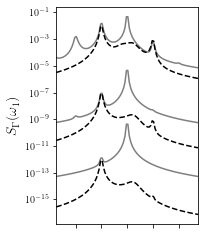

In [17]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(2.54, 4)

start = time.time()

npoints = 100;

wlist2_0 = np.linspace(-5.5, 5.5, npoints)

N = 4
M = 8
Nall = N*M
a = tensor(destroy(N),qeye(M))
b = tensor(qeye(N),destroy(M))
ident = tensor(qeye(N),qeye(M))
nn = a.dag()*a
c_ops = [np.sqrt(kappa_a) * a, np.sqrt(kappa_b) * b]
sS_d = np.empty(shape=(npoints))

g0S = [.1,.3,1]
mlt = [1e-8, 1e-4, 1]

ii = 0
for g0 in g0S:
    Hamiltonian = detuning*a.dag()*a + wb*b.dag()*b - g0*a.dag()*a*(b + b.dag()) + 1j * Omega * (a.dag() - a)
    rho_ss = steadystate(Hamiltonian, c_ops, method = 'direct')
    lv = liouvillian(Hamiltonian, c_ops)
    jj = 0
    for wd1 in wlist2_0: 
        sS_d[jj] = calc_S_Gamma(rho_ss, lv, kappa_d, wd1, a, Nall)
        jj = jj+1
    ax.plot(wlist2_0, mlt[ii]*sS_d, color='tab:gray', linestyle='-', lw=1.5, label='_nolegend_')

    alpha = expect(a, rho_ss)
    Hamiltonian = detuning*a.dag()*a + wb*b.dag()*b - g0*(alpha*a.dag()+np.conj(alpha)*a)*(b.dag()+b)
    rho_ss = steadystate(Hamiltonian, c_ops, method = 'direct')
    lv = liouvillian(Hamiltonian, c_ops)
    jj = 0
    for wd1 in wlist2_0: 
        sS_d[jj] = calc_S_Gamma(rho_ss, lv, kappa_d, wd1, a, Nall)
        jj = jj+1
    ax.plot(wlist2_0, mlt[ii]*sS_d, color='k', linestyle='--', lw=1.5, label='_nolegend_')
    ii = ii+1

end = time.time()
print(end-start)

ax.legend()
# ax.set_xlabel(r'$\omega$', fontsize=fts)
ax.set_ylabel(r'$S_\Gamma(\omega_1)$', fontsize=fts)
ax.set_xticks([-2*wb,-wb,0,wb,2*wb])
# ax.set_xticklabels([r'$-2\omega_b$',r'$-\omega_b$',r'$0$',r'$\omega_b$',r'$2\omega_b$'], fontsize=fts2)
ax.set_xticklabels([], fontsize=fts2)

plt.xlim(-5.5,5.5)
# plt.ylim(1,1e8)
# ax.fill_between(wlist2_0, 1, 1e8*sS_d, color='k', alpha=0.1)
ax.set_yscale('log')
# ax.set_yticks([1, 1e5])
# ax.set_yticklabels([r'$1$',r'$10^5$'], fontsize=fts2)
ax.get_legend().remove()

# f = mpl.ticker.ScalarFormatter(useOffset=False, useMathText=True)
# g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.10e' % x))
# plt.gca().yaxis.set_major_formatter(mpl.ticker.FuncFormatter(g))
# plt.gcf().subplots_adjust(bottom=0.1, left=0.2)

fig.savefig('Spect_4c_tst.svg', dpi=2000)
fig.savefig('Spect_4c_tst.png', dpi=2000)

print(expect(a.dag()*a.dag()*a*a, rho_ss)/expect(a.dag()*a, rho_ss)**2)

plt.show()


### correlations map

162.52911472320557
9.177117860070549


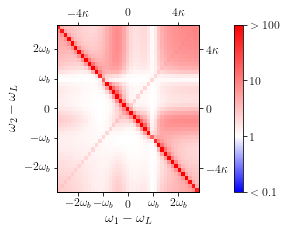

In [5]:

npoints = 41

N = 4
M = 8
Nall = N*M

a = tensor(destroy(N),qeye(M))
b = tensor(qeye(N),destroy(M))
ident = tensor(qeye(N),qeye(M))
nn = a.dag()*a

suffix = "_coh3_OM_both_test";
wd1S = np.linspace(-5.5, 5.5, npoints)
dx = (wd1S[-1]-wd1S[0])/npoints
spectrumD1 = np.empty(npoints)
correlations = np.empty(shape=(npoints,npoints,6))

# ################################

redo = 1

if redo == 1:
    start = time.time()
    ii = 0
    c_ops = [np.sqrt(kappa_a) * a, np.sqrt(kappa_b) * b]

    Hoptomech = detuning*a.dag()*a + wb*b.dag()*b - g0*a.dag()*a*(b + b.dag()) + 1j * Omega * (a.dag() - a)
    rho_ss = steadystate(Hoptomech, c_ops, method = 'direct')
    alpha = expect(a, rho_ss)

    Hoptomech = detuning*a.dag()*a + wb*b.dag()*b - g0*(alpha*a.dag()+np.conj(alpha)*a)*(b.dag()+b)
    rho_ss = steadystate(Hoptomech, c_ops, method = 'direct')
    lv = liouvillian(Hoptomech, c_ops)

#     Hamiltonian = detuning*a.dag()*a + wb*b.dag()*b - g0*a.dag()*a*(b + b.dag()) + 1j * Omega * (a.dag() - a)

#     rho_ss = steadystate(Hamiltonian, c_ops, method = 'direct')
#     alpha = expect(a, rho_ss)
    
    lv = liouvillian(Hoptomech, c_ops)
    for wd1 in wd1S:
        jj = 0
        for wd2 in wd1S[0:(ii+1)]:
#             correlations[ii,jj] = [wd1, wd2, 0., \
#              calc_g_Gamma12(rho_ss, lv, kappa_d, wd1, wd2, a-alpha*ident, Nall), 1, N]
            correlations[jj,ii] = [wd2, wd1, 0., \
             calc_g_Gamma12(rho_ss, lv, kappa_d, wd1, wd2, a, Nall), 1, N]
#             correlations[jj,ii] = correlations[ii,jj]
            correlations[ii,jj] = correlations[jj,ii]
            jj += 1
        ii += 1
    end = time.time()
    print(end-start)
    print(expect(a.dag()*a.dag()*a*a, rho_ss)/(expect(a.dag()*a, rho_ss)**2))

    with open("colored_g2_test1smg0_N=" + str(N) + "_npoints=" + str(npoints) + suffix + ".txt", "wb") as fp: 
        pickle.dump(correlations, fp)

with open("colored_g2_test1smg0_N=" + str(N) + "_npoints=" + str(npoints) + suffix + ".txt", "rb") as fp:
    correlations2 = pickle.load(fp)

toPlot = np.zeros(shape=(npoints,npoints,3))
# toPlot = correlations2[:, :, 0:3]
toPlot = correlations2[:, :, [0,1,3]]
xs = correlations2[:, :, 0].flatten()
ys = correlations2[:, :, 1].flatten()

fig, ax = plt.subplots(1, 1)
# fig.set_size_inches(1.56*3.2,1.07*3)
fig.set_size_inches(1.56*3.2,4)

addpoints = 0
wd1Sext = np.append(np.linspace(-5.5, 5.5, npoints), np.linspace(5.5+dx, 5.5+dx*addpoints, addpoints))
xGrid, yGrid = np.meshgrid(wd1S, wd1Sext)
xGride = np.append(xGrid, np.transpose([np.ones(npoints+addpoints)*(xGrid[0,-1]+dx)]), axis=1)
xGridee = np.append(xGride, [xGride[-1]], axis=0)-.5*dx
yGride = np.append(yGrid, np.transpose([yGrid[:,0]]), axis=1)
yGridee = np.append(yGride, [np.ones(npoints+1+0*addpoints)*(yGrid[-1,0]+dx)], axis=0)-.5*dx

zGrid = toPlot[:,:,2]
zMax = np.float64(100)
zMin = np.float64(0.1)
# zMax = np.float64(100)
# zMin = np.float64(0.01)
# zMax = np.float64(2)
# zMin = np.float64(0.5)
dm = np.log10(zMax/zMin)
blue_red1 = LinearSegmentedColormap.from_list('mycmap', [
    (0, 'blue'),
#     (np.log10(1/zMin)/dm, 'blue'),
    (np.log10(1/zMin)/dm, 'white'),
    (1.0000, 'red')])

toPlot2 = np.ones(shape=(npoints+addpoints,npoints,3))
for i in range(npoints):
    for j in range(npoints):
        if i>=j:
            toPlot2[i+1*addpoints,j,2] = toPlot[i,j,2]
        else:
            toPlot2[i,j+0*addpoints,2] = toPlot[i,j,2]
im = ax.pcolormesh(xGridee, yGridee, np.log10(toPlot2[:,:,2]), vmin=np.log10(zMin), vmax=np.log10(zMax), cmap=blue_red1)
cbar = fig.colorbar(im, ax=ax, pad=.17)
# cbar.set_ticks([-1, 0, 1] + list(range(0,math.floor(zMax.astype(int))+1,5))) 
# cbar.set_ticks([-1, 0, 1]) 
cbar.set_ticks([np.log10(zMin), 0, 1, np.log10(zMax)]) 
cbar.ax.set_yticklabels([r'$<0.1$', r'$1$', r'$10$', r'$>100$'], fontsize=fts2)
# cbar.ax.set_yticklabels(['0.01', '1', '>100'])
# cbar.ax.set_yticklabels(['0.1', '1', '>10'])
# cbar.ax.set_yticklabels([zMin, '1', '>2'])

ax.set_xticks([-4+0*addpoints*dx,-2+0*addpoints*dx,0+0*addpoints*dx,2+0*addpoints*dx,4+0*addpoints*dx])
ax.set_yticks([-4+addpoints*dx,-2+addpoints*dx,0+addpoints*dx,2+addpoints*dx,4+addpoints*dx])

ax.set_xticklabels([r'$-2\omega_b$',r'$-\omega_b$',r'$0$',r'$\omega_b$',r'$2\omega_b$'], fontsize=fts2)
ax.set_yticklabels([r'$-2\omega_b$',r'$-\omega_b$',r'$0$',r'$\omega_b$',r'$2\omega_b$'], fontsize=fts2)

ax.set_xlabel(r'$\omega_1-\omega_L$', fontsize=fts)
ax.set_ylabel(r'$\omega_2-\omega_L$', fontsize=fts)

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks([-4,0,4])
ax2.set_xticklabels([r'$-4\kappa$',r'$0$',r'$4\kappa$'], fontsize=fts2)

ay2 = ax.twinx()
ay2.set_ylim(ax.get_xlim())
ay2.set_yticks([-4,0,4])
ay2.set_yticklabels([r'$-4\kappa$',r'$0$',r'$4\kappa$'], fontsize=fts2)

plt.xlim(xGridee[0,0], xGridee[0,-1])
plt.ylim(yGridee[0,0], yGridee[-1,0])

plt.gcf().subplots_adjust(bottom=0.3, left=0.27, right=.85)

fig.savefig('2PS_4c_test.svg', dpi=1000)
fig.savefig('2PS_4c_test.png', dpi=1000)

plt.show()

# Figure 5

In [43]:
kappa_a = 1.
kappa_b = .1
wb = 2
Omega = .1
g0 = .08
delta_g = g0**2/wb
# fn = Omega*(g0/wb)**n/n!

detuning = delta_g

N = 4
M = 8
Nall = N*M

suffix = "_g0Gamma";
kappa_d = .05 * kappa_a


## Figure 5a

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(3, 2.6)

start = time.time()

npoints = 100

sS = np.zeros(npoints)	

a = tensor(destroy(N),qeye(M))
b = tensor(qeye(N),destroy(M))
c_ops = [ np.sqrt(kappa_a) * a, np.sqrt(kappa_b) * b]

correlationsSaS = np.empty(shape=(npoints))
correlationsLeapfrog0K = np.empty(shape=(npoints))
correlations0 = np.empty(shape=(npoints))

ii = 0
g0S = 10**np.linspace(-2, np.log10(1.5), npoints)
for g0 in g0S:
    delta_g = g0**2/wb
    detuning = delta_g
    c_ops = [np.sqrt(kappa_a) * a, np.sqrt(kappa_b) * b]
    HOM = detuning*a.dag()*a + wb*b.dag()*b - g0*a.dag()*a*(b.dag()+b) + 1.j*Omega*(a.dag() - a)
    rho_ss = steadystate(HOM, c_ops, method = 'direct')
    lv = liouvillian(HOM, c_ops)
    wd1 = -2 
    wd2 = -wd1
    correlationsSaS[ii] = calc_g_Gamma12(rho_ss, lv, kappa_d, wd1, wd2, a, Nall)
    wd1 = -1 
    wd2 = -wd1
    correlationsLeapfrog0K[ii] = calc_g_Gamma12(rho_ss, lv, kappa_d, wd1, wd2, a, Nall)
    correlations0[ii] = expect(a.dag()*a.dag()*a*a, rho_ss)/expect(a.dag()*a, rho_ss)**2 
    ii = ii+1

ax.loglog(g0S, correlationsSaS, color='tab:orange', linestyle='-', lw=2., label='')
ax.loglog(g0S, correlationsLeapfrog0K, color='tab:green', linestyle='-', lw=2., label='')
# ax.loglog(g0S, correlationsaSaS, color='darkseagreen', linestyle='--', lw=1., label='')
ax.loglog(g0S, correlations0, color='tab:blue', linestyle='-', lw=2., label='')

ii = 0
nbth = .1
c_ops = [ np.sqrt(kappa_a) * a, np.sqrt(kappa_b * (1+nbth)) * b, np.sqrt(kappa_b * nbth) * b.dag()]
correlationsLeapfrogHighK = np.empty(shape=(npoints))

for g0 in g0S:
    delta_g = g0**2/wb
    detuning = delta_g
    HOM = detuning*a.dag()*a + wb*b.dag()*b - g0*a.dag()*a*(b.dag()+b) + 1.j*Omega*(a.dag() - a)
    rho_ss = steadystate(HOM, c_ops, method = 'direct')
    lv = liouvillian(HOM, c_ops)
    wd1 = -2 
    wd2 = -wd1
    correlationsSaS[ii] = calc_g_Gamma12(rho_ss, lv, kappa_d, wd1, wd2, a, Nall)
    wd1 = -1 
    wd2 = -wd1
    correlationsLeapfrogHighK[ii] = calc_g_Gamma12(rho_ss, lv, kappa_d, wd1, wd2, a, Nall)
    correlations0[ii] = expect(a.dag()*a.dag()*a*a, rho_ss)/expect(a.dag()*a, rho_ss)**2 
    ii = ii+1

ax.loglog(g0S, correlationsSaS, color='tab:orange', linestyle='--', lw=2., label='')
ax.loglog(g0S, correlationsLeapfrogHighK, color='tab:green', linestyle='--', lw=2., label='')
ax.loglog(g0S, correlations0, color='tab:blue', linestyle='--', lw=2., label='')

end = time.time()
print(end-start)

ax.set_xlabel(r'$g_0/\kappa$', fontsize=fts)
ax.set_ylabel(r'$g_{\Gamma}^{(2)}(\omega_1,\omega_2),~g^{(2)}(0)$', fontsize=fts)
xticks = np.array([0.01,0.1,1])
ax.set_xlim(.009,1.5)
ax.set_xticks(xticks)
ax.set_xticklabels([r'$10^{-2}$',r'$10^{-1}$',r'$1$'], fontsize=fts2)
yticks = np.array([1, 10])
ax.set_yticks(yticks)
ax.set_yticklabels([r'$1$',r'$10$'], fontsize=fts2)

ax2 = ax.twiny()
g0S2 = 10**np.linspace(np.log10(1.5), np.log10(2.), npoints)
ax2.loglog(g0S2, correlationsSaS, 'r-', lw=1., label='', alpha=0)
x2ticks = np.array([10**-4,10**-2,1])
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(np.sqrt(x2ticks*wb))
ax2.set_xticklabels([r'$10^{-4}$',r'$10^{-2}$',r'$1$'], fontsize=fts2)
ax2.set_xlabel(r"$\Delta_g/\kappa$", fontsize=fts)

plt.axhline(y=1, color='k', linestyle='--', label='', linewidth=1)
plt.axvline(x=.5, color='k', linestyle='--', label='', linewidth=1)

fig.savefig('Fig5a.png', dpi=1000)
fig.savefig('Fig5a.svg', dpi=1000)


plt.show()


## Figure 5b

In [44]:
kappa_a = 1.
kappa_b = .1
wb = 2
Omega = .1
g0 = .08
delta_g = g0**2/wb
# fn = Omega*(g0/wb)**n/n!

detuning = delta_g

N = 10
M = 8
Nall = N*M

suffix = "_g0Gamma";
kappa_d = .05 * kappa_a


9829.447872638702


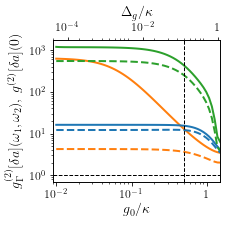

In [48]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(3, 2.6)

start = time.time()

npoints = 60

sS = np.zeros(npoints)	

a = tensor(destroy(N),qeye(M))
b = tensor(qeye(N),destroy(M))
ident = tensor(qeye(N),qeye(M))
c_ops = [ np.sqrt(kappa_a) * a, np.sqrt(kappa_b) * b]

correlationsSaS = np.empty(shape=(npoints))
correlationsLeapfrog0K = np.empty(shape=(npoints))
correlations0 = np.empty(shape=(npoints))

ii = 0
g0S = 10**np.linspace(-2, np.log10(1.5), npoints)
for g0 in g0S:
    delta_g = g0**2/wb
    detuning = delta_g
    c_ops = [np.sqrt(kappa_a) * a, np.sqrt(kappa_b) * b]
    HOM = detuning*a.dag()*a + wb*b.dag()*b - g0*a.dag()*a*(b.dag()+b) + 1.j*Omega*(a.dag() - a)
    rho_ss = steadystate(HOM, c_ops, method = 'direct')
    alpha = expect(a, rho_ss)
    
    lv = liouvillian(HOM, c_ops)
    wd1 = -2 
    wd2 = -wd1
    correlationsSaS[ii] = calc_g_Gamma12(rho_ss, lv, kappa_d, wd1, wd2, a-alpha*ident, Nall)
    wd1 = -1 
    wd2 = -wd1
    correlationsLeapfrog0K[ii] = calc_g_Gamma12(rho_ss, lv, kappa_d, wd1, wd2, a-alpha*ident, Nall)
    correlations0[ii] = expect((a.dag()-np.conj(alpha)*ident)*(a.dag()-np.conj(alpha)*ident)*(a-alpha*ident)*(a-alpha*ident), rho_ss)/expect((a.dag()-np.conj(alpha)*ident)*(a-alpha*ident), rho_ss)**2 
    ii = ii+1

ax.loglog(g0S, correlationsSaS, color='tab:orange', linestyle='-', lw=2., label='')
ax.loglog(g0S, correlationsLeapfrog0K, color='tab:green', linestyle='-', lw=2., label='')
# ax.loglog(g0S, correlationsaSaS, color='darkseagreen', linestyle='--', lw=1., label='')
ax.loglog(g0S, correlations0, color='tab:blue', linestyle='-', lw=2., label='')

ii = 0
nbth = .1
c_ops = [ np.sqrt(kappa_a) * a, np.sqrt(kappa_b * (1+nbth)) * b, np.sqrt(kappa_b * nbth) * b.dag()]
correlationsLeapfrogHighK = np.empty(shape=(npoints))

for g0 in g0S:
    delta_g = g0**2/wb
    detuning = delta_g
    HOM = detuning*a.dag()*a + wb*b.dag()*b - g0*a.dag()*a*(b.dag()+b) + 1.j*Omega*(a.dag() - a)
    rho_ss = steadystate(HOM, c_ops, method = 'direct')
    alpha = expect(a, rho_ss)
    
    lv = liouvillian(HOM, c_ops)
    wd1 = -2 
    wd2 = -wd1
    correlationsSaS[ii] = calc_g_Gamma12(rho_ss, lv, kappa_d, wd1, wd2, a-alpha*ident, Nall)
    wd1 = -1 
    wd2 = -wd1
    correlationsLeapfrogHighK[ii] = calc_g_Gamma12(rho_ss, lv, kappa_d, wd1, wd2, a-alpha*ident, Nall)
    correlations0[ii] = expect((a.dag()-np.conj(alpha)*ident)*(a.dag()-np.conj(alpha)*ident)*(a-alpha*ident)*(a-alpha*ident), rho_ss)/expect((a.dag()-np.conj(alpha)*ident)*(a-alpha*ident), rho_ss)**2 
    ii = ii+1

ax.loglog(g0S, correlationsSaS, color='tab:orange', linestyle='--', lw=2., label='')
ax.loglog(g0S, correlationsLeapfrogHighK, color='tab:green', linestyle='--', lw=2., label='')
ax.loglog(g0S, correlations0, color='tab:blue', linestyle='--', lw=2., label='')

end = time.time()
print(end-start)

ax.set_xlabel(r'$g_0/\kappa$', fontsize=fts)
ax.set_ylabel(r'$g_{\Gamma}^{(2)}[\delta a](\omega_1,\omega_2),~g^{(2)}[\delta a](0)$', fontsize=fts)
xticks = np.array([0.01,0.1,1])
ax.set_xlim(.009,1.5)
ax.set_xticks(xticks)
ax.set_xticklabels([r'$10^{-2}$',r'$10^{-1}$',r'$1$'], fontsize=fts2)
yticks = np.array([1, 1e2, 1e4])
ax.set_yticks(yticks)
ax.set_yticklabels([r'$1$',r'$10^2$',r'$10^4$'], fontsize=fts2)

ax2 = ax.twiny()
g0S2 = 10**np.linspace(np.log10(1.5), np.log10(2.), npoints)
ax2.loglog(g0S2, correlationsSaS, 'r-', lw=1., label='', alpha=0)
x2ticks = np.array([10**-4,10**-2,1])
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(np.sqrt(x2ticks*wb))
ax2.set_xticklabels([r'$10^{-4}$',r'$10^{-2}$',r'$1$'], fontsize=fts2)
ax2.set_xlabel(r"$\Delta_g/\kappa$", fontsize=fts)

plt.axhline(y=1, color='k', linestyle='--', label='', linewidth=1)
plt.axvline(x=.5, color='k', linestyle='--', label='', linewidth=1)

fig.savefig('Fig5b_alpha.png', dpi=1000)
fig.savefig('Fig5b_alpha.svg', dpi=1000)


plt.show()


# Figure 5 - test

In [3]:
kappa_a = 1.
kappa_b = .1
wb = 2
Omega = .1
g0 = .08
delta_g = g0**2/wb
# fn = Omega*(g0/wb)**n/n!

detuning = delta_g

N = 4
M = 8
Nall = N*M

suffix = "_g0Gamma";
kappa_d = .05 * kappa_a


### color blind

4.934962034225464


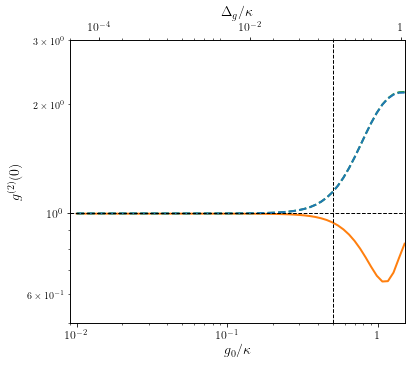

In [40]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(3, 2.6)
fig.set_size_inches(2*3, 2*2.6)

start = time.time()

npoints = 60

sS = np.zeros(npoints)	

N = 4
M = 8
Nall = N*M

a = tensor(destroy(N),qeye(M))
b = tensor(qeye(N),destroy(M))
ident = tensor(qeye(N),qeye(M))
c_ops = [ np.sqrt(kappa_a) * a, np.sqrt(kappa_b) * b]

correlations0 = np.empty(shape=(npoints))
correlations1 = np.empty(shape=(npoints))
correlations2 = np.empty(shape=(npoints))

ii = 0
c_ops = [np.sqrt(kappa_a) * a, np.sqrt(kappa_b) * b]
g0S = 10**np.linspace(-2, np.log10(1.5), npoints)
for g0 in g0S:
    delta_g = g0**2/wb
    detuning = delta_g
    
    HOM = detuning*a.dag()*a + wb*b.dag()*b - g0*a.dag()*a*(b.dag()+b) + 1.j*Omega*(a.dag() - a)
    rho_ss = steadystate(HOM, c_ops, method = 'direct')
    alphaExp = expect(a, rho_ss)
    alpha = Omega/(kappa_a/2+1j*delta_g)
#     print(g0, alpha, alphaExp)
    correlations0[ii] = expect(a.dag()*a.dag()*a*a, rho_ss)/expect(a.dag()*a, rho_ss)**2 
    
    HOM = detuning*a.dag()*a + wb*b.dag()*b - g0*(alpha*a.dag()+np.conj(alpha)*a)*(b.dag()+b)
    rho_ss = steadystate(HOM, c_ops, method = 'direct')        
    correlations1[ii] = expect( \
        (a.dag()+np.conj(alpha)*ident)*(a.dag()+np.conj(alpha)*ident)* \
        (a+alpha*ident)*(a+alpha*ident), rho_ss)/ \
        expect((a.dag()+np.conj(alpha)*ident)*(a+alpha*ident), rho_ss)**2 
    
    alpha = alphaExp
    HOM = detuning*a.dag()*a + wb*b.dag()*b - g0*(alpha*a.dag()+np.conj(alpha)*a)*(b.dag()+b)
    rho_ss = steadystate(HOM, c_ops, method = 'direct')        
    correlations2[ii] = expect( \
        (a.dag()+np.conj(alpha)*ident)*(a.dag()+np.conj(alpha)*ident)* \
        (a+alpha*ident)*(a+alpha*ident), rho_ss)/ \
        expect((a.dag()+np.conj(alpha)*ident)*(a+alpha*ident), rho_ss)**2 
    ii = ii+1

ax.loglog(g0S, correlations0, color='tab:orange', linestyle='-', lw=2., label='nonlin.')
ax.loglog(g0S, correlations1, color='tab:green', linestyle='--', lw=2., label=r'$\alpha=\Omega/(\kappa/2+i\Delta_g)$')
ax.loglog(g0S, correlations2, color='tab:blue', linestyle='--', lw=2., label=r'$\alpha=\mean{a}_{\text{OM}}$')

end = time.time()
print(end-start)

ax.set_xlabel(r'$g_0/\kappa$', fontsize=fts)
ax.set_ylabel(r'$g^{(2)}(0)$', fontsize=fts)
xticks = np.array([0.01,0.1,1])
ax.set_xlim(.009,1.5)
ax.set_xticks(xticks)
ax.set_xticklabels([r'$10^{-2}$',r'$10^{-1}$',r'$1$'], fontsize=fts2)
yticks = np.array([1, 10])
ax.set_yticks(yticks)
ax.set_yticklabels([r'$1$',r'$1.2$'], fontsize=fts2)
ax.set_ylim(.5,3)

ax2 = ax.twiny()
# g0S2 = 10**np.linspace(np.log10(1.5), np.log10(2.), npoints)
ax2.loglog(g0S, correlations0, 'r-', lw=1., label='', alpha=0)
x2ticks = np.array([10**-4,10**-2,1])
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(np.sqrt(x2ticks*wb))
ax2.set_xticklabels([r'$10^{-4}$',r'$10^{-2}$',r'$1$'], fontsize=fts2)
ax2.set_xlabel(r"$\Delta_g/\kappa$", fontsize=fts)

plt.axhline(y=1, color='k', linestyle='--', label='', linewidth=1)
plt.axvline(x=.5, color='k', linestyle='--', label='', linewidth=1)

fig.savefig('Fig5a_RE_blind.png', dpi=1000)
fig.savefig('Fig5a_RE_blind.svg', dpi=1000)


plt.show()


246.08272886276245


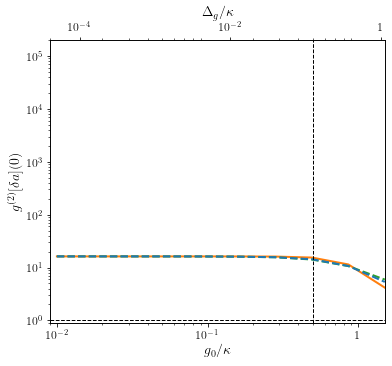

In [38]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(3, 2.6)
fig.set_size_inches(2*3, 2*2.6)

start = time.time()

npoints = 10

sS = np.zeros(npoints)	

N = 10
M = 10
Nall = N*M

a = tensor(destroy(N),qeye(M))
b = tensor(qeye(N),destroy(M))
ident = tensor(qeye(N),qeye(M))
c_ops = [ np.sqrt(kappa_a) * a, np.sqrt(kappa_b) * b]

correlations0 = np.empty(shape=(npoints))
correlations1 = np.empty(shape=(npoints))
correlations2 = np.empty(shape=(npoints))

ii = 0
c_ops = [np.sqrt(kappa_a) * a, np.sqrt(kappa_b) * b]
g0S = 10**np.linspace(-2, np.log10(1.5), npoints)
for g0 in g0S:
    delta_g = g0**2/wb
    detuning = delta_g
    
    HOM = detuning*a.dag()*a + wb*b.dag()*b - g0*a.dag()*a*(b.dag()+b) + 1.j*Omega*(a.dag() - a)
    rho_ss = steadystate(HOM, c_ops, method = 'direct')
    alphaExp = expect(a, rho_ss)
    alpha = Omega/(kappa_a/2+1j*delta_g)
#     print(g0, alpha, alphaExp)
#     correlations0[ii] = expect(a.dag()*a.dag()*a*a, rho_ss)/expect(a.dag()*a, rho_ss)**2 
    correlations0[ii] = expect( \
        (a.dag()-np.conj(alphaExp)*ident)*(a.dag()-np.conj(alphaExp)*ident)* \
        (a-alphaExp*ident)*(a-alphaExp*ident), rho_ss)/ \
        (expect((a.dag()-np.conj(alphaExp)*ident)*(a-alphaExp*ident), rho_ss)**2) 
    
    HOM = detuning*a.dag()*a + wb*b.dag()*b - g0*(alpha*a.dag()+np.conj(alpha)*a)*(b.dag()+b)
    rho_ss = steadystate(HOM, c_ops, method = 'direct')        
    correlations1[ii] = expect(a.dag()*a.dag()*a*a, rho_ss)/expect(a.dag()*a, rho_ss)**2 
#     correlations1[ii] = expect( \
#         (a.dag()+np.conj(alpha)*ident)*(a.dag()+np.conj(alpha)*ident)* \
#         (a+alpha*ident)*(a+alpha*ident), rho_ss)/ \
#         expect((a.dag()+np.conj(alpha)*ident)*(a+alpha*ident), rho_ss)**2 
    
    alpha = alphaExp
    HOM = detuning*a.dag()*a + wb*b.dag()*b - g0*(alpha*a.dag()+np.conj(alpha)*a)*(b.dag()+b)
    rho_ss = steadystate(HOM, c_ops, method = 'direct')        
    correlations2[ii] = expect(a.dag()*a.dag()*a*a, rho_ss)/expect(a.dag()*a, rho_ss)**2 
#     correlations2[ii] = expect( \
#         (a.dag()+np.conj(alpha)*ident)*(a.dag()+np.conj(alpha)*ident)* \
#         (a+alpha*ident)*(a+alpha*ident), rho_ss)/ \
#         expect((a.dag()+np.conj(alpha)*ident)*(a+alpha*ident), rho_ss)**2 
    ii = ii+1

ax.loglog(g0S, correlations0, color='tab:orange', linestyle='-', lw=2., label='nonlin.')
ax.loglog(g0S, correlations1, color='tab:green', linestyle='--', lw=2., label=r'$\alpha=\Omega/(\kappa/2+i\Delta_g)$')
ax.loglog(g0S, correlations2, color='tab:blue', linestyle='--', lw=2., label=r'$\alpha=\mean{a}_{\text{OM}}$')

end = time.time()
print(end-start)

ax.set_xlabel(r'$g_0/\kappa$', fontsize=fts)
ax.set_ylabel(r'$g^{(2)}[\delta a](0)$', fontsize=fts)
xticks = np.array([0.01,0.1,1])
ax.set_xlim(.009,1.5)
ax.set_xticks(xticks)
ax.set_xticklabels([r'$10^{-2}$',r'$10^{-1}$',r'$1$'], fontsize=fts2)
yticks = np.array([1, 10])
ax.set_yticks(yticks)
ax.set_yticklabels([r'$1$',r'$1.2$'], fontsize=fts2)
ax.set_ylim(.9,2e5)

ax2 = ax.twiny()
# g0S2 = 10**np.linspace(np.log10(1.5), np.log10(2.), npoints)
ax2.loglog(g0S, correlations0, 'r-', lw=1., label='', alpha=0)
x2ticks = np.array([10**-4,10**-2,1])
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(np.sqrt(x2ticks*wb))
ax2.set_xticklabels([r'$10^{-4}$',r'$10^{-2}$',r'$1$'], fontsize=fts2)
ax2.set_xlabel(r"$\Delta_g/\kappa$", fontsize=fts)

plt.axhline(y=1, color='k', linestyle='--', label='', linewidth=1)
plt.axvline(x=.5, color='k', linestyle='--', label='', linewidth=1)

fig.savefig('Fig5a_RE_blind_fluct.png', dpi=1000)
fig.savefig('Fig5a_RE_blind_fluct.svg', dpi=1000)


plt.show()


### Stokes -- anti-Stokes

48.03897047042847


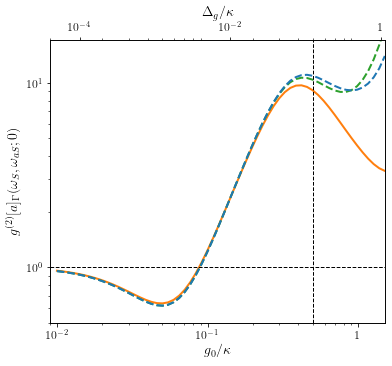

In [54]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(3, 2.6)
fig.set_size_inches(2*3, 2*2.6)

start = time.time()

npoints = 60

sS = np.zeros(npoints)	

N = 4
M = 8
Nall = N*M

a = tensor(destroy(N),qeye(M))
b = tensor(qeye(N),destroy(M))
ident = tensor(qeye(N),qeye(M))
c_ops = [ np.sqrt(kappa_a) * a, np.sqrt(kappa_b) * b]

correlations0 = np.empty(shape=(npoints))
correlations1 = np.empty(shape=(npoints))
correlations2 = np.empty(shape=(npoints))

wd1 = -2 
wd2 = -wd1

ii = 0
c_ops = [np.sqrt(kappa_a) * a, np.sqrt(kappa_b) * b]
g0S = 10**np.linspace(-2, np.log10(1.5), npoints)
for g0 in g0S:
    delta_g = g0**2/wb
    detuning = delta_g
    
    HOM = detuning*a.dag()*a + wb*b.dag()*b - g0*a.dag()*a*(b.dag()+b) + 1.j*Omega*(a.dag() - a)
    rho_ss = steadystate(HOM, c_ops, method = 'direct')
    alphaExp = expect(a, rho_ss)
    alpha = Omega/(kappa_a/2+1j*delta_g)
    lv = liouvillian(HOM, c_ops)
    correlations0[ii] = calc_g_Gamma12(rho_ss, lv, kappa_d, wd1, wd2, a, Nall)
#     correlations0[ii] = expect(a.dag()*a.dag()*a*a, rho_ss)/expect(a.dag()*a, rho_ss)**2 

#     print(g0, alpha, alphaExp)

    HOM = detuning*a.dag()*a + wb*b.dag()*b - g0*(alpha*a.dag()+np.conj(alpha)*a)*(b.dag()+b)
    rho_ss = steadystate(HOM, c_ops, method = 'direct')        
    lv = liouvillian(HOM, c_ops)
    correlations1[ii] = calc_g_Gamma12(rho_ss, lv, kappa_d, wd1, wd2, a+alpha*ident, Nall)
#     correlations1[ii] = expect( \
#         (a.dag()+np.conj(alpha)*ident)*(a.dag()+np.conj(alpha)*ident)* \
#         (a+alpha*ident)*(a+alpha*ident), rho_ss)/ \
#         expect((a.dag()+np.conj(alpha)*ident)*(a+alpha*ident), rho_ss)**2 
    
    alpha = alphaExp
    HOM = detuning*a.dag()*a + wb*b.dag()*b - g0*(alpha*a.dag()+np.conj(alpha)*a)*(b.dag()+b)
    rho_ss = steadystate(HOM, c_ops, method = 'direct')        
    lv = liouvillian(HOM, c_ops)
    correlations2[ii] = calc_g_Gamma12(rho_ss, lv, kappa_d, wd1, wd2, a+alpha*ident, Nall)
#     correlations2[ii] = expect( \
#         (a.dag()+np.conj(alpha)*ident)*(a.dag()+np.conj(alpha)*ident)* \
#         (a+alpha*ident)*(a+alpha*ident), rho_ss)/ \
#         expect((a.dag()+np.conj(alpha)*ident)*(a+alpha*ident), rho_ss)**2 
    ii = ii+1

ax.loglog(g0S, correlations0, color='tab:orange', linestyle='-', lw=2., label='nonlin.')
ax.loglog(g0S, correlations1, color='tab:green', linestyle='--', lw=2., label=r'$\alpha=\Omega/(\kappa/2+i\Delta_g)$')
ax.loglog(g0S, correlations2, color='tab:blue', linestyle='--', lw=2., label=r'$\alpha=\mean{a}_{\text{OM}}$')

end = time.time()
print(end-start)

ax.set_xlabel(r'$g_0/\kappa$', fontsize=fts)
ax.set_ylabel(r'$g^{(2)}[a]_\Gamma(\omega_S,\omega_{aS};0)$', fontsize=fts)
xticks = np.array([0.01,0.1,1])
ax.set_xlim(.009,1.5)
ax.set_xticks(xticks)
ax.set_xticklabels([r'$10^{-2}$',r'$10^{-1}$',r'$1$'], fontsize=fts2)
yticks = np.array([1, 10])
ax.set_yticks(yticks)
ax.set_yticklabels([r'$1$',r'$1.2$'], fontsize=fts2)
ax.set_ylim(.5,17)

ax2 = ax.twiny()
# g0S2 = 10**np.linspace(np.log10(1.5), np.log10(2.), npoints)
ax2.loglog(g0S, correlations0, 'r-', lw=1., label='', alpha=0)
x2ticks = np.array([10**-4,10**-2,1])
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(np.sqrt(x2ticks*wb))
ax2.set_xticklabels([r'$10^{-4}$',r'$10^{-2}$',r'$1$'], fontsize=fts2)
ax2.set_xlabel(r"$\Delta_g/\kappa$", fontsize=fts)

plt.axhline(y=1, color='k', linestyle='--', label='', linewidth=1)
plt.axvline(x=.5, color='k', linestyle='--', label='', linewidth=1)

fig.savefig('Fig5a_RE_SaS.png', dpi=1000)
fig.savefig('Fig5a_RE_SaS.svg', dpi=1000)


plt.show()


86.02474427223206


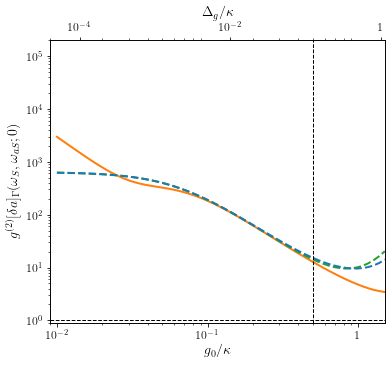

In [53]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(3, 2.6)
fig.set_size_inches(2*3, 2*2.6)

start = time.time()

npoints = 60

sS = np.zeros(npoints)	

N = 4
M = 10
Nall = N*M

a = tensor(destroy(N),qeye(M))
b = tensor(qeye(N),destroy(M))
ident = tensor(qeye(N),qeye(M))
c_ops = [ np.sqrt(kappa_a) * a, np.sqrt(kappa_b) * b]

correlations0 = np.empty(shape=(npoints))
correlations1 = np.empty(shape=(npoints))
correlations2 = np.empty(shape=(npoints))

wd1 = -2 
wd2 = -wd1

ii = 0
c_ops = [np.sqrt(kappa_a) * a, np.sqrt(kappa_b) * b]
g0S = 10**np.linspace(-2, np.log10(1.5), npoints)
for g0 in g0S:
    delta_g = g0**2/wb
    detuning = delta_g
    
    HOM = detuning*a.dag()*a + wb*b.dag()*b - g0*a.dag()*a*(b.dag()+b) + 1.j*Omega*(a.dag() - a)
    rho_ss = steadystate(HOM, c_ops, method = 'direct')
    alphaExp = expect(a, rho_ss)
    alpha = Omega/(kappa_a/2+1j*delta_g)
    lv = liouvillian(HOM, c_ops)
    correlations0[ii] = calc_g_Gamma12(rho_ss, lv, kappa_d, wd1, wd2, a-alphaExp*ident, Nall)
#     correlations0[ii] = expect( \
#         (a.dag()-np.conj(alphaExp)*ident)*(a.dag()-np.conj(alphaExp)*ident)* \
#         (a-alphaExp*ident)*(a-alphaExp*ident), rho_ss)/ \
#         (expect((a.dag()-np.conj(alphaExp)*ident)*(a-alphaExp*ident), rho_ss)**2) 
    
#     print(g0, alpha, alphaExp)

    HOM = detuning*a.dag()*a + wb*b.dag()*b - g0*(alpha*a.dag()+np.conj(alpha)*a)*(b.dag()+b)
    rho_ss = steadystate(HOM, c_ops, method = 'direct')        
    lv = liouvillian(HOM, c_ops)
    correlations1[ii] = calc_g_Gamma12(rho_ss, lv, kappa_d, wd1, wd2, a, Nall)
#     correlations1[ii] = expect(a.dag()*a.dag()*a*a, rho_ss)/expect(a.dag()*a, rho_ss)**2 
#     correlations1[ii] = expect( \
#         (a.dag()+np.conj(alpha)*ident)*(a.dag()+np.conj(alpha)*ident)* \
#         (a+alpha*ident)*(a+alpha*ident), rho_ss)/ \
#         expect((a.dag()+np.conj(alpha)*ident)*(a+alpha*ident), rho_ss)**2 
    
    alpha = alphaExp
    HOM = detuning*a.dag()*a + wb*b.dag()*b - g0*(alpha*a.dag()+np.conj(alpha)*a)*(b.dag()+b)
    rho_ss = steadystate(HOM, c_ops, method = 'direct')        
    lv = liouvillian(HOM, c_ops)
    correlations2[ii] = calc_g_Gamma12(rho_ss, lv, kappa_d, wd1, wd2, a, Nall)
#     correlations2[ii] = expect(a.dag()*a.dag()*a*a, rho_ss)/expect(a.dag()*a, rho_ss)**2 
#     correlations2[ii] = expect( \
#         (a.dag()+np.conj(alpha)*ident)*(a.dag()+np.conj(alpha)*ident)* \
#         (a+alpha*ident)*(a+alpha*ident), rho_ss)/ \
#         expect((a.dag()+np.conj(alpha)*ident)*(a+alpha*ident), rho_ss)**2 
    ii = ii+1

ax.loglog(g0S, correlations0, color='tab:orange', linestyle='-', lw=2., label='nonlin.')
ax.loglog(g0S, correlations1, color='tab:green', linestyle='--', lw=2., label=r'$\alpha=\Omega/(\kappa/2+i\Delta_g)$')
ax.loglog(g0S, correlations2, color='tab:blue', linestyle='--', lw=2., label=r'$\alpha=\mean{a}_{\text{OM}}$')

end = time.time()
print(end-start)

ax.set_xlabel(r'$g_0/\kappa$', fontsize=fts)
ax.set_ylabel(r'$g^{(2)}[\delta a]_\Gamma(\omega_S,\omega_{aS};0)$', fontsize=fts)
xticks = np.array([0.01,0.1,1])
ax.set_xlim(.009,1.5)
ax.set_xticks(xticks)
ax.set_xticklabels([r'$10^{-2}$',r'$10^{-1}$',r'$1$'], fontsize=fts2)
yticks = np.array([1, 10])
ax.set_yticks(yticks)
ax.set_yticklabels([r'$1$',r'$1.2$'], fontsize=fts2)
ax.set_ylim(.9,2e5)

ax2 = ax.twiny()
# g0S2 = 10**np.linspace(np.log10(1.5), np.log10(2.), npoints)
ax2.loglog(g0S, correlations0, 'r-', lw=1., label='', alpha=0)
x2ticks = np.array([10**-4,10**-2,1])
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(np.sqrt(x2ticks*wb))
ax2.set_xticklabels([r'$10^{-4}$',r'$10^{-2}$',r'$1$'], fontsize=fts2)
ax2.set_xlabel(r"$\Delta_g/\kappa$", fontsize=fts)

plt.axhline(y=1, color='k', linestyle='--', label='', linewidth=1)
plt.axvline(x=.5, color='k', linestyle='--', label='', linewidth=1)

fig.savefig('Fig5a_RE_SaS_fluct.png', dpi=1000)
fig.savefig('Fig5a_RE_SaS_fluct.svg', dpi=1000)


plt.show()


2920.794582605362


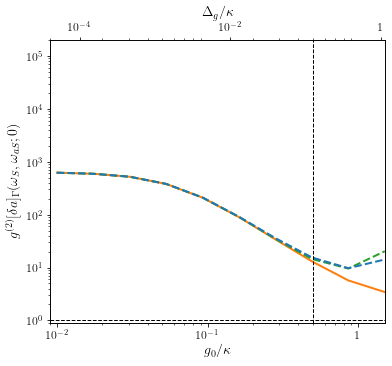

In [41]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(3, 2.6)
fig.set_size_inches(2*3, 2*2.6)

start = time.time()

npoints = 10

sS = np.zeros(npoints)	

N = 10
M = 10
Nall = N*M

a = tensor(destroy(N),qeye(M))
b = tensor(qeye(N),destroy(M))
ident = tensor(qeye(N),qeye(M))
c_ops = [ np.sqrt(kappa_a) * a, np.sqrt(kappa_b) * b]

correlations0 = np.empty(shape=(npoints))
correlations1 = np.empty(shape=(npoints))
correlations2 = np.empty(shape=(npoints))

wd1 = -2 
wd2 = -wd1

ii = 0
c_ops = [np.sqrt(kappa_a) * a, np.sqrt(kappa_b) * b]
g0S = 10**np.linspace(-2, np.log10(1.5), npoints)
for g0 in g0S:
    delta_g = g0**2/wb
    detuning = delta_g
    
    HOM = detuning*a.dag()*a + wb*b.dag()*b - g0*a.dag()*a*(b.dag()+b) + 1.j*Omega*(a.dag() - a)
    rho_ss = steadystate(HOM, c_ops, method = 'direct')
    alphaExp = expect(a, rho_ss)
    alpha = Omega/(kappa_a/2+1j*delta_g)
    lv = liouvillian(HOM, c_ops)
    correlations0[ii] = calc_g_Gamma12(rho_ss, lv, kappa_d, wd1, wd2, a-alphaExp*ident, Nall)
#     correlations0[ii] = expect( \
#         (a.dag()-np.conj(alphaExp)*ident)*(a.dag()-np.conj(alphaExp)*ident)* \
#         (a-alphaExp*ident)*(a-alphaExp*ident), rho_ss)/ \
#         (expect((a.dag()-np.conj(alphaExp)*ident)*(a-alphaExp*ident), rho_ss)**2) 
    
#     print(g0, alpha, alphaExp)

    HOM = detuning*a.dag()*a + wb*b.dag()*b - g0*(alpha*a.dag()+np.conj(alpha)*a)*(b.dag()+b)
    rho_ss = steadystate(HOM, c_ops, method = 'direct')        
    lv = liouvillian(HOM, c_ops)
    correlations1[ii] = calc_g_Gamma12(rho_ss, lv, kappa_d, wd1, wd2, a, Nall)
#     correlations1[ii] = expect(a.dag()*a.dag()*a*a, rho_ss)/expect(a.dag()*a, rho_ss)**2 
#     correlations1[ii] = expect( \
#         (a.dag()+np.conj(alpha)*ident)*(a.dag()+np.conj(alpha)*ident)* \
#         (a+alpha*ident)*(a+alpha*ident), rho_ss)/ \
#         expect((a.dag()+np.conj(alpha)*ident)*(a+alpha*ident), rho_ss)**2 
    
    alpha = alphaExp
    HOM = detuning*a.dag()*a + wb*b.dag()*b - g0*(alpha*a.dag()+np.conj(alpha)*a)*(b.dag()+b)
    rho_ss = steadystate(HOM, c_ops, method = 'direct')        
    lv = liouvillian(HOM, c_ops)
    correlations2[ii] = calc_g_Gamma12(rho_ss, lv, kappa_d, wd1, wd2, a, Nall)
#     correlations2[ii] = expect(a.dag()*a.dag()*a*a, rho_ss)/expect(a.dag()*a, rho_ss)**2 
#     correlations2[ii] = expect( \
#         (a.dag()+np.conj(alpha)*ident)*(a.dag()+np.conj(alpha)*ident)* \
#         (a+alpha*ident)*(a+alpha*ident), rho_ss)/ \
#         expect((a.dag()+np.conj(alpha)*ident)*(a+alpha*ident), rho_ss)**2 
    ii = ii+1

ax.loglog(g0S, correlations0, color='tab:orange', linestyle='-', lw=2., label='nonlin.')
ax.loglog(g0S, correlations1, color='tab:green', linestyle='--', lw=2., label=r'$\alpha=\Omega/(\kappa/2+i\Delta_g)$')
ax.loglog(g0S, correlations2, color='tab:blue', linestyle='--', lw=2., label=r'$\alpha=\mean{a}_{\text{OM}}$')

end = time.time()
print(end-start)

ax.set_xlabel(r'$g_0/\kappa$', fontsize=fts)
ax.set_ylabel(r'$g^{(2)}[\delta a]_\Gamma(\omega_S,\omega_{aS};0)$', fontsize=fts)
xticks = np.array([0.01,0.1,1])
ax.set_xlim(.009,1.5)
ax.set_xticks(xticks)
ax.set_xticklabels([r'$10^{-2}$',r'$10^{-1}$',r'$1$'], fontsize=fts2)
yticks = np.array([1, 10])
ax.set_yticks(yticks)
ax.set_yticklabels([r'$1$',r'$1.2$'], fontsize=fts2)
ax.set_ylim(.9,2e5)

ax2 = ax.twiny()
# g0S2 = 10**np.linspace(np.log10(1.5), np.log10(2.), npoints)
ax2.loglog(g0S, correlations0, 'r-', lw=1., label='', alpha=0)
x2ticks = np.array([10**-4,10**-2,1])
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(np.sqrt(x2ticks*wb))
ax2.set_xticklabels([r'$10^{-4}$',r'$10^{-2}$',r'$1$'], fontsize=fts2)
ax2.set_xlabel(r"$\Delta_g/\kappa$", fontsize=fts)

plt.axhline(y=1, color='k', linestyle='--', label='', linewidth=1)
plt.axvline(x=.5, color='k', linestyle='--', label='', linewidth=1)

fig.savefig('Fig5a_RE_SaS_fluct.png', dpi=1000)
fig.savefig('Fig5a_RE_SaS_fluct.svg', dpi=1000)


plt.show()


### leapfrog

45.09489178657532


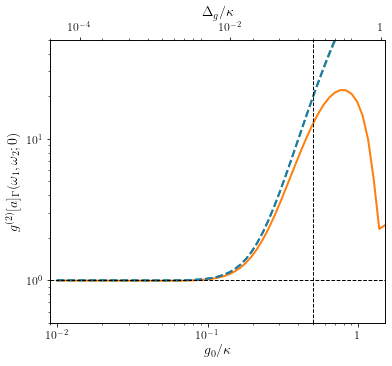

In [55]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(3, 2.6)
fig.set_size_inches(2*3, 2*2.6)

start = time.time()

npoints = 60

sS = np.zeros(npoints)	

N = 4
M = 8
Nall = N*M

a = tensor(destroy(N),qeye(M))
b = tensor(qeye(N),destroy(M))
ident = tensor(qeye(N),qeye(M))
c_ops = [ np.sqrt(kappa_a) * a, np.sqrt(kappa_b) * b]

correlations0 = np.empty(shape=(npoints))
correlations1 = np.empty(shape=(npoints))
correlations2 = np.empty(shape=(npoints))

wd1 = -1
wd2 = -wd1

ii = 0
c_ops = [np.sqrt(kappa_a) * a, np.sqrt(kappa_b) * b]
g0S = 10**np.linspace(-2, np.log10(1.5), npoints)
for g0 in g0S:
    delta_g = g0**2/wb
    detuning = delta_g
    
    HOM = detuning*a.dag()*a + wb*b.dag()*b - g0*a.dag()*a*(b.dag()+b) + 1.j*Omega*(a.dag() - a)
    rho_ss = steadystate(HOM, c_ops, method = 'direct')
    alphaExp = expect(a, rho_ss)
    alpha = Omega/(kappa_a/2+1j*delta_g)
    lv = liouvillian(HOM, c_ops)
    correlations0[ii] = calc_g_Gamma12(rho_ss, lv, kappa_d, wd1, wd2, a, Nall)
#     correlations0[ii] = expect(a.dag()*a.dag()*a*a, rho_ss)/expect(a.dag()*a, rho_ss)**2 

#     print(g0, alpha, alphaExp)

    HOM = detuning*a.dag()*a + wb*b.dag()*b - g0*(alpha*a.dag()+np.conj(alpha)*a)*(b.dag()+b)
    rho_ss = steadystate(HOM, c_ops, method = 'direct')        
    lv = liouvillian(HOM, c_ops)
    correlations1[ii] = calc_g_Gamma12(rho_ss, lv, kappa_d, wd1, wd2, a+alpha*ident, Nall)
#     correlations1[ii] = expect( \
#         (a.dag()+np.conj(alpha)*ident)*(a.dag()+np.conj(alpha)*ident)* \
#         (a+alpha*ident)*(a+alpha*ident), rho_ss)/ \
#         expect((a.dag()+np.conj(alpha)*ident)*(a+alpha*ident), rho_ss)**2 
    
    alpha = alphaExp
    HOM = detuning*a.dag()*a + wb*b.dag()*b - g0*(alpha*a.dag()+np.conj(alpha)*a)*(b.dag()+b)
    rho_ss = steadystate(HOM, c_ops, method = 'direct')        
    lv = liouvillian(HOM, c_ops)
    correlations2[ii] = calc_g_Gamma12(rho_ss, lv, kappa_d, wd1, wd2, a+alpha*ident, Nall)
#     correlations2[ii] = expect( \
#         (a.dag()+np.conj(alpha)*ident)*(a.dag()+np.conj(alpha)*ident)* \
#         (a+alpha*ident)*(a+alpha*ident), rho_ss)/ \
#         expect((a.dag()+np.conj(alpha)*ident)*(a+alpha*ident), rho_ss)**2 
    ii = ii+1

ax.loglog(g0S, correlations0, color='tab:orange', linestyle='-', lw=2., label='nonlin.')
ax.loglog(g0S, correlations1, color='tab:green', linestyle='--', lw=2., label=r'$\alpha=\Omega/(\kappa/2+i\Delta_g)$')
ax.loglog(g0S, correlations2, color='tab:blue', linestyle='--', lw=2., label=r'$\alpha=\mean{a}_{\text{OM}}$')

end = time.time()
print(end-start)

ax.set_xlabel(r'$g_0/\kappa$', fontsize=fts)
ax.set_ylabel(r'$g^{(2)}[a]_\Gamma(\omega_1,\omega_{2};0)$', fontsize=fts)
xticks = np.array([0.01,0.1,1])
ax.set_xlim(.009,1.5)
ax.set_xticks(xticks)
ax.set_xticklabels([r'$10^{-2}$',r'$10^{-1}$',r'$1$'], fontsize=fts2)
yticks = np.array([1, 10])
ax.set_yticks(yticks)
ax.set_yticklabels([r'$1$',r'$1.2$'], fontsize=fts2)
ax.set_ylim(.5,50)

ax2 = ax.twiny()
# g0S2 = 10**np.linspace(np.log10(1.5), np.log10(2.), npoints)
ax2.loglog(g0S, correlations0, 'r-', lw=1., label='', alpha=0)
x2ticks = np.array([10**-4,10**-2,1])
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(np.sqrt(x2ticks*wb))
ax2.set_xticklabels([r'$10^{-4}$',r'$10^{-2}$',r'$1$'], fontsize=fts2)
ax2.set_xlabel(r"$\Delta_g/\kappa$", fontsize=fts)

plt.axhline(y=1, color='k', linestyle='--', label='', linewidth=1)
plt.axvline(x=.5, color='k', linestyle='--', label='', linewidth=1)

fig.savefig('Fig5a_RE_leapfrog.png', dpi=1000)
fig.savefig('Fig5a_RE_leapfrog.svg', dpi=1000)


plt.show()


54.098498821258545


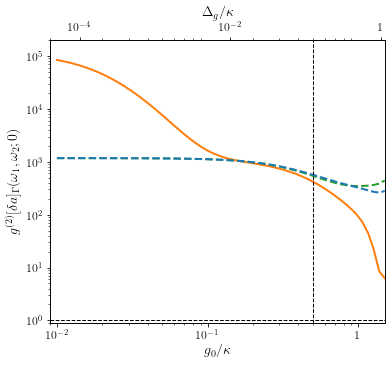

In [56]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(3, 2.6)
fig.set_size_inches(2*3, 2*2.6)

start = time.time()

npoints = 60

sS = np.zeros(npoints)	

N = 4
M = 8
Nall = N*M

a = tensor(destroy(N),qeye(M))
b = tensor(qeye(N),destroy(M))
ident = tensor(qeye(N),qeye(M))
c_ops = [ np.sqrt(kappa_a) * a, np.sqrt(kappa_b) * b]

correlations0 = np.empty(shape=(npoints))
correlations1 = np.empty(shape=(npoints))
correlations2 = np.empty(shape=(npoints))

wd1 = -1
wd2 = -wd1

ii = 0
c_ops = [np.sqrt(kappa_a) * a, np.sqrt(kappa_b) * b]
g0S = 10**np.linspace(-2, np.log10(1.5), npoints)
for g0 in g0S:
    delta_g = g0**2/wb
    detuning = delta_g
    
    HOM = detuning*a.dag()*a + wb*b.dag()*b - g0*a.dag()*a*(b.dag()+b) + 1.j*Omega*(a.dag() - a)
    rho_ss = steadystate(HOM, c_ops, method = 'direct')
    alphaExp = expect(a, rho_ss)
    alpha = Omega/(kappa_a/2+1j*delta_g)
    lv = liouvillian(HOM, c_ops)
    correlations0[ii] = calc_g_Gamma12(rho_ss, lv, kappa_d, wd1, wd2, a-alphaExp*ident, Nall)
#     correlations0[ii] = expect( \
#         (a.dag()-np.conj(alphaExp)*ident)*(a.dag()-np.conj(alphaExp)*ident)* \
#         (a-alphaExp*ident)*(a-alphaExp*ident), rho_ss)/ \
#         (expect((a.dag()-np.conj(alphaExp)*ident)*(a-alphaExp*ident), rho_ss)**2) 
    
#     print(g0, alpha, alphaExp)

    HOM = detuning*a.dag()*a + wb*b.dag()*b - g0*(alpha*a.dag()+np.conj(alpha)*a)*(b.dag()+b)
    rho_ss = steadystate(HOM, c_ops, method = 'direct')        
    lv = liouvillian(HOM, c_ops)
    correlations1[ii] = calc_g_Gamma12(rho_ss, lv, kappa_d, wd1, wd2, a, Nall)
#     correlations1[ii] = expect(a.dag()*a.dag()*a*a, rho_ss)/expect(a.dag()*a, rho_ss)**2 
#     correlations1[ii] = expect( \
#         (a.dag()+np.conj(alpha)*ident)*(a.dag()+np.conj(alpha)*ident)* \
#         (a+alpha*ident)*(a+alpha*ident), rho_ss)/ \
#         expect((a.dag()+np.conj(alpha)*ident)*(a+alpha*ident), rho_ss)**2 
    
    alpha = alphaExp
    HOM = detuning*a.dag()*a + wb*b.dag()*b - g0*(alpha*a.dag()+np.conj(alpha)*a)*(b.dag()+b)
    rho_ss = steadystate(HOM, c_ops, method = 'direct')        
    lv = liouvillian(HOM, c_ops)
    correlations2[ii] = calc_g_Gamma12(rho_ss, lv, kappa_d, wd1, wd2, a, Nall)
#     correlations2[ii] = expect(a.dag()*a.dag()*a*a, rho_ss)/expect(a.dag()*a, rho_ss)**2 
#     correlations2[ii] = expect( \
#         (a.dag()+np.conj(alpha)*ident)*(a.dag()+np.conj(alpha)*ident)* \
#         (a+alpha*ident)*(a+alpha*ident), rho_ss)/ \
#         expect((a.dag()+np.conj(alpha)*ident)*(a+alpha*ident), rho_ss)**2 
    ii = ii+1

ax.loglog(g0S, correlations0, color='tab:orange', linestyle='-', lw=2., label='nonlin.')
ax.loglog(g0S, correlations1, color='tab:green', linestyle='--', lw=2., label=r'$\alpha=\Omega/(\kappa/2+i\Delta_g)$')
ax.loglog(g0S, correlations2, color='tab:blue', linestyle='--', lw=2., label=r'$\alpha=\mean{a}_{\text{OM}}$')

end = time.time()
print(end-start)

ax.set_xlabel(r'$g_0/\kappa$', fontsize=fts)
ax.set_ylabel(r'$g^{(2)}[\delta a]_\Gamma(\omega_1,\omega_{2};0)$', fontsize=fts)
xticks = np.array([0.01,0.1,1])
ax.set_xlim(.009,1.5)
ax.set_xticks(xticks)
ax.set_xticklabels([r'$10^{-2}$',r'$10^{-1}$',r'$1$'], fontsize=fts2)
yticks = np.array([1, 10])
ax.set_yticks(yticks)
ax.set_yticklabels([r'$1$',r'$1.2$'], fontsize=fts2)
ax.set_ylim(.9,2e5)

ax2 = ax.twiny()
# g0S2 = 10**np.linspace(np.log10(1.5), np.log10(2.), npoints)
ax2.loglog(g0S, correlations0, 'r-', lw=1., label='', alpha=0)
x2ticks = np.array([10**-4,10**-2,1])
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(np.sqrt(x2ticks*wb))
ax2.set_xticklabels([r'$10^{-4}$',r'$10^{-2}$',r'$1$'], fontsize=fts2)
ax2.set_xlabel(r"$\Delta_g/\kappa$", fontsize=fts)

plt.axhline(y=1, color='k', linestyle='--', label='', linewidth=1)
plt.axvline(x=.5, color='k', linestyle='--', label='', linewidth=1)

fig.savefig('Fig5a_RE_leapfrog_fluct.png', dpi=1000)
fig.savefig('Fig5a_RE_leapfrog_fluct.svg', dpi=1000)


plt.show()


891.0433535575867


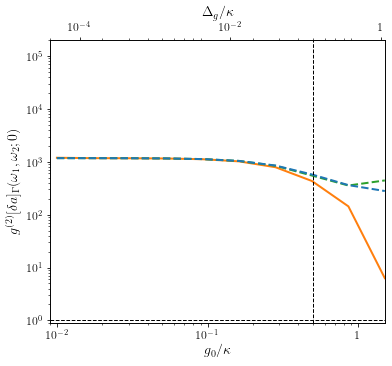

In [42]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(3, 2.6)
fig.set_size_inches(2*3, 2*2.6)

start = time.time()

npoints = 10

sS = np.zeros(npoints)	

N = 10
M = 8
Nall = N*M

a = tensor(destroy(N),qeye(M))
b = tensor(qeye(N),destroy(M))
ident = tensor(qeye(N),qeye(M))
c_ops = [ np.sqrt(kappa_a) * a, np.sqrt(kappa_b) * b]

correlations0 = np.empty(shape=(npoints))
correlations1 = np.empty(shape=(npoints))
correlations2 = np.empty(shape=(npoints))

wd1 = -1
wd2 = -wd1

ii = 0
c_ops = [np.sqrt(kappa_a) * a, np.sqrt(kappa_b) * b]
g0S = 10**np.linspace(-2, np.log10(1.5), npoints)
for g0 in g0S:
    delta_g = g0**2/wb
    detuning = delta_g
    
    HOM = detuning*a.dag()*a + wb*b.dag()*b - g0*a.dag()*a*(b.dag()+b) + 1.j*Omega*(a.dag() - a)
    rho_ss = steadystate(HOM, c_ops, method = 'direct')
    alphaExp = expect(a, rho_ss)
    alpha = Omega/(kappa_a/2+1j*delta_g)
    lv = liouvillian(HOM, c_ops)
    correlations0[ii] = calc_g_Gamma12(rho_ss, lv, kappa_d, wd1, wd2, a-alphaExp*ident, Nall)
#     correlations0[ii] = expect( \
#         (a.dag()-np.conj(alphaExp)*ident)*(a.dag()-np.conj(alphaExp)*ident)* \
#         (a-alphaExp*ident)*(a-alphaExp*ident), rho_ss)/ \
#         (expect((a.dag()-np.conj(alphaExp)*ident)*(a-alphaExp*ident), rho_ss)**2) 
    
#     print(g0, alpha, alphaExp)

    HOM = detuning*a.dag()*a + wb*b.dag()*b - g0*(alpha*a.dag()+np.conj(alpha)*a)*(b.dag()+b)
    rho_ss = steadystate(HOM, c_ops, method = 'direct')        
    lv = liouvillian(HOM, c_ops)
    correlations1[ii] = calc_g_Gamma12(rho_ss, lv, kappa_d, wd1, wd2, a, Nall)
#     correlations1[ii] = expect(a.dag()*a.dag()*a*a, rho_ss)/expect(a.dag()*a, rho_ss)**2 
#     correlations1[ii] = expect( \
#         (a.dag()+np.conj(alpha)*ident)*(a.dag()+np.conj(alpha)*ident)* \
#         (a+alpha*ident)*(a+alpha*ident), rho_ss)/ \
#         expect((a.dag()+np.conj(alpha)*ident)*(a+alpha*ident), rho_ss)**2 
    
    alpha = alphaExp
    HOM = detuning*a.dag()*a + wb*b.dag()*b - g0*(alpha*a.dag()+np.conj(alpha)*a)*(b.dag()+b)
    rho_ss = steadystate(HOM, c_ops, method = 'direct')        
    lv = liouvillian(HOM, c_ops)
    correlations2[ii] = calc_g_Gamma12(rho_ss, lv, kappa_d, wd1, wd2, a, Nall)
#     correlations2[ii] = expect(a.dag()*a.dag()*a*a, rho_ss)/expect(a.dag()*a, rho_ss)**2 
#     correlations2[ii] = expect( \
#         (a.dag()+np.conj(alpha)*ident)*(a.dag()+np.conj(alpha)*ident)* \
#         (a+alpha*ident)*(a+alpha*ident), rho_ss)/ \
#         expect((a.dag()+np.conj(alpha)*ident)*(a+alpha*ident), rho_ss)**2 
    ii = ii+1

ax.loglog(g0S, correlations0, color='tab:orange', linestyle='-', lw=2., label='nonlin.')
ax.loglog(g0S, correlations1, color='tab:green', linestyle='--', lw=2., label=r'$\alpha=\Omega/(\kappa/2+i\Delta_g)$')
ax.loglog(g0S, correlations2, color='tab:blue', linestyle='--', lw=2., label=r'$\alpha=\mean{a}_{\text{OM}}$')

end = time.time()
print(end-start)

ax.set_xlabel(r'$g_0/\kappa$', fontsize=fts)
ax.set_ylabel(r'$g^{(2)}[\delta a]_\Gamma(\omega_1,\omega_{2};0)$', fontsize=fts)
xticks = np.array([0.01,0.1,1])
ax.set_xlim(.009,1.5)
ax.set_xticks(xticks)
ax.set_xticklabels([r'$10^{-2}$',r'$10^{-1}$',r'$1$'], fontsize=fts2)
yticks = np.array([1, 10])
ax.set_yticks(yticks)
ax.set_yticklabels([r'$1$',r'$1.2$'], fontsize=fts2)
ax.set_ylim(.9,2e5)

ax2 = ax.twiny()
# g0S2 = 10**np.linspace(np.log10(1.5), np.log10(2.), npoints)
ax2.loglog(g0S, correlations0, 'r-', lw=1., label='', alpha=0)
x2ticks = np.array([10**-4,10**-2,1])
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(np.sqrt(x2ticks*wb))
ax2.set_xticklabels([r'$10^{-4}$',r'$10^{-2}$',r'$1$'], fontsize=fts2)
ax2.set_xlabel(r"$\Delta_g/\kappa$", fontsize=fts)

plt.axhline(y=1, color='k', linestyle='--', label='', linewidth=1)
plt.axvline(x=.5, color='k', linestyle='--', label='', linewidth=1)

fig.savefig('Fig5a_RE_leapfrog_fluct.png', dpi=1000)
fig.savefig('Fig5a_RE_leapfrog_fluct.svg', dpi=1000)


plt.show()


# Figure 6

## Figure 6a

In [10]:
kappa_a = 1.
kappa_b = .1
wb = 2
Omega = .1
g0 = .08
delta_g = g0**2/wb
# fn = Omega*(g0/wb)**n/n!

detuning = delta_g

N = 4
M = 8
Nall = N*M

suffix = "_g0Gamma";
kappa_d = .05 * kappa_a


### dynamics

In [ ]:
Omega = .1

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(6, 2.6)

start = time.time()

npoints = 200

taulist = np.linspace(0,200,npoints)
correlations = np.zeros(2*npoints)

# print(taulist)

a = tensor(destroy(N),qeye(M),qeye(2),qeye(2))
b = tensor(qeye(N),destroy(M),qeye(2),qeye(2))
ident = tensor(qeye(N),qeye(M),qeye(2),qeye(2))
nn = a.dag()*a

d1 = tensor(qeye(N),qeye(M),destroy(2),qeye(2))
d2 = tensor(qeye(N),qeye(M),qeye(2),destroy(2))
gd1 = .04 * kappa_a 
gd2 = gd1

Hd1_coupling = gd1*(a.dag()*d1 + a*d1.dag())
Hd2_coupling = gd2*(a.dag()*d2 + a*d2.dag())

ii = 0

wd1 = -wb
wd2 = -wd1
Hd1 = wd1*d1.dag()*d1
Hd2 = wd2*d2.dag()*d2 
Hoptomech = detuning*a.dag()*a + wb*b.dag()*b - g0*a.dag()*a*(b + b.dag()) + 1j * Omega * (a.dag() - a)
H = Hoptomech+Hd1+Hd2+Hd1_coupling+Hd2_coupling

# kappa_d = .75 * kappa_a
c_ops = [np.sqrt(kappa_a) * a, np.sqrt(kappa_b) * b, np.sqrt(kappa_d) * d1, np.sqrt(kappa_d) * d2]
H = Hoptomech+Hd1+Hd2+Hd1_coupling+Hd2_coupling
rho_ss = steadystate(H, c_ops, method = 'direct')
nd1 = expect(d1.dag()*d1, rho_ss).real
nd2 = expect(d2.dag()*d2, rho_ss).real
G2 = calc_G_Gamma12_tau(H, taulist, c_ops, d1.dag(), d2.dag(), d2, d1, rho0=rho_ss)
g2 = G2 / (nd1*nd2)
lbl = r'$g_\Gamma^{(2)}(\omega_S,\omega_{aS};\tau); \Gamma=$'+str(kappa_d)+r'$\kappa$'
ax.plot(taulist, np.real(g2), color='orange', linestyle='-', lw=2., label=lbl)
G2 = calc_G_Gamma12_tau(H, taulist, c_ops, d2.dag(), d1.dag(), d1, d2, rho0=rho_ss)
g2 = G2 / (nd1*nd2)
ax.plot(-taulist, np.real(g2), color='orange', linestyle='-', lw=2.)

# kappa_d = .5 * kappa_a
# c_ops = [np.sqrt(kappa_a) * a, np.sqrt(kappa_b) * b, np.sqrt(kappa_d) * d1, np.sqrt(kappa_d) * d2]
alpha = expect(a, rho_ss)
Hd1_coupling = gd1*((a.dag()-np.conj(alpha)*ident)*d1 + (a-alpha*ident)*d1.dag())
Hd2_coupling = gd2*((a.dag()-np.conj(alpha)*ident)*d2 + (a-alpha*ident)*d2.dag())
H = Hoptomech+Hd1+Hd2+Hd1_coupling+Hd2_coupling
rho_ss = steadystate(H, c_ops, method = 'direct')
nd1 = expect(d1.dag()*d1, rho_ss).real
nd2 = expect(d2.dag()*d2, rho_ss).real
G2 = calc_G_Gamma12_tau(H, taulist, c_ops, d1.dag(), d2.dag(), d2, d1, rho0=rho_ss)
g2 = G2 / (nd1*nd2)
lbl = r'$g_\Gamma^{(2)}(\omega_S,\omega_{aS};\tau); \Gamma=$'+str(kappa_d)+r'$\kappa$'
ax.plot(taulist, np.real(g2), color='red', linestyle='-', lw=2., label=lbl)
G2 = calc_G_Gamma12_tau(H, taulist, c_ops, d2.dag(), d1.dag(), d1, d2, rho0=rho_ss)
g2 = G2 / (nd1*nd2)
ax.plot(-taulist, np.real(g2), color='red', linestyle='-', lw=2.)

end = time.time()
print(end-start)

plt.ylim(5e-1,5e2)
ax.set_yscale('log')
ax.set_yticks([1, 1e1, 1e2])
ax.set_xlabel(r'$\kappa\tau$', fontsize=fts)
ax.set_ylabel(r'$g^{(2)}_{\Gamma}(\omega_S,\omega_{aS};\tau)$', fontsize=fts)
plt.xlim(-taulist[-1], taulist[-1])
plt.xticks(np.arange(-taulist[-1],taulist[-1]+1,100))
ax.set_xticklabels([r'$-200$',r'$-100$',r'$0$',r'$100$',r'$200$'], fontsize=fts2)
ax.set_yticklabels([r'$1$',r'$10$',r'$10^2$'], fontsize=fts2)
plt.axhline(y=1, color='k', linestyle='--', label='', linewidth=.5)

plt.axvline(x=0, color='k', linestyle='--', label='', linewidth=.5)

# fig.savefig('Fig6a.svg', dpi=1000)
# fig.savefig('Fig6a.png', dpi=1000)

plt.show()




206.28955149650574


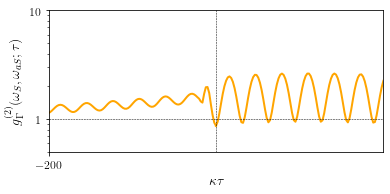

In [7]:
Omega = .1

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(6, 2.6)

start = time.time()

npoints = 100

taulist = np.linspace(0,20,npoints)
correlations = np.zeros(2*npoints)

# print(taulist)

a = tensor(destroy(N),qeye(M),qeye(2),qeye(2))
b = tensor(qeye(N),destroy(M),qeye(2),qeye(2))
ident = tensor(qeye(N),qeye(M),qeye(2),qeye(2))
nn = a.dag()*a

d1 = tensor(qeye(N),qeye(M),destroy(2),qeye(2))
d2 = tensor(qeye(N),qeye(M),qeye(2),destroy(2))
gd1 = .04 * kappa_a 
gd2 = gd1

Hd1_coupling = gd1*(a.dag()*d1 + a*d1.dag())
Hd2_coupling = gd2*(a.dag()*d2 + a*d2.dag())

ii = 0

wd1 = -wb
wd2 = -wd1
Hd1 = wd1*d1.dag()*d1
Hd2 = wd2*d2.dag()*d2 
Hoptomech = detuning*a.dag()*a + wb*b.dag()*b - g0*a.dag()*a*(b + b.dag()) + 1j * Omega * (a.dag() - a)
H = Hoptomech+Hd1+Hd2+Hd1_coupling+Hd2_coupling

# kappa_d = .75 * kappa_a
c_ops = [np.sqrt(kappa_a) * a, np.sqrt(kappa_b) * b, np.sqrt(kappa_d) * d1, np.sqrt(kappa_d) * d2]
H = Hoptomech+Hd1+Hd2+Hd1_coupling+Hd2_coupling
rho_ss = steadystate(H, c_ops, method = 'direct')
nd1 = expect(d1.dag()*d1, rho_ss).real
nd2 = expect(d2.dag()*d2, rho_ss).real
G2 = calc_G_Gamma12_tau(H, taulist, c_ops, d1.dag(), d2.dag(), d2, d1, rho0=rho_ss)
g2 = G2 / (nd1*nd2)
lbl = r'$g_\Gamma^{(2)}(\omega_S,\omega_{aS};\tau); \Gamma=$'+str(kappa_d)+r'$\kappa$'
ax.plot(taulist, np.real(g2), color='orange', linestyle='-', lw=2., label=lbl)
G2 = calc_G_Gamma12_tau(H, taulist, c_ops, d2.dag(), d1.dag(), d1, d2, rho0=rho_ss)
g2 = G2 / (nd1*nd2)
ax.plot(-taulist, np.real(g2), color='orange', linestyle='-', lw=2.)


end = time.time()
print(end-start)

plt.ylim(5e-1,5e0)
ax.set_yscale('log')
ax.set_yticks([1, 1e1])
ax.set_xlabel(r'$\kappa\tau$', fontsize=fts)
ax.set_ylabel(r'$g^{(2)}_{\Gamma}(\omega_S,\omega_{aS};\tau)$', fontsize=fts)
plt.xlim(-taulist[-1], taulist[-1])
plt.xticks(np.arange(-taulist[-1],taulist[-1]+1,100))
ax.set_xticklabels([r'$-200$',r'$-100$',r'$0$',r'$100$',r'$200$'], fontsize=fts2)
ax.set_yticklabels([r'$1$',r'$10$',r'$10^2$'], fontsize=fts2)
plt.axhline(y=1, color='k', linestyle='--', label='', linewidth=.5)

plt.axvline(x=0, color='k', linestyle='--', label='', linewidth=.5)

# fig.savefig('Fig6a.svg', dpi=1000)
# fig.savefig('Fig6a.png', dpi=1000)

plt.show()




99.56418538093567


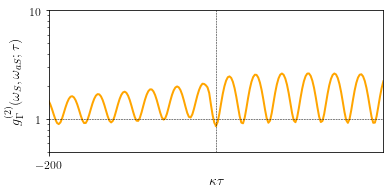

In [12]:
N = 4
M = 8
Nall = N*M

Omega = .1

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(6, 2.6)

start = time.time()

npoints = 100

taulist = np.linspace(0,20,npoints)
correlations = np.zeros(2*npoints)

# print(taulist)

a = tensor(destroy(N),qeye(M),qeye(2),qeye(2))
b = tensor(qeye(N),destroy(M),qeye(2),qeye(2))
ident = tensor(qeye(N),qeye(M),qeye(2),qeye(2))
nn = a.dag()*a

d1 = tensor(qeye(N),qeye(M),destroy(2),qeye(2))
d2 = tensor(qeye(N),qeye(M),qeye(2),destroy(2))
gd1 = .05 * kappa_a 
gd2 = gd1

Hd1_coupling = gd1*(a.dag()*d1 + a*d1.dag())
Hd2_coupling = gd2*(a.dag()*d2 + a*d2.dag())

ii = 0

wd1 = -wb
wd2 = -wd1
Hd1 = wd1*d1.dag()*d1
Hd2 = wd2*d2.dag()*d2 
Hoptomech = detuning*a.dag()*a + wb*b.dag()*b - g0*a.dag()*a*(b + b.dag()) + 1j * Omega * (a.dag() - a)
H = Hoptomech+Hd1+Hd2+Hd1_coupling+Hd2_coupling

# kappa_d = .75 * kappa_a
c_ops = [np.sqrt(kappa_a) * a, np.sqrt(kappa_b) * b, np.sqrt(kappa_d) * d1, np.sqrt(kappa_d) * d2]
H = Hoptomech+Hd1+Hd2+Hd1_coupling+Hd2_coupling
rho_ss = steadystate(H, c_ops, method = 'direct')
nd1 = expect(d1.dag()*d1, rho_ss).real
nd2 = expect(d2.dag()*d2, rho_ss).real
G2 = calc_G_Gamma12_tau(H, taulist, c_ops, d1.dag(), d2.dag(), d2, d1, rho0=rho_ss)
g2 = G2 / (nd1*nd2)
lbl = r'$g_\Gamma^{(2)}(\omega_S,\omega_{aS};\tau); \Gamma=$'+str(kappa_d)+r'$\kappa$'
ax.plot(taulist, np.real(g2), color='orange', linestyle='-', lw=2., label=lbl)
G2 = calc_G_Gamma12_tau(H, taulist, c_ops, d2.dag(), d1.dag(), d1, d2, rho0=rho_ss)
g2 = G2 / (nd1*nd2)
ax.plot(-taulist, np.real(g2), color='orange', linestyle='-', lw=2.)


end = time.time()
print(end-start)

plt.ylim(5e-1,5e0)
ax.set_yscale('log')
ax.set_yticks([1, 1e1])
ax.set_xlabel(r'$\kappa\tau$', fontsize=fts)
ax.set_ylabel(r'$g^{(2)}_{\Gamma}(\omega_S,\omega_{aS};\tau)$', fontsize=fts)
plt.xlim(-taulist[-1], taulist[-1])
plt.xticks(np.arange(-taulist[-1],taulist[-1]+1,100))
ax.set_xticklabels([r'$-200$',r'$-100$',r'$0$',r'$100$',r'$200$'], fontsize=fts2)
ax.set_yticklabels([r'$1$',r'$10$',r'$10^2$'], fontsize=fts2)
plt.axhline(y=1, color='k', linestyle='--', label='', linewidth=.5)

plt.axvline(x=0, color='k', linestyle='--', label='', linewidth=.5)

# fig.savefig('Fig6a.svg', dpi=1000)
# fig.savefig('Fig6a.png', dpi=1000)

plt.show()




114.2472038269043


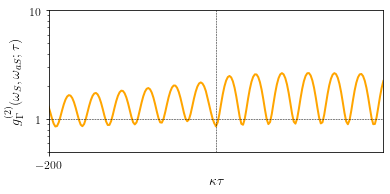

In [13]:
N = 4
M = 8
Nall = N*M

Omega = .1

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(6, 2.6)

start = time.time()

npoints = 100

taulist = np.linspace(0,20,npoints)
correlations = np.zeros(2*npoints)

# print(taulist)

a = tensor(destroy(N),qeye(M),qeye(2),qeye(2))
b = tensor(qeye(N),destroy(M),qeye(2),qeye(2))
ident = tensor(qeye(N),qeye(M),qeye(2),qeye(2))
nn = a.dag()*a

d1 = tensor(qeye(N),qeye(M),destroy(2),qeye(2))
d2 = tensor(qeye(N),qeye(M),qeye(2),destroy(2))
gd1 = .06 * kappa_a 
gd2 = gd1

Hd1_coupling = gd1*(a.dag()*d1 + a*d1.dag())
Hd2_coupling = gd2*(a.dag()*d2 + a*d2.dag())

ii = 0

wd1 = -wb
wd2 = -wd1
Hd1 = wd1*d1.dag()*d1
Hd2 = wd2*d2.dag()*d2 
Hoptomech = detuning*a.dag()*a + wb*b.dag()*b - g0*a.dag()*a*(b + b.dag()) + 1j * Omega * (a.dag() - a)
H = Hoptomech+Hd1+Hd2+Hd1_coupling+Hd2_coupling

# kappa_d = .75 * kappa_a
c_ops = [np.sqrt(kappa_a) * a, np.sqrt(kappa_b) * b, np.sqrt(kappa_d) * d1, np.sqrt(kappa_d) * d2]
H = Hoptomech+Hd1+Hd2+Hd1_coupling+Hd2_coupling
rho_ss = steadystate(H, c_ops, method = 'direct')
nd1 = expect(d1.dag()*d1, rho_ss).real
nd2 = expect(d2.dag()*d2, rho_ss).real
G2 = calc_G_Gamma12_tau(H, taulist, c_ops, d1.dag(), d2.dag(), d2, d1, rho0=rho_ss)
g2 = G2 / (nd1*nd2)
lbl = r'$g_\Gamma^{(2)}(\omega_S,\omega_{aS};\tau); \Gamma=$'+str(kappa_d)+r'$\kappa$'
ax.plot(taulist, np.real(g2), color='orange', linestyle='-', lw=2., label=lbl)
G2 = calc_G_Gamma12_tau(H, taulist, c_ops, d2.dag(), d1.dag(), d1, d2, rho0=rho_ss)
g2 = G2 / (nd1*nd2)
ax.plot(-taulist, np.real(g2), color='orange', linestyle='-', lw=2.)


end = time.time()
print(end-start)

plt.ylim(5e-1,5e0)
ax.set_yscale('log')
ax.set_yticks([1, 1e1])
ax.set_xlabel(r'$\kappa\tau$', fontsize=fts)
ax.set_ylabel(r'$g^{(2)}_{\Gamma}(\omega_S,\omega_{aS};\tau)$', fontsize=fts)
plt.xlim(-taulist[-1], taulist[-1])
plt.xticks(np.arange(-taulist[-1],taulist[-1]+1,100))
ax.set_xticklabels([r'$-200$',r'$-100$',r'$0$',r'$100$',r'$200$'], fontsize=fts2)
ax.set_yticklabels([r'$1$',r'$10$',r'$10^2$'], fontsize=fts2)
plt.axhline(y=1, color='k', linestyle='--', label='', linewidth=.5)

plt.axvline(x=0, color='k', linestyle='--', label='', linewidth=.5)

# fig.savefig('Fig6a.svg', dpi=1000)
# fig.savefig('Fig6a.png', dpi=1000)

plt.show()




194.79421591758728


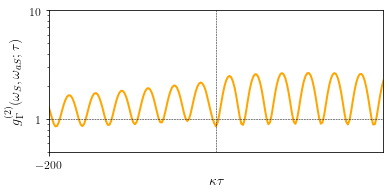

In [14]:
N = 4
M = 9
Nall = N*M

Omega = .1

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(6, 2.6)

start = time.time()

npoints = 100

taulist = np.linspace(0,20,npoints)
correlations = np.zeros(2*npoints)

# print(taulist)

a = tensor(destroy(N),qeye(M),qeye(2),qeye(2))
b = tensor(qeye(N),destroy(M),qeye(2),qeye(2))
ident = tensor(qeye(N),qeye(M),qeye(2),qeye(2))
nn = a.dag()*a

d1 = tensor(qeye(N),qeye(M),destroy(2),qeye(2))
d2 = tensor(qeye(N),qeye(M),qeye(2),destroy(2))
gd1 = .06 * kappa_a 
gd2 = gd1

Hd1_coupling = gd1*(a.dag()*d1 + a*d1.dag())
Hd2_coupling = gd2*(a.dag()*d2 + a*d2.dag())

ii = 0

wd1 = -wb
wd2 = -wd1
Hd1 = wd1*d1.dag()*d1
Hd2 = wd2*d2.dag()*d2 
Hoptomech = detuning*a.dag()*a + wb*b.dag()*b - g0*a.dag()*a*(b + b.dag()) + 1j * Omega * (a.dag() - a)
H = Hoptomech+Hd1+Hd2+Hd1_coupling+Hd2_coupling

# kappa_d = .75 * kappa_a
c_ops = [np.sqrt(kappa_a) * a, np.sqrt(kappa_b) * b, np.sqrt(kappa_d) * d1, np.sqrt(kappa_d) * d2]
H = Hoptomech+Hd1+Hd2+Hd1_coupling+Hd2_coupling
rho_ss = steadystate(H, c_ops, method = 'direct')
nd1 = expect(d1.dag()*d1, rho_ss).real
nd2 = expect(d2.dag()*d2, rho_ss).real
G2 = calc_G_Gamma12_tau(H, taulist, c_ops, d1.dag(), d2.dag(), d2, d1, rho0=rho_ss)
g2 = G2 / (nd1*nd2)
lbl = r'$g_\Gamma^{(2)}(\omega_S,\omega_{aS};\tau); \Gamma=$'+str(kappa_d)+r'$\kappa$'
ax.plot(taulist, np.real(g2), color='orange', linestyle='-', lw=2., label=lbl)
G2 = calc_G_Gamma12_tau(H, taulist, c_ops, d2.dag(), d1.dag(), d1, d2, rho0=rho_ss)
g2 = G2 / (nd1*nd2)
ax.plot(-taulist, np.real(g2), color='orange', linestyle='-', lw=2.)


end = time.time()
print(end-start)

plt.ylim(5e-1,5e0)
ax.set_yscale('log')
ax.set_yticks([1, 1e1])
ax.set_xlabel(r'$\kappa\tau$', fontsize=fts)
ax.set_ylabel(r'$g^{(2)}_{\Gamma}(\omega_S,\omega_{aS};\tau)$', fontsize=fts)
plt.xlim(-taulist[-1], taulist[-1])
plt.xticks(np.arange(-taulist[-1],taulist[-1]+1,100))
ax.set_xticklabels([r'$-200$',r'$-100$',r'$0$',r'$100$',r'$200$'], fontsize=fts2)
ax.set_yticklabels([r'$1$',r'$10$',r'$10^2$'], fontsize=fts2)
plt.axhline(y=1, color='k', linestyle='--', label='', linewidth=.5)

plt.axvline(x=0, color='k', linestyle='--', label='', linewidth=.5)

# fig.savefig('Fig6a.svg', dpi=1000)
# fig.savefig('Fig6a.png', dpi=1000)

plt.show()




### spectrum inset

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(2, .9)

start = time.time()

npoints = 400;

a = tensor(destroy(N),qeye(M))
b = tensor(qeye(N),destroy(M))
ident = tensor(qeye(N),qeye(M))
nn = a.dag()*a

c_ops = [np.sqrt(kappa_a) * a, np.sqrt(kappa_b) * b]

wlist2_0 = np.linspace(-4.5, 4.5, npoints)
Hoptomech = detuning*a.dag()*a + wb*b.dag()*b - g0*a.dag()*a*(b + b.dag()) + 1j * Omega * (a.dag() - a)
sS_d = np.empty(shape=(npoints))
rho_ss = steadystate(Hoptomech, c_ops, method = 'direct')
lv = liouvillian(Hoptomech, c_ops)

# kappa_d = .05 * kappa_a
jj = 0
for wd1 in wlist2_0: 
    sS_d[jj] = calc_S_Gamma(rho_ss, lv, kappa_d, wd1, a, Nall)
    jj = jj+1
ax.plot(wlist2_0, 1e7*sS_d, color='tab:gray', linestyle='-', lw=2.)

alpha = expect(a, rho_ss)
jj = 0
for wd1 in wlist2_0: 
    sS_d[jj] = calc_S_Gamma(rho_ss, lv, kappa_d, wd1, a-alpha*ident, Nall)
    jj = jj+1
ax.plot(wlist2_0, 1e7*sS_d, color='k', linestyle='--', lw=2.)

end = time.time()
print(end-start)

ax.legend()
ax.set_xlabel(r'$\omega-\omega_L$', fontsize=fts)
ax.set_ylabel(r'$S_\Gamma(\omega)$', fontsize=fts)
ax.set_xticklabels([r'$-\omega_b$',r'$0$',r'$\omega_b$'], fontsize=fts2)

plt.xlim(-2.5,2.5)
plt.xticks([-2,0,2])
ax.set_xticks([-wb,0,wb])
plt.ylim(1,1.5e7)
ax.fill_between(wlist2_0, 1, 1e7*sS_d, color='k', alpha=0.1)
ax.set_yscale('log')
ax.set_yticks([1, 1e5])
ax.set_yticklabels([r'$1$',r'$10^5$'], fontsize=fts2)
ax.get_legend().remove()

# f = mpl.ticker.ScalarFormatter(useOffset=False, useMathText=True)
# g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.10e' % x))
# plt.gca().yaxis.set_major_formatter(mpl.ticker.FuncFormatter(g))
# plt.gcf().subplots_adjust(bottom=0.1, left=0.2)

fig.savefig('Fig6a_inset2.svg', dpi=2000)
fig.savefig('Fig6a_inset2.png', dpi=2000)

# print(expect(a.dag()*a.dag()*a*a, rho_ss)/expect(a.dag()*a, rho_ss)**2)

plt.show()


## Figure 6b

In [8]:
kappa_a = 1.
kappa_b = .1
wb = 2
Omega = .1
g0 = 1
delta_g = g0**2/wb
# fn = Omega*(g0/wb)**n/n!

detuning = delta_g

N = 4
M = 8
Nall = N*M

suffix = "_g0Gamma";
kappa_d = .5 * kappa_a


### dynamics

In [ ]:
Omega = .1

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(6, 2.6)

start = time.time()

npoints = 200

taulist = np.linspace(0,60,npoints)
correlations = np.zeros(2*npoints)

# print(taulist)

a = tensor(destroy(N),qeye(M),qeye(2),qeye(2))
b = tensor(qeye(N),destroy(M),qeye(2),qeye(2))
ident = tensor(qeye(N),qeye(M),qeye(2),qeye(2))
nn = a.dag()*a

d1 = tensor(qeye(N),qeye(M),destroy(2),qeye(2))
d2 = tensor(qeye(N),qeye(M),qeye(2),destroy(2))
gd1 = .04 * kappa_a 
gd2 = gd1

Hd1_coupling = gd1*(a.dag()*d1 + a*d1.dag())
Hd2_coupling = gd2*(a.dag()*d2 + a*d2.dag())

ii = 0

wd1 = -wb
wd2 = -wd1
Hd1 = wd1*d1.dag()*d1
Hd2 = wd2*d2.dag()*d2 
Hoptomech = detuning*a.dag()*a + wb*b.dag()*b - g0*a.dag()*a*(b + b.dag()) + 1j * Omega * (a.dag() - a)
H = Hoptomech+Hd1+Hd2+Hd1_coupling+Hd2_coupling

# kappa_d = .75 * kappa_a
c_ops = [np.sqrt(kappa_a) * a, np.sqrt(kappa_b) * b, np.sqrt(kappa_d) * d1, np.sqrt(kappa_d) * d2]
H = Hoptomech+Hd1+Hd2+Hd1_coupling+Hd2_coupling
rho_ss = steadystate(H, c_ops, method = 'direct')
nd1 = expect(d1.dag()*d1, rho_ss).real
nd2 = expect(d2.dag()*d2, rho_ss).real
G2 = calc_G_Gamma12_tau(H, taulist, c_ops, d1.dag(), d2.dag(), d2, d1, rho0=rho_ss)
g2 = G2 / (nd1*nd2)
lbl = r'$g_\Gamma^{(2)}(\omega_S,\omega_{aS};\tau); \Gamma=$'+str(kappa_d)+r'$\kappa$'
ax.plot(taulist, np.real(g2), color='orange', linestyle='-', lw=2., label=lbl)
G2 = calc_G_Gamma12_tau(H, taulist, c_ops, d2.dag(), d1.dag(), d1, d2, rho0=rho_ss)
g2 = G2 / (nd1*nd2)
ax.plot(-taulist, np.real(g2), color='orange', linestyle='-', lw=2.)

# kappa_d = .5 * kappa_a
# c_ops = [np.sqrt(kappa_a) * a, np.sqrt(kappa_b) * b, np.sqrt(kappa_d) * d1, np.sqrt(kappa_d) * d2]
alpha = expect(a, rho_ss)
Hd1_coupling = gd1*((a.dag()-np.conj(alpha)*ident)*d1 + (a-alpha*ident)*d1.dag())
Hd2_coupling = gd2*((a.dag()-np.conj(alpha)*ident)*d2 + (a-alpha*ident)*d2.dag())
H = Hoptomech+Hd1+Hd2+Hd1_coupling+Hd2_coupling
rho_ss = steadystate(H, c_ops, method = 'direct')
nd1 = expect(d1.dag()*d1, rho_ss).real
nd2 = expect(d2.dag()*d2, rho_ss).real
G2 = calc_G_Gamma12_tau(H, taulist, c_ops, d1.dag(), d2.dag(), d2, d1, rho0=rho_ss)
g2 = G2 / (nd1*nd2)
lbl = r'$g_\Gamma^{(2)}(\omega_S,\omega_{aS};\tau); \Gamma=$'+str(kappa_d)+r'$\kappa$'
ax.plot(taulist, np.real(g2), color='red', linestyle='-', lw=2., label=lbl)
G2 = calc_G_Gamma12_tau(H, taulist, c_ops, d2.dag(), d1.dag(), d1, d2, rho0=rho_ss)
g2 = G2 / (nd1*nd2)
ax.plot(-taulist, np.real(g2), color='red', linestyle='-', lw=2.)

end = time.time()
print(end-start)

plt.ylim(7e-1,1e1)
ax.set_yscale('log')
ax.set_yticks([1, 1e1])
ax.set_xlabel(r'$\kappa\tau$', fontsize=fts)
ax.set_ylabel(r'$g^{(2)}_{\Gamma}(\omega_S,\omega_{aS};\tau)$', fontsize=fts)
plt.xlim(-taulist[-1], taulist[-1])
plt.xticks(np.arange(-taulist[-1],taulist[-1]+1,30))

ax.set_xticklabels([r'$-60$',r'$-30$',r'$0$',r'$30$',r'$60$'], fontsize=fts2)
ax.set_yticklabels([r'$1$',r'$10$'], fontsize=fts2)

plt.axhline(y=1, color='k', linestyle='--', label='', linewidth=.5)

plt.axvline(x=0, color='k', linestyle='--', label='', linewidth=.5)

fig.savefig('Fig6b.svg', dpi=1000)
fig.savefig('Fig6b.png', dpi=1000)

plt.show()




121.12286901473999


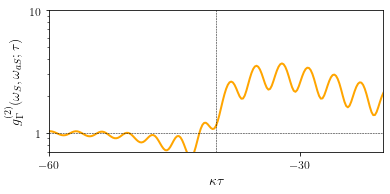

In [9]:
Omega = .1

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(6, 2.6)

start = time.time()

npoints = 100

taulist = np.linspace(0,20,npoints)
correlations = np.zeros(2*npoints)

# print(taulist)

a = tensor(destroy(N),qeye(M),qeye(2),qeye(2))
b = tensor(qeye(N),destroy(M),qeye(2),qeye(2))
ident = tensor(qeye(N),qeye(M),qeye(2),qeye(2))
nn = a.dag()*a

d1 = tensor(qeye(N),qeye(M),destroy(2),qeye(2))
d2 = tensor(qeye(N),qeye(M),qeye(2),destroy(2))
gd1 = .04 * kappa_a 
gd2 = gd1

Hd1_coupling = gd1*(a.dag()*d1 + a*d1.dag())
Hd2_coupling = gd2*(a.dag()*d2 + a*d2.dag())

ii = 0

wd1 = -wb
wd2 = -wd1
Hd1 = wd1*d1.dag()*d1
Hd2 = wd2*d2.dag()*d2 
Hoptomech = detuning*a.dag()*a + wb*b.dag()*b - g0*a.dag()*a*(b + b.dag()) + 1j * Omega * (a.dag() - a)
H = Hoptomech+Hd1+Hd2+Hd1_coupling+Hd2_coupling

# kappa_d = .75 * kappa_a
c_ops = [np.sqrt(kappa_a) * a, np.sqrt(kappa_b) * b, np.sqrt(kappa_d) * d1, np.sqrt(kappa_d) * d2]
H = Hoptomech+Hd1+Hd2+Hd1_coupling+Hd2_coupling
rho_ss = steadystate(H, c_ops, method = 'direct')
nd1 = expect(d1.dag()*d1, rho_ss).real
nd2 = expect(d2.dag()*d2, rho_ss).real
G2 = calc_G_Gamma12_tau(H, taulist, c_ops, d1.dag(), d2.dag(), d2, d1, rho0=rho_ss)
g2 = G2 / (nd1*nd2)
lbl = r'$g_\Gamma^{(2)}(\omega_S,\omega_{aS};\tau); \Gamma=$'+str(kappa_d)+r'$\kappa$'
ax.plot(taulist, np.real(g2), color='orange', linestyle='-', lw=2., label=lbl)
G2 = calc_G_Gamma12_tau(H, taulist, c_ops, d2.dag(), d1.dag(), d1, d2, rho0=rho_ss)
g2 = G2 / (nd1*nd2)
ax.plot(-taulist, np.real(g2), color='orange', linestyle='-', lw=2.)


end = time.time()
print(end-start)

plt.ylim(7e-1,1e1)
ax.set_yscale('log')
ax.set_yticks([1, 1e1])
ax.set_xlabel(r'$\kappa\tau$', fontsize=fts)
ax.set_ylabel(r'$g^{(2)}_{\Gamma}(\omega_S,\omega_{aS};\tau)$', fontsize=fts)
plt.xlim(-taulist[-1], taulist[-1])
plt.xticks(np.arange(-taulist[-1],taulist[-1]+1,30))

ax.set_xticklabels([r'$-20$',r'$0$',r'$20$'], fontsize=fts2)
ax.set_yticklabels([r'$1$',r'$10$'], fontsize=fts2)

plt.axhline(y=1, color='k', linestyle='--', label='', linewidth=.5)

plt.axvline(x=0, color='k', linestyle='--', label='', linewidth=.5)

# fig.savefig('Fig6b.svg', dpi=1000)
# fig.savefig('Fig6b.png', dpi=1000)

plt.show()




### spectrum

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(2, .9)

start = time.time()

npoints = 400;

a = tensor(destroy(N),qeye(M))
b = tensor(qeye(N),destroy(M))
ident = tensor(qeye(N),qeye(M))
nn = a.dag()*a

c_ops = [np.sqrt(kappa_a) * a, np.sqrt(kappa_b) * b]

wlist2_0 = np.linspace(-4.5, 4.5, npoints)
Hoptomech = detuning*a.dag()*a + wb*b.dag()*b - g0*a.dag()*a*(b + b.dag()) + 1j * Omega * (a.dag() - a)
sS_d = np.empty(shape=(npoints))
rho_ss = steadystate(Hoptomech, c_ops, method = 'direct')
lv = liouvillian(Hoptomech, c_ops)

# kappa_d = .05 * kappa_a
jj = 0
for wd1 in wlist2_0: 
    sS_d[jj] = calc_S_Gamma(rho_ss, lv, kappa_d, wd1, a, Nall)
    jj = jj+1
ax.plot(wlist2_0, 1e4*sS_d, color='tab:gray', linestyle='-', lw=2.)

alpha = expect(a, rho_ss)
jj = 0
for wd1 in wlist2_0: 
    sS_d[jj] = calc_S_Gamma(rho_ss, lv, kappa_d, wd1, a-alpha*ident, Nall)
    jj = jj+1
ax.plot(wlist2_0, 1e4*sS_d, color='k', linestyle='--', lw=2.)

end = time.time()
print(end-start)

ax.set_yscale('log')
plt.ylim(1,1e3)
plt.yticks([1,1e2])
ax.set_yticklabels([1,r'$10^2$'])
# plt.text(0, 1e9, r'$g_\Gamma^{(2)}(\omega_{S},\omega_{aS}; \tau)$', fontsize=12)
# plt.text(0, 1e12, r'$g_\Gamma^{(2)}[\delta a](\omega_{S},\omega_{aS}; \tau)$', fontsize=12)

ax.legend()
ax.set_xlabel(r'$\omega-\omega_L$', fontsize=fts)
ax.set_ylabel(r'$S_\Gamma(\omega)$', fontsize=fts)
ax.set_xticklabels([r'$-\omega_b$',r'$0$',r'$\omega_b$'], fontsize=fts2)

plt.xlim(-2.5,2.5)
plt.xticks([-2,0,2])
ax.set_xticks([-wb,0,wb])
plt.ylim(1,1.5e3)
ax.fill_between(wlist2_0, 1, 1e4*sS_d, color='k', alpha=0.1)
ax.set_yscale('log')
ax.set_yticks([1, 1e2])
ax.set_yticklabels([r'$1$',r'$10^2$'], fontsize=fts2)
ax.get_legend().remove()

# f = mpl.ticker.ScalarFormatter(useOffset=False, useMathText=True)
# g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.10e' % x))
# plt.gca().yaxis.set_major_formatter(mpl.ticker.FuncFormatter(g))
# plt.gcf().subplots_adjust(bottom=0.1, left=0.2)

fig.savefig('Fig6b_inset2.svg', dpi=2000)
fig.savefig('Fig6b_inset2.png', dpi=2000)

# print(expect(a.dag()*a.dag()*a*a, rho_ss)/expect(a.dag()*a, rho_ss)**2)

plt.show()


## Figure 6c

In [ ]:
kappa_a = 1.
kappa_b = .1
wb = 2
Omega = .1
g0 = .2
delta_g = g0**2/wb
# fn = Omega*(g0/wb)**n/n!

detuning = delta_g

N = 4
M = 5
Nall = N*M

suffix = "_g0Gamma";
kappa_d = .05 * kappa_a


### dynamics

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(6, 2.6)

start = time.time()

npoints = 200

taulist = np.linspace(0,200,npoints)
correlations = np.zeros(2*npoints)

# print(taulist)

a = tensor(destroy(N),qeye(M),qeye(2),qeye(2))
b = tensor(qeye(N),destroy(M),qeye(2),qeye(2))
ident = tensor(qeye(N),qeye(M),qeye(2),qeye(2))
nn = a.dag()*a

d1 = tensor(qeye(N),qeye(M),destroy(2),qeye(2))
d2 = tensor(qeye(N),qeye(M),qeye(2),destroy(2))
gd1 = .04 * kappa_a 
gd2 = gd1

Hd1_coupling = gd1*(a.dag()*d1 + a*d1.dag())
Hd2_coupling = gd2*(a.dag()*d2 + a*d2.dag())

ii = 0

wd1 = -wb/2.
wd2 = -wd1
Hd1 = wd1*d1.dag()*d1
Hd2 = wd2*d2.dag()*d2 
Hoptomech = detuning*a.dag()*a + wb*b.dag()*b - g0*a.dag()*a*(b + b.dag()) + 1j * Omega * (a.dag() - a)
H = Hoptomech+Hd1+Hd2+Hd1_coupling+Hd2_coupling

# kappa_d = .75 * kappa_a
c_ops = [np.sqrt(kappa_a) * a, np.sqrt(kappa_b) * b, np.sqrt(kappa_d) * d1, np.sqrt(kappa_d) * d2]
H = Hoptomech+Hd1+Hd2+Hd1_coupling+Hd2_coupling
rho_ss = steadystate(H, c_ops, method = 'direct')
nd1 = expect(d1.dag()*d1, rho_ss).real
nd2 = expect(d2.dag()*d2, rho_ss).real
G2 = calc_G_Gamma12_tau(H, taulist, c_ops, d1.dag(), d2.dag(), d2, d1, rho0=rho_ss)
g2 = G2 / (nd1*nd2)
lbl = r'$g_\Gamma^{(2)}(\omega_S,\omega_{aS};\tau); \Gamma=$'+str(kappa_d)+r'$\kappa$'
ax.plot(taulist, np.real(g2), color='tab:green', linestyle='-', lw=2., label=lbl)
G2 = calc_G_Gamma12_tau(H, taulist, c_ops, d2.dag(), d1.dag(), d1, d2, rho0=rho_ss)
g2 = G2 / (nd1*nd2)
ax.plot(-taulist, np.real(g2), color='tab:green', linestyle='-', lw=2.)

# kappa_d = .5 * kappa_a
# c_ops = [np.sqrt(kappa_a) * a, np.sqrt(kappa_b) * b, np.sqrt(kappa_d) * d1, np.sqrt(kappa_d) * d2]
alpha = expect(a, rho_ss)
Hd1_coupling = gd1*((a.dag()-np.conj(alpha)*ident)*d1 + (a-alpha*ident)*d1.dag())
Hd2_coupling = gd2*((a.dag()-np.conj(alpha)*ident)*d2 + (a-alpha*ident)*d2.dag())
H = Hoptomech+Hd1+Hd2+Hd1_coupling+Hd2_coupling
rho_ss = steadystate(H, c_ops, method = 'direct')
nd1 = expect(d1.dag()*d1, rho_ss).real
nd2 = expect(d2.dag()*d2, rho_ss).real
G2 = calc_G_Gamma12_tau(H, taulist, c_ops, d1.dag(), d2.dag(), d2, d1, rho0=rho_ss)
g2 = G2 / (nd1*nd2)
lbl = r'$g_\Gamma^{(2)}(\omega_S,\omega_{aS};\tau); \Gamma=$'+str(kappa_d)+r'$\kappa$'
ax.plot(taulist, np.real(g2), color='darkgreen', linestyle='--', lw=2., label=lbl)
G2 = calc_G_Gamma12_tau(H, taulist, c_ops, d2.dag(), d1.dag(), d1, d2, rho0=rho_ss)
g2 = G2 / (nd1*nd2)
ax.plot(-taulist, np.real(g2), color='darkgreen', linestyle='--', lw=2.)

end = time.time()
print(end-start)

plt.ylim(8e-1,2e3)
ax.set_yscale('log')
ax.set_yticks([1, 1e1, 1e2, 1e3])
ax.set_xlabel(r'$\kappa\tau$', fontsize=fts)
ax.set_ylabel(r'$g^{(2)}_{\Gamma}(\omega_1,\omega_{2};\tau)$', fontsize=fts)
plt.xlim(-taulist[-1], taulist[-1])
plt.xticks(np.arange(-taulist[-1],taulist[-1]+1,100))

ax.set_xticklabels([r'$-200$',r'$-100$',r'$0$',r'$100$',r'$200$'], fontsize=fts2)
ax.set_yticklabels([r'$1$',r'$10$',r'$10^2$',r'$10^3$'], fontsize=fts2)
plt.axhline(y=1, color='k', linestyle='--', label='', linewidth=.5)

plt.axvline(x=0, color='k', linestyle='--', label='', linewidth=.5)

fig.savefig('Fig6c.svg', dpi=1000)
fig.savefig('Fig6c.png', dpi=1000)

plt.show()




### spectrum inset

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(2, .9)

start = time.time()

npoints = 400;

a = tensor(destroy(N),qeye(M))
b = tensor(qeye(N),destroy(M))
ident = tensor(qeye(N),qeye(M))
nn = a.dag()*a

c_ops = [np.sqrt(kappa_a) * a, np.sqrt(kappa_b) * b]

wlist2_0 = np.linspace(-4.5, 4.5, npoints)
Hoptomech = detuning*a.dag()*a + wb*b.dag()*b - g0*a.dag()*a*(b + b.dag()) + 1j * Omega * (a.dag() - a)
sS_d = np.empty(shape=(npoints))
rho_ss = steadystate(Hoptomech, c_ops, method = 'direct')
lv = liouvillian(Hoptomech, c_ops)

# kappa_d = .05 * kappa_a
jj = 0
for wd1 in wlist2_0: 
    sS_d[jj] = calc_S_Gamma(rho_ss, lv, kappa_d, wd1, a, Nall)
    jj = jj+1
ax.plot(wlist2_0, 2e6*sS_d, color='tab:gray', linestyle='-', lw=2.)

alpha = expect(a, rho_ss)
jj = 0
for wd1 in wlist2_0: 
    sS_d[jj] = calc_S_Gamma(rho_ss, lv, kappa_d, wd1, a-alpha*ident, Nall)
    jj = jj+1
ax.plot(wlist2_0, 2e6*sS_d, color='k', linestyle='--', lw=2.)

end = time.time()
print(end-start)

ax.legend()
ax.set_xlabel(r'$\omega-\omega_L$', fontsize=fts)
ax.set_ylabel(r'$S_\Gamma(\omega)$', fontsize=fts)
ax.set_xticklabels([r'$-\omega_b$',r'$0$',r'$\omega_b$'], fontsize=fts2)

plt.xlim(-2.5,2.5)
plt.xticks([-2,0,2])
ax.set_xticks([-wb,0,wb])
plt.ylim(1,1e7)
ax.fill_between(wlist2_0, 1, 2e6*sS_d, color='k', alpha=0.1)
ax.set_yscale('log')
ax.set_yticks([1, 1e5])
ax.set_yticklabels([r'$1$',r'$10^5$'], fontsize=fts2)
ax.get_legend().remove()

# f = mpl.ticker.ScalarFormatter(useOffset=False, useMathText=True)
# g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.10e' % x))
# plt.gca().yaxis.set_major_formatter(mpl.ticker.FuncFormatter(g))
# plt.gcf().subplots_adjust(bottom=0.1, left=0.2)


fig.savefig('Fig6c_inset2.svg', dpi=2000)
fig.savefig('Fig6c_inset2.png', dpi=2000)

# print(expect(a.dag()*a.dag()*a*a, rho_ss)/expect(a.dag()*a, rho_ss)**2)

plt.show()


# Figure 7

## Figure 7a

In [ ]:
# mpl.rcParams['svg.fonttype'] = 'none'

npoints = 161

kappa_a = 1.
kappa_b = .1 * kappa_a
# delta_gS = [0., .5, 1.5] 
Omega = .1 * kappa_a

wb = 2 * kappa_a
g0 = .1 * kappa_a
suffix = "_Fig6_g01";
wd1S = np.linspace(-4.5, 4.5, npoints)
dx = (wd1S[-1]-wd1S[0])/npoints
spectrumD1 = np.empty(npoints)
kappa_d = .05 * kappa_a
correlations = np.empty(shape=(npoints,npoints,6))

# ################################

redo = 0
N = 4
M = 5
Nall = N*M

if redo == 1:
    start = time.time()
    ii = 0
    a = tensor(destroy(N),qeye(M))
    b = tensor(qeye(N),destroy(M))
    ident = tensor(qeye(N),qeye(M))
    c_ops = [np.sqrt(kappa_a) * a, np.sqrt(kappa_b) * b]

    delta_g = g0**2/wb
    detuning = delta_g
    Hoptomech = detuning*a.dag()*a + wb*b.dag()*b - g0*a.dag()*a*(b + b.dag()) + 1j * Omega * (a.dag() - a)

    rho_ss = steadystate(Hoptomech, c_ops, method = 'direct')
    lv = liouvillian(Hoptomech, c_ops)
    alpha = expect(a, rho_ss)

    for wd1 in wd1S:
        jj = 0
        for wd2 in wd1S[0:(ii+1)]:
#             correlations[ii,jj] = \
#             [wd1, wd2, calc_CSI(rho_ss, lv, kappa_d, wd1, wd2, a, Nall), 1, N]
#             correlations[jj,ii] = correlations[ii,jj]
            correlations[ii,jj] = [wd1, wd2, 0., \
             calc_CSI(rho_ss, lv, kappa_d, wd1, wd2, a-alpha*ident, Nall), 1, N]
            correlations[jj,ii] = [wd2, wd1, 0., \
             calc_CSI(rho_ss, lv, kappa_d, wd1, wd2, a, Nall), 1, N]
            jj += 1
        ii += 1
    end = time.time()
    print(end-start)

    with open("colored_CSI_OM_N=" + str(N) + "_M=" + str(M) + "_npoints=" + str(npoints) + suffix + ".txt", "wb") as fp: 
        pickle.dump(correlations, fp)

with open("colored_CSI_OM_N=" + str(N) + "_M=" + str(M) + "_npoints=" + str(npoints) + suffix + ".txt", "rb") as fp:
    correlations2 = pickle.load(fp)

toPlot = np.zeros(shape=(npoints,npoints,3))
# toPlot = correlations2[:, :, 0:3]
toPlot = correlations2[:, :, [0,1,3]]
xs = correlations2[:, :, 0].flatten()
ys = correlations2[:, :, 1].flatten()

fig, ax = plt.subplots(1, 1)
# fig.set_size_inches(1.56*3.2,1.07*3)
fig.set_size_inches(1.195*3,4)

addpoints = 30
wd1Sext = np.append(np.linspace(-4.5, 4.5, npoints), np.linspace(4.5+dx, 4.5+dx*addpoints, addpoints))
xGrid, yGrid = np.meshgrid(wd1S, wd1Sext)
xGride = np.append(xGrid, np.transpose([np.ones(npoints+addpoints)*(xGrid[0,-1]+dx)]), axis=1)
xGridee = np.append(xGride, [xGride[-1]], axis=0)-.5*dx
yGride = np.append(yGrid, np.transpose([yGrid[:,0]]), axis=1)
yGridee = np.append(yGride, [np.ones(npoints+1+0*addpoints)*(yGrid[-1,0]+dx)], axis=0)-.5*dx


zGrid = toPlot[:,:,2]
zMin = np.float64(-1)
zMax = np.float64(1)
# zMin = np.float64(0)
# zMax = np.float64(2)
blue_red1 = LinearSegmentedColormap.from_list('mycmap', [
    (0., 'black'),
    (-zMin/(zMax-zMin), 'white'),
    (1.0000, 'green')])
blue_red1.set_over('green')
blue_red1.set_under('black')

# toPlot2 = np.ones(shape=(npoints+addpoints,npoints+addpoints,3))
toPlot2 = np.ones(shape=(npoints+addpoints,npoints,3))
for i in range(npoints):
    for j in range(npoints):
        if i>=j:
            toPlot2[i+1*addpoints,j,2] = toPlot[i,j,2]
        else:
            toPlot2[i,j+0*addpoints,2] = toPlot[i,j,2]
z = (np.log10(toPlot[:,:,2])-zMin)/(zMax-zMin);
im = ax.pcolormesh(xGridee, yGridee, toPlot2[:,:,2], norm=mcolors.LogNorm(vmin=10**zMin, vmax=10**zMax), cmap=blue_red1, rasterized='true')
# cbar = fig.colorbar(im, ticks=[.01, .1, 1, 10, 100], pad=.17)

ax.set_xticks([-4,-2,0,2,4])
ax.set_yticks([-4+addpoints*dx,-2+addpoints*dx,0+addpoints*dx,2+addpoints*dx,4+addpoints*dx])

ax.set_xticklabels([r'$-2\omega_b$',r'$-\omega_b$',r'$0$',r'$\omega_b$',r'$2\omega_b$'], fontsize=fts2)
ax.set_yticklabels([r'$-2\omega_b$',r'$-\omega_b$',r'$0$',r'$\omega_b$',r'$2\omega_b$'], fontsize=fts2)


ax.set_xlabel(r'$\omega_1-\omega_L$', fontsize=fts)
ax.set_ylabel(r'$\omega_2-\omega_L$', fontsize=fts)

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks([-4,0,4])
ax2.set_xticklabels([r'$-4\kappa$',r'$0$',r'$4\kappa$'], fontsize=fts2)

ay2 = ax.twinx()
ay2.set_ylim(ax.get_xlim())
ay2.set_yticks([-4,0,4])
ay2.set_yticklabels([r'$-4\kappa$',r'$0$',r'$4\kappa$'], fontsize=fts2)

plt.xlim(xGridee[0,0], xGridee[0,-1])
plt.ylim(yGridee[0,0], yGridee[-1,0])

plt.gcf().subplots_adjust(bottom=0.3, left=0.3, right=.85)

ax.set_rasterized(True) 

fig.savefig('CSI_7a.svg', dpi=1000)
fig.savefig('CSI_7a.png', dpi=1000)

plt.show()


## Figure 7b

In [ ]:
# mpl.rcParams['svg.fonttype'] = 'none'

npoints = 121

kappa_a = 1.
kappa_b = .1 * kappa_a
# delta_gS = [0., .5, 1.5] 
Omega = .1 * kappa_a

wb = 2 * kappa_a
g0 = 1 * kappa_a
suffix = "_Fig6_g1";
wd1S = np.linspace(-4.5, 4.5, npoints)
dx = (wd1S[-1]-wd1S[0])/npoints
spectrumD1 = np.empty(npoints)
kappa_d = .05 * kappa_a
correlations = np.empty(shape=(npoints,npoints,6))

# ################################

redo = 0
N = 4
M = 8
# M = 4
Nall = N*M

if redo == 1:
    start = time.time()
    ii = 0
    a = tensor(destroy(N),qeye(M))
    b = tensor(qeye(N),destroy(M))
    ident = tensor(qeye(N),qeye(M))
    c_ops = [np.sqrt(kappa_a) * a, np.sqrt(kappa_b) * b]

    delta_g = g0**2/wb
    detuning = delta_g
    Hoptomech = detuning*a.dag()*a + wb*b.dag()*b - g0*a.dag()*a*(b + b.dag()) + 1j * Omega * (a.dag() - a)

    rho_ss = steadystate(Hoptomech, c_ops, method = 'direct')
    lv = liouvillian(Hoptomech, c_ops)
    alpha = expect(a, rho_ss)

    for wd1 in wd1S:
        jj = 0
        for wd2 in wd1S[0:(ii+1)]:
#             correlations[ii,jj] = \
#             [wd1, wd2, calc_CSI(rho_ss, lv, kappa_d, wd1, wd2, a, Nall), 1, N]
#             correlations[jj,ii] = correlations[ii,jj]
            correlations[ii,jj] = [wd1, wd2, 0., \
             calc_CSI(rho_ss, lv, kappa_d, wd1, wd2, a-alpha*ident, Nall), 1, N]
            correlations[jj,ii] = [wd2, wd1, 0., \
             calc_CSI(rho_ss, lv, kappa_d, wd1, wd2, a, Nall), 1, N]
            jj += 1
        ii += 1
    end = time.time()
    print(end-start)

    with open("colored_CSI_OM_N=" + str(N) + "_M=" + str(M) + "_npoints=" + str(npoints) + suffix + ".txt", "wb") as fp: 
        pickle.dump(correlations, fp)

with open("colored_CSI_OM_N=" + str(N) + "_M=" + str(M) + "_npoints=" + str(npoints) + suffix + ".txt", "rb") as fp:
    correlations2 = pickle.load(fp)

toPlot = np.zeros(shape=(npoints,npoints,3))
toPlot = correlations2[:, :, [0,1,3]]
xs = correlations2[:, :, 0].flatten()
ys = correlations2[:, :, 1].flatten()

fig, ax = plt.subplots(1, 1)
# fig.set_size_inches(3, 3)
fig.set_size_inches(1.4*3.2,4)
# fig.set_size_inches(1.56*3.2,4)

addpoints = 30
wd1Sext = np.append(np.linspace(-4.5, 4.5, npoints), np.linspace(4.5+dx, 4.5+dx*addpoints, addpoints))
xGrid, yGrid = np.meshgrid(wd1S, wd1Sext)
xGride = np.append(xGrid, np.transpose([np.ones(npoints+addpoints)*(xGrid[0,-1]+dx)]), axis=1)
xGridee = np.append(xGride, [xGride[-1]], axis=0)-.5*dx
yGride = np.append(yGrid, np.transpose([yGrid[:,0]]), axis=1)
yGridee = np.append(yGride, [np.ones(npoints+1+0*addpoints)*(yGrid[-1,0]+dx)], axis=0)-.5*dx


zGrid = toPlot[:,:,2]
zMin = np.float64(-1)
zMax = np.float64(1)
# zMin = np.float64(0)
# zMax = np.float64(2)
blue_red1 = LinearSegmentedColormap.from_list('mycmap', [
    (0., 'black'),
    (-zMin/(zMax-zMin), 'white'),
    (1.0000, 'green')])
blue_red1.set_over('green')
blue_red1.set_under('black')

# toPlot2 = np.ones(shape=(npoints+addpoints,npoints+addpoints,3))
toPlot2 = np.ones(shape=(npoints+addpoints,npoints,3))
for i in range(npoints):
    for j in range(npoints):
        if i>=j:
            toPlot2[i+1*addpoints,j,2] = toPlot[i,j,2]
        else:
            toPlot2[i,j+0*addpoints,2] = toPlot[i,j,2]
z = (np.log10(toPlot[:,:,2])-zMin)/(zMax-zMin);
im = ax.pcolormesh(xGridee, yGridee, toPlot2[:,:,2], norm=mcolors.LogNorm(vmin=10**zMin, vmax=10**zMax), cmap=blue_red1, rasterized='true')

cbar = fig.colorbar(im, ticks=[.01, .1, 1, 10, 100], pad=.2)
cbar.set_ticks([.1,1,10]) 
cbar.ax.set_yticklabels([r'$<0.1$', r'$1$', r'$>10$'], fontsize=fts2)

ax.set_xticks([-4,-2,0,2,4])
ax.set_yticks([-4+addpoints*dx,-2+addpoints*dx,0+addpoints*dx,2+addpoints*dx,4+addpoints*dx])

ax.set_xticklabels([r'$-2\omega_b$',r'$-\omega_b$',r'$0$',r'$\omega_b$',r'$2\omega_b$'], fontsize=fts2)
ax.set_yticklabels(['','','','',''])
ax.set_xlabel(r'$\omega_1-\omega_L$', fontsize=fts)
# ax.set_ylabel(r'$\omega_2-\omega_l$', fontsize=12)
# ax.set(#title= r'2PS w/ coh; $g_0=1.5$',

plt.xlim(xGridee[0,0], xGridee[0,-1])
plt.ylim(yGridee[0,0], yGridee[-1,0])

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks([-4,0,4])
ax2.set_xticklabels([r'$-4\kappa$',r'$0$',r'$4\kappa$'], fontsize=fts2)

ay2 = ax.twinx()
ay2.set_ylim(ax.get_xlim())
ay2.set_yticks([-4,0,4])
ay2.set_yticklabels([r'$-4\kappa$',r'$0$',r'$4\kappa$'], fontsize=fts2)


# plt.gcf().subplots_adjust(bottom=0.2, left=0.02, right=.672, top=0.856)
# plt.gcf().subplots_adjust(bottom=0.205, left=0.02, right=.685, top=0.856)
# plt.gcf().subplots_adjust(bottom=0.27, left=0.27, right=.85)

plt.gcf().subplots_adjust(bottom=0.3, left=0.02, right=.685)

ax.set_rasterized(True) 

fig.savefig('CSI_7b.svg', dpi=1000)
fig.savefig('CSI_7b.png', dpi=1000)

plt.show()


# Figure 7 test

## Figure 7a

616.5942742824554


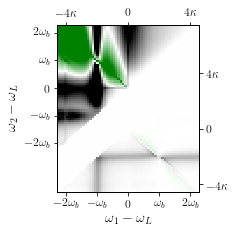

In [58]:
# mpl.rcParams['svg.fonttype'] = 'none'

npoints = 61

kappa_a = 1.
kappa_b = .1 * kappa_a
# delta_gS = [0., .5, 1.5] 
Omega = .1 * kappa_a

wb = 2 * kappa_a
g0 = .1 * kappa_a
suffix = "_Fig6_RE_g01";
wd1S = np.linspace(-4.5, 4.5, npoints)
dx = (wd1S[-1]-wd1S[0])/npoints
spectrumD1 = np.empty(npoints)
kappa_d = .05 * kappa_a
correlations = np.empty(shape=(npoints,npoints,6))

# ################################

redo = 1
N = 4
M = 5
Nall = N*M

if redo == 1:
    start = time.time()
    ii = 0
    a = tensor(destroy(N),qeye(M))
    b = tensor(qeye(N),destroy(M))
    ident = tensor(qeye(N),qeye(M))
    c_ops = [np.sqrt(kappa_a) * a, np.sqrt(kappa_b) * b]

    delta_g = g0**2/wb
    detuning = delta_g
    Hoptomech = detuning*a.dag()*a + wb*b.dag()*b - g0*a.dag()*a*(b + b.dag()) + 1j * Omega * (a.dag() - a)
    rho_ss = steadystate(Hoptomech, c_ops, method = 'direct')
    alpha = expect(a, rho_ss)

    HOM = detuning*a.dag()*a + wb*b.dag()*b - g0*(alpha*a.dag()+np.conj(alpha)*a)*(b.dag()+b)
    rho_ss = steadystate(Hoptomech, c_ops, method = 'direct')
    lv = liouvillian(Hoptomech, c_ops)
#     alpha = expect(a, rho_ss)

    for wd1 in wd1S:
        jj = 0
        for wd2 in wd1S[0:(ii+1)]:
#             correlations[ii,jj] = \
#             [wd1, wd2, calc_CSI(rho_ss, lv, kappa_d, wd1, wd2, a, Nall), 1, N]
#             correlations[jj,ii] = correlations[ii,jj]
            correlations[ii,jj] = [wd1, wd2, 0., \
             calc_CSI(rho_ss, lv, kappa_d, wd1, wd2, a-alpha*ident, Nall), 1, N]
            correlations[jj,ii] = [wd2, wd1, 0., \
             calc_CSI(rho_ss, lv, kappa_d, wd1, wd2, a, Nall), 1, N]
            jj += 1
        ii += 1
    end = time.time()
    print(end-start)

    with open("colored_CSI_OM_N=" + str(N) + "_M=" + str(M) + "_npoints=" + str(npoints) + suffix + ".txt", "wb") as fp: 
        pickle.dump(correlations, fp)

with open("colored_CSI_OM_N=" + str(N) + "_M=" + str(M) + "_npoints=" + str(npoints) + suffix + ".txt", "rb") as fp:
    correlations2 = pickle.load(fp)

toPlot = np.zeros(shape=(npoints,npoints,3))
# toPlot = correlations2[:, :, 0:3]
toPlot = correlations2[:, :, [0,1,3]]
xs = correlations2[:, :, 0].flatten()
ys = correlations2[:, :, 1].flatten()

fig, ax = plt.subplots(1, 1)
# fig.set_size_inches(1.56*3.2,1.07*3)
fig.set_size_inches(1.195*3,4)

addpoints = 20
wd1Sext = np.append(np.linspace(-4.5, 4.5, npoints), np.linspace(4.5+dx, 4.5+dx*addpoints, addpoints))
xGrid, yGrid = np.meshgrid(wd1S, wd1Sext)
xGride = np.append(xGrid, np.transpose([np.ones(npoints+addpoints)*(xGrid[0,-1]+dx)]), axis=1)
xGridee = np.append(xGride, [xGride[-1]], axis=0)-.5*dx
yGride = np.append(yGrid, np.transpose([yGrid[:,0]]), axis=1)
yGridee = np.append(yGride, [np.ones(npoints+1+0*addpoints)*(yGrid[-1,0]+dx)], axis=0)-.5*dx


zGrid = toPlot[:,:,2]
zMin = np.float64(-1)
zMax = np.float64(1)
# zMin = np.float64(0)
# zMax = np.float64(2)
blue_red1 = LinearSegmentedColormap.from_list('mycmap', [
    (0., 'black'),
    (-zMin/(zMax-zMin), 'white'),
    (1.0000, 'green')])
blue_red1.set_over('green')
blue_red1.set_under('black')

# toPlot2 = np.ones(shape=(npoints+addpoints,npoints+addpoints,3))
toPlot2 = np.ones(shape=(npoints+addpoints,npoints,3))
for i in range(npoints):
    for j in range(npoints):
        if i>=j:
            toPlot2[i+1*addpoints,j,2] = toPlot[i,j,2]
        else:
            toPlot2[i,j+0*addpoints,2] = toPlot[i,j,2]
z = (np.log10(toPlot[:,:,2])-zMin)/(zMax-zMin);
im = ax.pcolormesh(xGridee, yGridee, toPlot2[:,:,2], norm=mcolors.LogNorm(vmin=10**zMin, vmax=10**zMax), cmap=blue_red1, rasterized='true')
# cbar = fig.colorbar(im, ticks=[.01, .1, 1, 10, 100], pad=.17)

ax.set_xticks([-4,-2,0,2,4])
ax.set_yticks([-4+addpoints*dx,-2+addpoints*dx,0+addpoints*dx,2+addpoints*dx,4+addpoints*dx])

ax.set_xticklabels([r'$-2\omega_b$',r'$-\omega_b$',r'$0$',r'$\omega_b$',r'$2\omega_b$'], fontsize=fts2)
ax.set_yticklabels([r'$-2\omega_b$',r'$-\omega_b$',r'$0$',r'$\omega_b$',r'$2\omega_b$'], fontsize=fts2)


ax.set_xlabel(r'$\omega_1-\omega_L$', fontsize=fts)
ax.set_ylabel(r'$\omega_2-\omega_L$', fontsize=fts)

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks([-4,0,4])
ax2.set_xticklabels([r'$-4\kappa$',r'$0$',r'$4\kappa$'], fontsize=fts2)

ay2 = ax.twinx()
ay2.set_ylim(ax.get_xlim())
ay2.set_yticks([-4,0,4])
ay2.set_yticklabels([r'$-4\kappa$',r'$0$',r'$4\kappa$'], fontsize=fts2)

plt.xlim(xGridee[0,0], xGridee[0,-1])
plt.ylim(yGridee[0,0], yGridee[-1,0])

plt.gcf().subplots_adjust(bottom=0.3, left=0.3, right=.85)

ax.set_rasterized(True) 

fig.savefig('CSI_7a_RE.svg', dpi=1000)
fig.savefig('CSI_7a_RE.png', dpi=1000)

plt.show()


## Figure 7b

1698.4579410552979


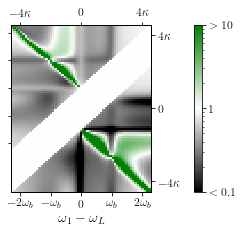

In [20]:
# mpl.rcParams['svg.fonttype'] = 'none'

npoints = 61

kappa_a = 1.
kappa_b = .1 * kappa_a
# delta_gS = [0., .5, 1.5] 
Omega = .1 * kappa_a

wb = 2 * kappa_a
g0 = 1 * kappa_a
suffix = "_Fig6_RE_g1";
wd1S = np.linspace(-4.5, 4.5, npoints)
dx = (wd1S[-1]-wd1S[0])/npoints
spectrumD1 = np.empty(npoints)
kappa_d = .05 * kappa_a
correlations = np.empty(shape=(npoints,npoints,6))

# ################################

redo = 1
N = 4
M = 8
Nall = N*M

if redo == 1:
    start = time.time()
    ii = 0
    a = tensor(destroy(N),qeye(M))
    b = tensor(qeye(N),destroy(M))
    ident = tensor(qeye(N),qeye(M))
    c_ops = [np.sqrt(kappa_a) * a, np.sqrt(kappa_b) * b]

    delta_g = g0**2/wb
    detuning = delta_g
    Hoptomech = detuning*a.dag()*a + wb*b.dag()*b - g0*a.dag()*a*(b + b.dag()) + 1j * Omega * (a.dag() - a)
    rho_ss = steadystate(Hoptomech, c_ops, method = 'direct')
    alpha = expect(a, rho_ss)

    Hoptomech = detuning*a.dag()*a + wb*b.dag()*b - g0*(alpha*a.dag()+np.conj(alpha)*a)*(b.dag()+b)
    rho_ss = steadystate(Hoptomech, c_ops, method = 'direct')
    lv = liouvillian(Hoptomech, c_ops)
#     alpha = expect(a, rho_ss)

    for wd1 in wd1S:
        jj = 0
        for wd2 in wd1S[0:(ii+1)]:
#             correlations[ii,jj] = \
#             [wd1, wd2, calc_CSI(rho_ss, lv, kappa_d, wd1, wd2, a, Nall), 1, N]
#             correlations[jj,ii] = correlations[ii,jj]
            correlations[ii,jj] = [wd1, wd2, 0., \
             calc_CSI(rho_ss, lv, kappa_d, wd1, wd2, a-alpha*ident, Nall), 1, N]
            correlations[jj,ii] = [wd2, wd1, 0., \
             calc_CSI(rho_ss, lv, kappa_d, wd1, wd2, a, Nall), 1, N]
            jj += 1
        ii += 1
    end = time.time()
    print(end-start)

    with open("colored_CSI_OM_N=" + str(N) + "_M=" + str(M) + "_npoints=" + str(npoints) + suffix + ".txt", "wb") as fp: 
        pickle.dump(correlations, fp)

with open("colored_CSI_OM_N=" + str(N) + "_M=" + str(M) + "_npoints=" + str(npoints) + suffix + ".txt", "rb") as fp:
    correlations2 = pickle.load(fp)

toPlot = np.zeros(shape=(npoints,npoints,3))
toPlot = correlations2[:, :, [0,1,3]]
xs = correlations2[:, :, 0].flatten()
ys = correlations2[:, :, 1].flatten()

fig, ax = plt.subplots(1, 1)
# fig.set_size_inches(3, 3)
fig.set_size_inches(1.4*3.2,4)
# fig.set_size_inches(1.56*3.2,4)

addpoints = 20
wd1Sext = np.append(np.linspace(-4.5, 4.5, npoints), np.linspace(4.5+dx, 4.5+dx*addpoints, addpoints))
xGrid, yGrid = np.meshgrid(wd1S, wd1Sext)
xGride = np.append(xGrid, np.transpose([np.ones(npoints+addpoints)*(xGrid[0,-1]+dx)]), axis=1)
xGridee = np.append(xGride, [xGride[-1]], axis=0)-.5*dx
yGride = np.append(yGrid, np.transpose([yGrid[:,0]]), axis=1)
yGridee = np.append(yGride, [np.ones(npoints+1+0*addpoints)*(yGrid[-1,0]+dx)], axis=0)-.5*dx


zGrid = toPlot[:,:,2]
zMin = np.float64(-1)
zMax = np.float64(1)
# zMin = np.float64(0)
# zMax = np.float64(2)
blue_red1 = LinearSegmentedColormap.from_list('mycmap', [
    (0., 'black'),
    (-zMin/(zMax-zMin), 'white'),
    (1.0000, 'green')])
blue_red1.set_over('green')
blue_red1.set_under('black')

# toPlot2 = np.ones(shape=(npoints+addpoints,npoints+addpoints,3))
toPlot2 = np.ones(shape=(npoints+addpoints,npoints,3))
for i in range(npoints):
    for j in range(npoints):
        if i>=j:
            toPlot2[i+1*addpoints,j,2] = toPlot[i,j,2]
        else:
            toPlot2[i,j+0*addpoints,2] = toPlot[i,j,2]
z = (np.log10(toPlot[:,:,2])-zMin)/(zMax-zMin);
im = ax.pcolormesh(xGridee, yGridee, toPlot2[:,:,2], norm=mcolors.LogNorm(vmin=10**zMin, vmax=10**zMax), cmap=blue_red1, rasterized='true')

cbar = fig.colorbar(im, ticks=[.01, .1, 1, 10, 100], pad=.2)
cbar.set_ticks([.1,1,10]) 
cbar.ax.set_yticklabels([r'$<0.1$', r'$1$', r'$>10$'], fontsize=fts2)

ax.set_xticks([-4,-2,0,2,4])
ax.set_yticks([-4+addpoints*dx,-2+addpoints*dx,0+addpoints*dx,2+addpoints*dx,4+addpoints*dx])

ax.set_xticklabels([r'$-2\omega_b$',r'$-\omega_b$',r'$0$',r'$\omega_b$',r'$2\omega_b$'], fontsize=fts2)
ax.set_yticklabels(['','','','',''])
ax.set_xlabel(r'$\omega_1-\omega_L$', fontsize=fts)
# ax.set_ylabel(r'$\omega_2-\omega_l$', fontsize=12)
# ax.set(#title= r'2PS w/ coh; $g_0=1.5$',

plt.xlim(xGridee[0,0], xGridee[0,-1])
plt.ylim(yGridee[0,0], yGridee[-1,0])

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks([-4,0,4])
ax2.set_xticklabels([r'$-4\kappa$',r'$0$',r'$4\kappa$'], fontsize=fts2)

ay2 = ax.twinx()
ay2.set_ylim(ax.get_xlim())
ay2.set_yticks([-4,0,4])
ay2.set_yticklabels([r'$-4\kappa$',r'$0$',r'$4\kappa$'], fontsize=fts2)


# plt.gcf().subplots_adjust(bottom=0.2, left=0.02, right=.672, top=0.856)
# plt.gcf().subplots_adjust(bottom=0.205, left=0.02, right=.685, top=0.856)
# plt.gcf().subplots_adjust(bottom=0.27, left=0.27, right=.85)

plt.gcf().subplots_adjust(bottom=0.3, left=0.02, right=.685)

ax.set_rasterized(True) 

fig.savefig('CSI_7b_RE.svg', dpi=1000)
fig.savefig('CSI_7b_RE.png', dpi=1000)

plt.show()


# Figure 8

In [ ]:
kappa_a = 1
kappa_b = .1
kappa_d = .05

wb = 2
Omega = .1
g0 = 1
delta_g = g0**2/wb
# fn = Omega*(g0/wb)**n/n!
f0 = Omega
f1 = Omega*(g0/wb)/1
f2 = Omega*(g0/wb)**2/2
f3 = Omega*(g0/wb)**3/6

detuning = delta_g

# alpha = np.abs(Omega/(1j*detuning + .5))

## Figure 8a

In [ ]:

npoints = 161

kappa_a = 1.

N = 4
M = 6
Nall = N*M

a = tensor(destroy(N),qeye(M))
b = tensor(qeye(N),destroy(M))
ident = tensor(qeye(N),qeye(M))
nn = a.dag()*a

suffix = "_coh1_sq";
wd1S = np.linspace(-1, 1, npoints)
dx = (wd1S[-1]-wd1S[0])/npoints
spectrumD1 = np.empty(npoints)
correlations = np.empty(shape=(npoints,npoints,6))

# ################################

redo = 0

if redo == 1:
    start = time.time()
    ii = 0
    c_ops = [np.sqrt(kappa_a) * a, np.sqrt(kappa_b) * b]

#     Hamiltonian = detuning*a.dag()*a + wb*b.dag()*b \
#         + 1j*f2*(a.dag() - a)*(b.dag() - b)*(b.dag() - b)
    Hamiltonian = detuning*a.dag()*a + wb*b.dag()*b \
        + 1j*f1*(a.dag()*b.dag()-a*b)
    rho_ss = steadystate(Hamiltonian, c_ops, method = 'direct')
    
    lv = liouvillian(Hamiltonian, c_ops)
    for wd1 in wd1S:
        jj = 0
        for wd2 in wd1S[0:(ii+1)]:
            correlations[ii,jj] = [wd1, wd2, 0., \
             calc_g_Gamma12(rho_ss, lv, kappa_d, wd1, wd2, a, Nall), 1, N]
#             correlations[jj,ii] = [wd2, wd1, 0., \
#              calc_g_Gamma12(rho_ss, lv, kappa_d, wd1, wd2, a, Nall), 1, N]           
            correlations[jj,ii] = correlations[ii,jj]
            jj += 1
        ii += 1
    end = time.time()
    print(end-start)

    with open("colored_g2_test1smg0_N=" + str(N) + "_npoints=" + str(npoints) + suffix + ".txt", "wb") as fp: 
        pickle.dump(correlations, fp)

with open("colored_g2_test1smg0_N=" + str(N) + "_npoints=" + str(npoints) + suffix + ".txt", "rb") as fp:
    correlations2 = pickle.load(fp)

toPlot = np.zeros(shape=(npoints,npoints,3))
# toPlot = correlations2[:, :, 0:3]
toPlot = correlations2[:, :, [0,1,3]]
xs = correlations2[:, :, 0].flatten()
ys = correlations2[:, :, 1].flatten()

fig, ax = plt.subplots(1, 1)
# fig.set_size_inches(.85*.8*6,.85*4)
fig.set_size_inches(2.9, 2.9)

# xGrid, yGrid = np.meshgrid(wd1S - wa*np.ones(npoints), wd1S - wa*np.ones(npoints))
xGrid, yGrid = np.meshgrid(wd1S, wd1S)
xGride = np.append(xGrid, np.transpose([np.ones(npoints)*(xGrid[0,-1]+dx)]), axis=1)
xGridee = np.append(xGride, [xGride[-1]], axis=0)-.5*dx

yGride = np.append(yGrid, np.transpose([yGrid[:,0]]), axis=1)
yGridee = np.append(yGride, [np.ones(npoints+1)*(yGrid[-1,0]+dx)], axis=0)-.5*dx

zGrid = toPlot[:,:,2]
# zMax = np.float64(100)
zMin = np.float64(.5)
zMax = np.float64(5)
# zMin = np.float64(0.1)
# zMax = np.float64(2)
# zMin = np.float64(0.5)
dm = np.log10(zMax/zMin)
blue_red1 = LinearSegmentedColormap.from_list('mycmap', [
    (0, 'blue'),
#     (np.log10(1/zMin)/dm, 'blue'),
    (np.log10(1/zMin)/dm, 'white'),
    (1.0000, 'red')])

im = ax.pcolormesh(xGridee, yGridee, np.log10(toPlot[:,:,2]), vmin=np.log10(zMin), vmax=np.log10(zMax), cmap=blue_red1)
cbar = fig.colorbar(im, ax=ax, pad=.05)
# cbar.set_ticks([-1, 0, 1] + list(range(0,math.floor(zMax.astype(int))+1,5))) 
# cbar.set_ticks([-1, 0, 1]) 
cbar.set_ticks([np.log10(zMin), 0, np.log10(zMax)]) 
cbar.ax.set_yticklabels([r'$<0.5$', r'$1$', r'$>5$'])

ax.set_xticks([-1,0,1])
ax.set_yticks([-1,0,1])

ax.set_xticklabels([r'$-\kappa$',r'$0$',r'$\kappa$'], fontsize=fts2)
ax.set_yticklabels([r'$-\kappa$',r'$0$',r'$\kappa$'], fontsize=fts2)

ax.set_xlabel(r'$\omega_1-\omega_L$', fontsize=fts)
ax.set_ylabel(r'$\omega_2-\omega_L$', fontsize=fts)

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks([-.5,0,.5])
ax2.set_xticklabels([r'$-5\gamma$',r'$0$',r'$5\gamma$'], fontsize=fts2)

# ay2 = ax.twinx()
# ay2.set_ylim(ax.get_xlim())
# ay2.set_yticks([-4,0,4])
# ay2.set_yticklabels([r'$-4\kappa$',r'$0$',r'$4\kappa$'], fontsize=fts2)

plt.xlim(xGridee[0,0], xGridee[0,-1])
plt.ylim(yGridee[0,0], yGridee[-1,0])

plt.gcf().subplots_adjust(bottom=0.305, left=0.2, right=.92)

fig.savefig('2PS_8a.svg', dpi=1000)
fig.savefig('2PS_8a.png', dpi=1000)

plt.show()

## Figure 8b

In [ ]:

npoints = 161

kappa_a = 1.

N = 4
M = 6
Nall = N*M

a = tensor(destroy(N),qeye(M))
b = tensor(qeye(N),destroy(M))
ident = tensor(qeye(N),qeye(M))
nn = a.dag()*a

suffix = "_coh1_sqab";
wd1S = np.linspace(-1, 1, npoints)
dx = (wd1S[-1]-wd1S[0])/npoints
spectrumD1 = np.empty(npoints)
correlations = np.empty(shape=(npoints,npoints,6))

# ################################

redo = 0

if redo == 1:
    start = time.time()
    ii = 0
    c_ops = [np.sqrt(kappa_a) * a, np.sqrt(kappa_b) * b]

#     Hamiltonian = detuning*a.dag()*a + wb*b.dag()*b \
#         + 1j*f2*(a.dag() - a)*(b.dag() - b)*(b.dag() - b)
    Hamiltonian = detuning*a.dag()*a + wb*b.dag()*b \
        + 1j*f1*(a.dag()*b.dag()-a*b)
    rho_ss = steadystate(Hamiltonian, c_ops, method = 'direct')
    
    lv = liouvillian(Hamiltonian, c_ops)
    for wd1 in wd1S:
        jj = 0
        for wd2 in wd1S[0:(ii+1)]:
            correlations[ii,jj] = [wd1, wd2, 0., \
             calc_g_Gamma12_twooperators(rho_ss, lv, kappa_d, wd1, wd2, a, b, Nall), 1, N]
#             correlations[jj,ii] = [wd2, wd1, 0., \
#              calc_g_Gamma12(rho_ss, lv, kappa_d, wd1, wd2, a, Nall), 1, N]           
            correlations[jj,ii] = correlations[ii,jj]
            jj += 1
        ii += 1
    end = time.time()
    print(end-start)

    with open("colored_g2_test1smg0_N=" + str(N) + "_npoints=" + str(npoints) + suffix + ".txt", "wb") as fp: 
        pickle.dump(correlations, fp)

with open("colored_g2_test1smg0_N=" + str(N) + "_npoints=" + str(npoints) + suffix + ".txt", "rb") as fp:
    correlations2 = pickle.load(fp)

toPlot = np.zeros(shape=(npoints,npoints,3))
# toPlot = correlations2[:, :, 0:3]
toPlot = correlations2[:, :, [0,1,3]]
xs = correlations2[:, :, 0].flatten()
ys = correlations2[:, :, 1].flatten()

fig, ax = plt.subplots(1, 1)
# fig.set_size_inches(.85*.8*6,.85*4)
fig.set_size_inches(2.9, 2.9)

# xGrid, yGrid = np.meshgrid(wd1S - wa*np.ones(npoints), wd1S - wa*np.ones(npoints))
xGrid, yGrid = np.meshgrid(wd1S, wd1S)
xGride = np.append(xGrid, np.transpose([np.ones(npoints)*(xGrid[0,-1]+dx)]), axis=1)
xGridee = np.append(xGride, [xGride[-1]], axis=0)-.5*dx

yGride = np.append(yGrid, np.transpose([yGrid[:,0]]), axis=1)
yGridee = np.append(yGride, [np.ones(npoints+1)*(yGrid[-1,0]+dx)], axis=0)-.5*dx

zGrid = toPlot[:,:,2]
zMax = np.float64(1e4)
zMin = np.float64(1)
# zMax = np.float64(10)
# zMin = np.float64(0.1)
# zMax = np.float64(2)
# zMin = np.float64(0.5)
dm = np.log10(zMax/zMin)
blue_red1 = LinearSegmentedColormap.from_list('mycmap', [
    (0, 'blue'),
#     (np.log10(1/zMin)/dm, 'blue'),
    (np.log10(1/zMin)/dm, 'white'),
    (1.0000, 'red')])

im = ax.pcolormesh(xGridee, yGridee, np.log10(toPlot[:,:,2]), vmin=np.log10(zMin), vmax=np.log10(zMax), cmap=blue_red1)
cbar = fig.colorbar(im, ax=ax, pad=.05)
# cbar.set_ticks([-1, 0, 1] + list(range(0,math.floor(zMax.astype(int))+1,5))) 
# cbar.set_ticks([-1, 0, 1]) 
cbar.set_ticks([0, 2, np.log10(zMax)]) 
cbar.ax.set_yticklabels([ r'$1$', r'$10^2$', r'$>10^4$'])
# cbar.ax.set_yticklabels(['0.01', '1', '>100'])
# cbar.ax.set_yticklabels(['0.1', '1', '>10'])
# cbar.ax.set_yticklabels([zMin, '1', '>2'])

ax.set_xticks([-1,0,1])
ax.set_yticks([-1,0,1])

ax.set_xticklabels([r'$-\kappa$',r'$0$',r'$\kappa$'], fontsize=fts2)
ax.set_yticklabels([r'$-\kappa$',r'$0$',r'$\kappa$'], fontsize=fts2)


ax.set_xlabel(r'$\omega_1-\omega_L$', fontsize=fts)
# ax.set_ylabel(r'$\omega_2-\omega_L$', fontsize=fts)

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks([-.5,0,.5])
ax2.set_xticklabels([r'$-5\gamma$',r'$0$',r'$5\gamma$'], fontsize=fts2)

# ay2 = ax.twinx()
# ay2.set_ylim(ax.get_xlim())
# ay2.set_yticks([-.5,0,.5])
# ay2.set_yticklabels([r'$5\gamma$',r'$0$',r'$5\gamma$'], fontsize=fts2)

plt.xlim(xGridee[0,0], xGridee[0,-1])
plt.ylim(yGridee[0,0], yGridee[-1,0])

plt.gcf().subplots_adjust(bottom=0.305, left=0.11, right=.821)

fig.savefig('2PS_8b.svg', dpi=1000)
fig.savefig('2PS_8b.png', dpi=1000)

plt.show()

# Figure 9

In [ ]:
kappa_a = 1.
kappa_b = .1
wb = 2
Omega = .1
g0 = .08
delta_g = g0**2/wb
# fn = Omega*(g0/wb)**n/n!

detuning = delta_g

N = 4
M = 14
Nall = N*M

suffix = "_g0Gamma";
kappa_d = .05 * kappa_a

## Figure 9a

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(3, 2.6)

start = time.time()

npoints = 50

sS = np.zeros(npoints)	

a = tensor(destroy(N),qeye(M))
b = tensor(qeye(N),destroy(M))
c_ops = [ np.sqrt(kappa_a) * a, np.sqrt(kappa_b) * b]
correlationsSaS = np.empty(shape=(npoints))
correlationsLeapfrog0K = np.empty(shape=(npoints))
correlations0 = np.empty(shape=(npoints))
ii = 0
g0 = .5*kappa_a 
delta_g = g0**2/wb
detuning = delta_g
c_ops = [np.sqrt(kappa_a) * a, np.sqrt(kappa_b) * b]
HOM = detuning*a.dag()*a + wb*b.dag()*b - g0*a.dag()*a*(b.dag()+b) + 1.j*Omega*(a.dag() - a)
rho_ss = steadystate(HOM, c_ops, method = 'direct')
lv = liouvillian(HOM, c_ops)

kappa_dS = 10**np.linspace(-4, np.log10(5), npoints)
for kappa_d in kappa_dS:
    wd1 = -2 
    wd2 = -wd1
    correlationsSaS[ii] = calc_g_Gamma12(rho_ss, lv, kappa_d, wd1, wd2, a, Nall)
    wd1 = -1 
    wd2 = -wd1
    correlationsLeapfrog0K[ii] = calc_g_Gamma12(rho_ss, lv, kappa_d, wd1, wd2, a, Nall)
    correlations0[ii] = expect(a.dag()*a.dag()*a*a, rho_ss)/expect(a.dag()*a, rho_ss)**2 
    ii = ii+1

ax.loglog(kappa_dS, correlationsSaS, color='tab:orange', linestyle='-', lw=2., label='')
ax.loglog(kappa_dS, correlationsLeapfrog0K, color='tab:green', linestyle='-', lw=2., label='')
ax.loglog(kappa_dS, correlations0, color='tab:blue', linestyle='-', lw=2., label='')

nbth = .1
c_ops = [ np.sqrt(kappa_a) * a, np.sqrt(kappa_b * (1+nbth)) * b, np.sqrt(kappa_b * nbth) * b.dag()]
correlationsLeapfrogHighK = np.empty(shape=(npoints))

g0 = .5*kappa_a 
delta_g = g0**2/wb
detuning = delta_g
HOM = detuning*a.dag()*a + wb*b.dag()*b - g0*a.dag()*a*(b.dag()+b) + 1.j*Omega*(a.dag() - a)
rho_ss = steadystate(HOM, c_ops, method = 'direct')
lv = liouvillian(HOM, c_ops)

ii = 0
for kappa_d in kappa_dS:
    wd1 = -2 
    wd2 = -wd1
    correlationsSaS[ii] = calc_g_Gamma12(rho_ss, lv, kappa_d, wd1, wd2, a, Nall)
    wd1 = -1 
    wd2 = -wd1
    correlationsLeapfrogHighK[ii] = calc_g_Gamma12(rho_ss, lv, kappa_d, wd1, wd2, a, Nall)
    correlations0[ii] = expect(a.dag()*a.dag()*a*a, rho_ss)/expect(a.dag()*a, rho_ss)**2 
    ii = ii+1

ax.loglog(kappa_dS, correlationsSaS, color='tab:orange', linestyle='--', lw=2., label='')
ax.loglog(kappa_dS, correlationsLeapfrogHighK, color='tab:green', linestyle='--', lw=2., label='')
ax.loglog(kappa_dS, correlations0, color='tab:blue', linestyle='--', lw=2., label='')

end = time.time()
print(end-start)

# ax.legend()
plt.xticks(xticks)

ax.set_xlabel(r'$\Gamma/\kappa$', fontsize=fts)
ax.set_ylabel(r'$g_{\Gamma}^{(2)}(\omega_1,\omega_2),~g^{(2)}(0)$', fontsize=fts)
ax.set_xlim(.00009,5)
xticks = np.array([.0001,0.01,1])
ax.set_xticks(xticks)
ax.set_xticklabels([r'$10^{-4}$',r'$10^{-2}$',r'$1$'], fontsize=fts2)
yticks = np.array([1, 1e1, 1e2])
ax.set_yticks(yticks)
ax.set_yticklabels([r'$1$',r'$10$',r'$10^2$'], fontsize=fts2)

plt.axhline(y=1, color='k', linestyle='--', label='', linewidth=1)
plt.axvline(x=.05, color='k', linestyle='--', label='', linewidth=1)

fig.savefig('Fig9a.png', dpi=1000)
fig.savefig('Fig9a.svg', dpi=1000)


plt.show()



## Figure 9b

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(3, 2.6)

start = time.time()

npoints = 50

sS = np.zeros(npoints)	

a = tensor(destroy(N),qeye(M))
b = tensor(qeye(N),destroy(M))
ident = tensor(qeye(N),qeye(M))

c_ops = [ np.sqrt(kappa_a) * a, np.sqrt(kappa_b) * b]
correlationsSaS = np.empty(shape=(npoints))
correlationsLeapfrog0K = np.empty(shape=(npoints))
correlations0 = np.empty(shape=(npoints))
ii = 0
g0 = .5*kappa_a 
delta_g = g0**2/wb
detuning = delta_g
c_ops = [np.sqrt(kappa_a) * a, np.sqrt(kappa_b) * b]
HOM = detuning*a.dag()*a + wb*b.dag()*b - g0*a.dag()*a*(b.dag()+b) + 1.j*Omega*(a.dag() - a)
rho_ss = steadystate(HOM, c_ops, method = 'direct')
lv = liouvillian(HOM, c_ops)
alpha = expect(a, rho_ss)

kappa_dS = 10**np.linspace(-4, np.log10(5), npoints)
for kappa_d in kappa_dS:
    wd1 = -2 
    wd2 = -wd1
    correlationsSaS[ii] = calc_g_Gamma12(rho_ss, lv, kappa_d, wd1, wd2, a-alpha*ident, Nall)
    wd1 = -1 
    wd2 = -wd1
    correlationsLeapfrog0K[ii] = calc_g_Gamma12(rho_ss, lv, kappa_d, wd1, wd2, a-alpha*ident, Nall)
#     correlations0[ii] = expect(a.dag()*a.dag()*a*a, rho_ss)/expect(a.dag()*a, rho_ss)**2 
    correlations0[ii] = expect((a.dag()-np.conj(alpha)*ident)*(a.dag()-np.conj(alpha)*ident)*(a-alpha*ident)*(a-alpha*ident), rho_ss)/expect((a.dag()-np.conj(alpha)*ident)*(a-alpha*ident), rho_ss)**2   
    ii = ii+1

ax.loglog(kappa_dS, correlationsSaS, color='tab:orange', linestyle='-', lw=2., label='')
ax.loglog(kappa_dS, correlationsLeapfrog0K, color='tab:green', linestyle='-', lw=2., label='')
ax.loglog(kappa_dS, correlations0, color='tab:blue', linestyle='-', lw=2., label='')

nbth = .1
c_ops = [ np.sqrt(kappa_a) * a, np.sqrt(kappa_b * (1+nbth)) * b, np.sqrt(kappa_b * nbth) * b.dag()]
correlationsLeapfrogHighK = np.empty(shape=(npoints))

g0 = .5*kappa_a 
delta_g = g0**2/wb
detuning = delta_g
HOM = detuning*a.dag()*a + wb*b.dag()*b - g0*a.dag()*a*(b.dag()+b) + 1.j*Omega*(a.dag() - a)
rho_ss = steadystate(HOM, c_ops, method = 'direct')
lv = liouvillian(HOM, c_ops)
alpha = expect(a, rho_ss)

ii = 0
for kappa_d in kappa_dS:
    wd1 = -2 
    wd2 = -wd1
    correlationsSaS[ii] = calc_g_Gamma12(rho_ss, lv, kappa_d, wd1, wd2, a-alpha*ident, Nall)
    wd1 = -1 
    wd2 = -wd1
    correlationsLeapfrogHighK[ii] = calc_g_Gamma12(rho_ss, lv, kappa_d, wd1, wd2, a-alpha*ident, Nall)
#     correlations0[ii] = expect(a.dag()*a.dag()*a*a, rho_ss)/expect(a.dag()*a, rho_ss)**2 
    correlations0[ii] = expect((a.dag()-np.conj(alpha)*ident)*(a.dag()-np.conj(alpha)*ident)*(a-alpha*ident)*(a-alpha*ident), rho_ss)/expect((a.dag()-np.conj(alpha)*ident)*(a-alpha*ident), rho_ss)**2   
    ii = ii+1

ax.loglog(kappa_dS, correlationsSaS, color='tab:orange', linestyle='--', lw=2., label='')
ax.loglog(kappa_dS, correlationsLeapfrogHighK, color='tab:green', linestyle='--', lw=2., label='')
ax.loglog(kappa_dS, correlations0, color='tab:blue', linestyle='--', lw=2., label='')

end = time.time()
print(end-start)

ax.set_xlabel(r'$\Gamma/\kappa$', fontsize=fts)
ax.set_ylabel(r'$g_{\Gamma}^{(2)}[\delta a](\omega_1,\omega_2),~g^{(2)}[\delta a](0)$', fontsize=fts)
ax.set_xlim(.00009,5)
xticks = np.array([.0001,0.01,1])
ax.set_xticks(xticks)
ax.set_xticklabels([r'$10^{-4}$',r'$10^{-2}$',r'$1$'], fontsize=fts2)
yticks = np.array([1, 1e1, 1e2, 1e3])
ax.set_yticks(yticks)
ax.set_yticklabels([r'$1$',r'$10$',r'$10^2$',r'$10^3$'], fontsize=fts2)

plt.axhline(y=1, color='k', linestyle='--', label='', linewidth=1)
plt.axvline(x=.05, color='k', linestyle='--', label='', linewidth=1)

fig.savefig('Fig9b.png', dpi=1000)
fig.savefig('Fig9b.svg', dpi=1000)


plt.show()

